# id5059_p2_group_project_2024.ipynb

In [12]:
## Install libraries (choose relevant package manager)
# !{sys.executable} -m pip install numpy pandas matplotlib scikit-learn | grep -v 'already satisfied'#pip-env
# %conda install numpy pandas matplotlib scikit-learn# -y#conda-env

In [13]:
# Import libraries
import numpy# as np
import pandas# as pd
import matplotlib# as plt
import sklearn

# Verify library versions
print("numpy version:", numpy.__version__)
print("pandas version:", pandas.__version__)
print("matplotlib version:", matplotlib.__version__)
print("scikit-learn version:", sklearn.__version__)

numpy version: 1.23.5
pandas version: 2.2.1
matplotlib version: 3.8.0
scikit-learn version: 1.2.2


# id5059 Predicting Liver Cirrhosis Outcomes (Group Project 2024)

## Dataset from Kaggle (fully labelled synthetic dataset)

### Web links

#### From the Specification
- Our synthetic dataset (for id5059 2024 and Kaggle competition 2023) https://www.kaggle.com/competitions/playground-series-s3e26/
- The real dataset (Mayo Clinic 1974 to 1984) https://www.kaggle.com/datasets/joebeachcapital/cirrhosis-patient-survival-prediction
#### Additional links
- Generic web search (kaggle + liver + cirrhosis) https://duckduckgo.com/?q=kaggle+liver+cirrhosis
- Various research papers on ML approaches to this task

The reason medics collect data on these features is because we know these markers predict disease outcome already from medical domain knowledge.

### Dataset background

Our synthetic dataset is based on the real dataset from the Mayo Clinic collected across 1974 to 1984, which has the following description from Kaggle:


#### Real Mayo Clinic Liver Cirrhosis Dataset (1974 to 1984):
"Use 18 clinical features for predicting survival state of patients with liver cirrhosis. The survival states include 0 = D (death), 1 = C (censored), 2 = CL (censored due to liver transplantation).

For what purpose was the dataset created?

- Cirrhosis results from prolonged liver damage, leading to extensive scarring, often due to conditions like hepatitis or chronic alcohol consumption. The data provided is sourced from a Mayo Clinic study on primary biliary cirrhosis (PBC) of the liver carried out from 1974 to 1984.

Who funded the creation of the dataset?

- Mayo Clinic

What do the instances in this dataset represent?

- People

Does the dataset contain data that might be considered sensitive in any way?

- Sex, Age

Was there any data preprocessing performed?

- Drop all the rows where miss value (NA) were present in the Drug column
- Impute missing values with mean results
- One-hot encoding for all category attributes

Additional Information

- During 1974 to 1984, 424 PBC patients referred to the Mayo Clinic qualified for the randomized placebo-controlled trial testing the drug D-penicillamine. Of these, the initial 312 patients took part in the trial and have mostly comprehensive data. The remaining 112 patients didn't join the clinical trial but agreed to record basic metrics and undergo survival tracking. Six of these patients were soon untraceable after their diagnosis, leaving data for 106 of these individuals in addition to the 312 who were part of the randomized trial."

![Alt text](image.png)

### Load the synthetic dataset from Kaggle

In [14]:
import os
import pandas as pd

os.chdir('/Users/user/Documents/_work/coursework/id5059/p2/Coursework-2/data')

df = pd.read_csv('train.csv')
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# Data exploration
    # How imbalanced is our data? Quantify its sparseness so we can move on.
    # Our data is especially imbalanced with respect to transplants 'CL' at ~3% prevalence.

# List the unique values in the 'Status' column, ={​​D,C,CL}​​ as expected
unique_statuses = df_train['Status'].unique()
# Count the occurrences of each status value in the 'Status' column
status_counts = df_train['Status'].value_counts()
# Calculate the percentages
status_percentages = df_train['Status'].value_counts(normalize=True) * 100
# Create a DataFrame to hold counts and percentages side by side
status_summary = pd.DataFrame({
    'Counts': status_counts,
    'Percentage': status_percentages})

# Define a function to do this again later to verify fairness of Splits
# Define a function to compute counts and percentages for any given feature
def df_feature_count_percentage(df,featureName):
    # Check whether it's a dataFrame or dataSeries (i.e. already just the 'status' column)
    if isinstance(df, pd.Series):
        value_counts = df.value_counts(normalize=False)
        percentages = df.value_counts(normalize=True) * 100
        feature_summary = pd.DataFrame({
                'Counts': value_counts,
                'Percentage': percentages
            }).reset_index().rename(columns={'index': featureName})
        return feature_summary
    # Check if the feature exists in the DataFrame
    elif isinstance(df, pd.DataFrame):
        if featureName in df.columns:
            # featureName = str(featureName)
            # df_featureName = df[featureName]
            feature_counts = df[featureName].value_counts(normalize=False)
            feature_percentages = df[featureName].value_counts(normalize=True) * 100
            feature_summary = pd.DataFrame({
                    'Counts': feature_counts,
                    'Percentage': feature_percentages
                }).reset_index().rename(columns={'index': featureName})
            return feature_summary
    # Handle the case where the feature does not exist
    else:
        print(f"The feature '{featureName}' is not found in the DataFrame.")
        return

# Calculate total entries
total_entries = len(df_train) + len(df_test)
# Create a DataFrame to consolidate the information
data_sizes = pd.DataFrame({
    'Dataset': ['train.csv', 'test.csv'],
    'Count': [len(df_train), len(df_test)],
    'Percentage': [100 * len(df_train) / total_entries, 100 * len(df_test) / total_entries]})

# Print the counts
print('Unique `Status` classes:\n',unique_statuses,
      "\n-> {'D':Dead, 'C':Alive w/ Cirrhosis, 'CL':Alive w/ Transplant}")
print('\nClass prevalences across `train.csv`:',
      f"\n{status_summary}",'\n')
print("Size of datasets `train.csv` and `test.csv`:",'\n',
      data_sizes)
print(f'\nTask: Predict class probabilities for `test.csv` ({len(df_test)} entries with unknown classes)\n by training a model on `train.csv` examples ({len(df_train)} entries with known classes).')
# print('Counts of each `Status` value in `train.csv`:\n',df_train['Status'].value_counts(),'\n','\nLength of `train.csv`\n',len(df_train),'\n')
# print('Count of unknown `Status` values to be predicted across `test.csv`:\n',len(df_test))
# print('\nTotal data entries across `train.csv` and `test.csv`:\n',len(df_train)+len(df_test))
# print('\nPercentage share of total data entries across `train.csv` and `test.csv`:\n',
#       'train.csv',100*len(df_train)/(len(df_train)+len(df_test)),'%\n',
#       'test.csv',100*len(df_test)/(len(df_train)+len(df_test)),'%')

Unique `Status` classes:
 ['D' 'C' 'CL'] 
-> {'D':Dead, 'C':Alive w/ Cirrhosis, 'CL':Alive w/ Transplant}

Class prevalences across `train.csv`: 
        Counts  Percentage
Status                    
C         4965   62.808349
D         2665   33.712840
CL         275    3.478811 

Size of datasets `train.csv` and `test.csv`: 
      Dataset  Count  Percentage
0  train.csv   7905   59.995446
1   test.csv   5271   40.004554

Task: Predict class probabilities for `test.csv` (5271 entries with unknown classes)
 by training a model on `train.csv` examples (7905 entries with known classes).


In [15]:
# Focus on train.csv as my "full_data" set for now
# Verify basic information like
    # length of the full training data csv
    # Feature names: id + 18 features + target `Status`
df_train = pd.read_csv('train.csv')
full_data = df_train
full_data_info = full_data.info()
print('\nEach data entry consists of its ID, then 18 predictive features, and the target `Status` class label.')
# # Load the full training data csv
# full_data_path = 'train.csv'
# full_data = pd.read_csv(full_data_path)
# full_data_head = full_data.head()
# full_data_info, full_data_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             7905 non-null   int64  
 1   N_Days         7905 non-null   int64  
 2   Drug           7905 non-null   object 
 3   Age            7905 non-null   int64  
 4   Sex            7905 non-null   object 
 5   Ascites        7905 non-null   object 
 6   Hepatomegaly   7905 non-null   object 
 7   Spiders        7905 non-null   object 
 8   Edema          7905 non-null   object 
 9   Bilirubin      7905 non-null   float64
 10  Cholesterol    7905 non-null   float64
 11  Albumin        7905 non-null   float64
 12  Copper         7905 non-null   float64
 13  Alk_Phos       7905 non-null   float64
 14  SGOT           7905 non-null   float64
 15  Tryglicerides  7905 non-null   float64
 16  Platelets      7905 non-null   float64
 17  Prothrombin    7905 non-null   float64
 18  Stage   

The full `train.csv` dataset is loaded. It contains 7,905 entries and 20 features.

Next steps:
1. **Splitting the Data:** Initially, we'll perform an 80/20 split of the `train.csv` data into a training set and a validation set, using stratified sampling to maintain the distribution of the `Status` classes.
    
        Cross-validation: Later, instead of using a single validation set, we can use k-fold cross-validation, where the model is trained and validated on different subsets of the data multiple times. This approach reduces the risk of our model become overly tuned to a specific validation set.

2. **Splitting Imbalance Data:** Given the class imbalance, particularly the small proportion of the 'CL' class, we'll apply a stratified sampling technique during the split to avoid distorting the class distributions.
    
[ToDo] 3. **Deletion Scheme:** To explore the impact of data reduction while respecting the class imbalance, we'll initially remove 10% of the data using a stratified approach and later consider varying this percentage.
    
4. **Pre-processing:** Ahead of the selected models (e.g. gradient boosting, random forest), we'll apply necessary pre-processing steps, including scaling and normalization. This step will also facilitate more meaningful visualizations and analyses.
    
[ToDo] 5. **Alternative Feature Encoding:** Based on Pamela's suggestion, we can identify the alternative encoding technique to one-hot encoding she mentioned for use with categorical variables [???].
    
I'll begin by performing my stratified 80/20 data split. ​​

### Stratified 80/20 Split into Train/Validation datasets
- Stratified split, choosing 20% of each class to construct the validation set, in order to maintain the initial class distributions into both my new Train and Validation datasets.
- Cross-Validate later: Check fairness of a given 80/20 split by using cross-validation later, checking that my split isn't unfair in the sense that maybe all the deaths from Ascites went into the Validation set by pure chance with none in the Training set, or something else unrepresentative of the overall data.

In [16]:
# Splitting data 80/20 with stratification to maintain the class proportions
# The style for sklearn imports is to import specific functions from the documentation
from sklearn.model_selection import train_test_split

# Split full_data into `X` (just the features) and `y` (just the target variable `Status`)
X = full_data.drop('Status', axis=1)
y = full_data['Status']

# Stratified split of data while maintaining the distribution of the 'Status' classes
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

# Verify stratification by comparing class distributions in the full dataset and splits
print('Full 100% `train.csv` dataset:\n',df_feature_count_percentage(y,'Status'))
print('\nSplit 80% -> Training data only:\n',df_feature_count_percentage(y_train,'Status'))
print('\nSplit 20% -> Validation data only:\n',df_feature_count_percentage(y_val,'Status'))
# distribution_full = y.value_counts(normalize=True)
# distribution_train = y_train.value_counts(normalize=True)
# distribution_val = y_val.value_counts(normalize=True)

# # distribution_full, distribution_train, distribution_val
# print('Same exact proportions C,D,CL 62.8%,33.7%,3.5% are maintained upon an 80/20 split as the original count C,D,CL 4965,2665,275 is divisible by 5 into 4:1 ratio train:val sets.')
# print(distribution_full, distribution_train, distribution_val)
# print(y.value_counts(), y_train.value_counts(), y_val.value_counts())

Full 100% `train.csv` dataset:
   Status  Counts  Percentage
0      C    4965   62.808349
1      D    2665   33.712840
2     CL     275    3.478811

Split 80% -> Training data only:
   Status  Counts  Percentage
0      C    3972   62.808349
1      D    2132   33.712840
2     CL     220    3.478811

Split 20% -> Validation data only:
   Status  Counts  Percentage
0      C     993   62.808349
1      D     533   33.712840
2     CL      55    3.478811


The stratified 80/20 split successful, maintaining the distribution of the `Status` classes across the training and validation sets. The class proportions in both subsets closely match the original dataset:

    * C: Cirrhosis - Approximately 62.81%
    * D: Death - Approximately 33.71%
    * CL: Liver Cancer - Approximately 3.48%

### Pre-Processing (Categorical features -> OneHot, Numerical features -> zero mean and unit variance)

In [17]:
#! Pre-processing (StandardScaler)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Identify categorical and numerical features
categorical_features = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
numerical_features = X_train.columns.difference(categorical_features + ['id']) # Exclude 'id' from features

# Create a column transformer to apply different preprocessing to categorical and numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Fit a preprocessor to the training data, and Transform training set too
X_train_processed = preprocessor.fit_transform(X_train)
# Transform validation set (but do not fit the validation set!)
X_val_processed = preprocessor.transform(X_val)

# Convert processed data back to DataFrame for better readability (optional step)
X_train_processed_df = pd.DataFrame(X_train_processed, columns = preprocessor.get_feature_names_out())
X_val_processed_df = pd.DataFrame(X_val_processed, columns = preprocessor.get_feature_names_out())

# Inspect the processed data
X_train_processed_df.head()

,num__Age,num__Albumin,num__Alk_Phos,num__Bilirubin,num__Cholesterol,num__Copper,num__N_Days,num__Platelets,num__Prothrombin,num__SGOT,...,cat__Sex_M,cat__Ascites_N,cat__Ascites_Y,cat__Hepatomegaly_N,cat__Hepatomegaly_Y,cat__Spiders_N,cat__Spiders_Y,cat__Edema_N,cat__Edema_S,cat__Edema_Y
0,2.786334,0.735312,-0.437535,1.212277,-0.552543,3.906874,-0.246369,-1.943384,0.480320,0.914594,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
1,0.281587,0.618653,-0.423642,-0.150199,-0.609257,-0.443949,-0.077250,-0.398753,-0.929690,-0.315621,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
2,0.795451,0.443664,-0.193355,-0.176914,0.566258,-0.193447,0.572859,-0.122103,-0.929690,0.578321,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1.144781,-1.510372,-0.326932,2.681614,0.117706,0.742639,-1.654788,-0.871364,1.121234,0.687975,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,-0.753434,0.939465,-0.066723,-0.444067,1.174638,-0.087973,0.199160,0.062331,-1.186055,0.040494,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


The pre-processing steps have been successfully applied:

1. **Numerical Features:** Standardized to have zero mean and unit variance.
2. **Categorical Features:** One-hot encoded to ensure proper representation without implying ordinal relationships.

The transformed training data now has 25 features, because the one-hot encoding expanded each categorical variable value into its own binary feature.

**Choice of Scaler:** Choice between MinMaxScaler and StandardScaler can significantly impact a model's performance, depending on the data and model used.
- StandardScaler chosen.

#### MinMaxScaler versus StandardScaler (i.e Unit Range vs Unit Variance)
- StandardScaler chosen. 

        StandardScaler spreads the densist data according to its global variance, meaning outliers have little impact on the scaling. Whereas MinMaxScaler squashes all data to a [0,1] range limit, forcing outliers to lie in that range, meaning the mainstay of the data is somewhat more squashed to accommodate outliers. Each scaler has trade-offs in terms of interpretability and potential numerical problems. Although naively MinMaxScaling should cause more numerical precision issues, in practice it is generally more safely handled by downstream libraries. An additional step for either approach might be to 'Clip' data by some multiple of the variance (e.g 4-Sigma Clipping), beyond which we do not wish to be distracted by the magnitude of the outlier or compromise the distribution of the mainstay of the data.
##### MinMaxScaler explanation (scale to Unit Range [0,1]):
- **Normalize to Unit Range:** MinMaxScaler rescales the data to a specified range, typically 0 to 1. It transforms each feature by subtracting the minimum value and then dividing by the range (maximum minus minimum).
- For models sensitive to the magnitude of input features, like neural networks and distance-based algorithms (e.g., k-NN, SVM), MinMaxScaler can improve performance by maintaining the relative distances between feature values.
- In the context of log loss, if a model relies on activation functions or algorithms that behave better within a specific range (like 0 to 1), then MinMaxScaler can improve performance by sparing the model from dealing with extreme value ranges or negative inputs, which might affect convergence or activation function outputs.
##### StandardScaler explanation (scale to Unit Variance about Zero Mean):
- **Standardize to Unit Variance:** StandardScaler standardizes features by removing the mean and scaling to unit variance, creating a normal distribution about a 0 midpoint with standard deviation of 1. (Note: `Variance` seems to be used interchangeably with `StdDev` in this field, although the former is typically the latter squared.)
- Standardization, unlike normalization, does not limit values to a specific range, which might be beneficial for models not sensitive to the magnitude of values or models that assume input features are normally distributed.
- **Log loss signal:** If the model or its underlying components assume or perform better with data that resembles a normal distribution (zero mean and unit variance), then StandardScaler may do better.

##### **Group Query - Pamela:** 
- Claim: MinMaxScaler seems much better than StandardScaler for Log_Loss performance further downstream.

**How could that be? Contextual performance differences:**
- Perhaps this is spurious or misleading.
- Or if Pamela got better log_loss performance with MinMaxScaler, maybe her model or a component within it (e.g. a particular activation function in neural networks) benefits from having all features scaled within the same range.
- My worse log_loss when switching to MinMaxScaler could be attributed to my model architecture or specific data characteristics that align better with zero-centered, unit variance scaling. 
- But most likely, other differences in model configuration between my tests and Pamela's explain our different validation log_loss performance.
- So we have to compare our test prediction results as a fairer measure of performance, like the Kaggle score!

        Kaggle Scores imply Pamela's XGB+SMOTE model overfit sadly: 
            James (Model:GB+Weighted) -> 
                0.42 Test LogLoss on Kaggle
                0.45 Validation LogLoss locally. 
            Pamela (Model:XGB+SMOTE) -> 
                0.51 Test LogLoss on Kaggle
                0.41 Validation LogLoss locally. 
**Conclusion and Considerations**
- There isn't a one-size-fits-all answer; the "better" scaler depends on our specific model and data characteristics. Activation functions in neural networks (like sigmoid or tanh) might benefit more from MinMaxScaler due to their sensitivity to input magnitude and range.
- Avoid drawing conclusions from a single metric change without considering the full context of the model's training and validation process. Pamela's better log loss could have stemmed from overfitting or other model configuration differences, as suggested by our Kaggle results.
- #! Always validate data splitting and scaling choices with cross-validation and consider potential dataset shifts or distribution changes when moving from training/validation to real-world application or test datasets because a model might suffer from poor generalization to Test Datasets.

In [18]:
# #! Pre-processing (MinMaxScaler)
# from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
# from sklearn.compose import ColumnTransformer

# # Identify categorical and numerical features
# categorical_features = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
# numerical_features = X_train.columns.difference(categorical_features + ['id']) # Exclude 'id' from features

# # Create a column transformer to apply different preprocessing to categorical and numerical features
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', MinMaxScaler(), numerical_features),
#         ('cat', OneHotEncoder(), categorical_features)
#     ])

# # Fit a preprocessor to the training data, and Transform training set too
# X_train_processed = preprocessor.fit_transform(X_train)
# # Transform validation set (but do not fit the validation set!)
# X_val_processed = preprocessor.transform(X_val)

# # Convert processed data back to DataFrame for better readability (optional step)
# X_train_processed_df = pd.DataFrame(X_train_processed, columns = preprocessor.get_feature_names_out())
# X_val_processed_df = pd.DataFrame(X_val_processed, columns = preprocessor.get_feature_names_out())

# # Inspect the processed data
# X_train_processed_df.head()

In [19]:
# #! Confirmed scaling is already done by pre-processing step
# from sklearn.preprocessing import StandardScaler# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
# from sklearn.metrics import accuracy_score

# # Scale the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_processed)
# X_val_scaled = scaler.transform(X_val_processed)

# # Confirm the scaled and processed data are the same
# print(X_val_scaled)
# print(X_val_processed)
# #! Confirmed

In [20]:
# Log_loss calculator function
from sklearn.metrics import log_loss
def log_loss_calculator(model):
    # Ensure the best model is used to predict probabilities on the validation set
    y_val_pred_prob_model = model.predict_proba(X_val_processed)
    # Compute the log loss for the best model
    log_loss_val_model = log_loss(y_val, y_val_pred_prob_model)
    # Print the computed log loss
    print('log_loss_val:\n', log_loss_val_model)
    return log_loss_val_model

## Models (Gradient Boost, Random Forest, Neural Network)

#### Reference sklearn library documentation: 
https://scikit-learn.org/stable/modules/ensemble.html#ensemble

"1.11. Ensembles: <u>_**Gradient boosting**_</u>, <u>_**random forests**_</u>, bagging, voting, stacking

- Ensemble methods combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability / robustness over a single estimator. 
Two very famous examples of ensemble methods are <u>_**gradient-boosted trees**_</u> and <u>_**random forests**_</u>. 
More generally, ensemble models can be applied to any base learner beyond trees, in averaging methods such as Bagging methods, model stacking, or Voting, or in boosting, as AdaBoost."


### Gradient Boosting model

In [21]:
# Gradient boosting model
from sklearn.ensemble import GradientBoostingClassifier # https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble
from sklearn.metrics import classification_report, accuracy_score # https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

# Initialize the Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(random_state=42)# random seed=42 for reproducibility
# check out options to optimize parameters later https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

# Train the classifier on the train set
gb_classifier.fit(X_train_processed, y_train)

# Predict on the validation set (unseen data)
y_val_pred_gb = gb_classifier.predict(X_val_processed)

# Calculate accuracy and generate a classification report
accuracy_val_gb = accuracy_score(y_val, y_val_pred_gb)
classification_report_val_gb = classification_report(y_val, y_val_pred_gb)# print() the report for better formatting

log_loss_calculator(gb_classifier)
# accuracy_val_gb, classification_report_val_gb# formatting problems by default
print('accuracy_val_gb:\n',accuracy_val_gb,'\n\n','classification_report_val_gb:\n', classification_report_val_gb)# print() produces clearer output table with proper formatting

log_loss_val:
 0.46137905662220924
accuracy_val_gb:
 0.8266919671094244 

 classification_report_val_gb:
               precision    recall  f1-score   support

           C       0.84      0.91      0.88       993
          CL       0.62      0.18      0.28        55
           D       0.79      0.74      0.77       533

    accuracy                           0.83      1581
   macro avg       0.75      0.61      0.64      1581
weighted avg       0.82      0.83      0.82      1581



The gradient boosting classifier achieved an accuracy of approximately 82.67% on the validation set.

Breakdown of the model's performance:

* **Precision:**
    * Class C (Cirrhosis): 84%
    * Class CL (Transplant): 62%
    * Class D (Death): 79%
* **Recall:**
    * Class C (Cirrhosis): 91%
    * Class CL (Transplant): 18%
    * Class D (Death): 74%
* **F1-Score:**
    * Class C (Cirrhosis): 0.88
    * Class CL (Transplant): 0.28
    * Class D (Death): 0.77

The model performs well for the C and D classes (84% and 79%), but struggles with the CL class (62%), likely due to CL's smaller presence in the dataset. This is a weakness of the model that should be improved by exploiting techniques to address the class imbalance more effectively and/or by exploring more complex models.

### Classification Report - Measurements explainer:

The classification report returns several measures of model performance. 

1.  **Precision (Positive Predictive Value):** This metric indicates the accuracy of positive predictions for each class. It's crucial for understanding the proportion of true positives among all predicted positives, particularly important for the minority class CL where every prediction counts significantly.
    
2.  **Recall (Sensitivity):** Recall measures the model's ability to detect all actual positives. High recall is vital for critical use-case needs like predicting the 'CL' class, where missing out on true cases of what may in effect be a transplant recommendation could have severe implications.
    
3.  **F1-Score:** F1-Scores combine precision and recall into a single metric, providing a balanced view of the model's performance, especially in cases where the trade-off between precision and recall matters.

### Possible next steps:

    1. Try more sophisticated models or ensemble techniques.
    2. Techniques to handle imbalanced data, like SMOTE or Class Weights Adjustment.
    3. Hyperparameter tuning of the gradient boosting model.
    4. Comparing these results with a neural network model, considering its potential if we could achieve appropriate scaling and normalization, although I expect we will not achieve that to a high enough standard, so this is only a stretch goal [edit: NN model achieved successfully and it does well].

### Random Forest model

In [22]:
# RandomForest model
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the classifier
rf_classifier.fit(X_train_processed, y_train)

# Predict on the validation set
y_val_pred_rf = rf_classifier.predict(X_val_processed)

# Calculate accuracy and generate a classification report for Random Forest
accuracy_val_rf = accuracy_score(y_val, y_val_pred_rf)
classification_report_val_rf = classification_report(y_val, y_val_pred_rf)

log_loss_calculator(rf_classifier)
# accuracy_val_rf, classification_report_val_rf
print('accuracy_val_rf:\n',accuracy_val_rf,'\n\n','classification_report_val_rf:\n', classification_report_val_rf)

log_loss_val:
 0.5488706763219915
accuracy_val_rf:
 0.8298545224541429 

 classification_report_val_rf:
               precision    recall  f1-score   support

           C       0.85      0.91      0.88       993
          CL       0.80      0.07      0.13        55
           D       0.80      0.75      0.77       533

    accuracy                           0.83      1581
   macro avg       0.81      0.58      0.59      1581
weighted avg       0.83      0.83      0.82      1581



The Random Forest classifier achieved an accuracy of approximately 82.99% on the validation set, which is slightly better than the Gradient Boosting model.

Performance breakdown for the Random Forest classifier:

* **Precision:**
    *   Class C (Cirrhosis): 85%
    *   Class CL (Transplant): 80% #Suspiciously good, so have I done it wrong? Explain carefully later!
    *   Class D (Death): 80%
* **Recall:**
    *   Class C (Cirrhosis): 91%
    *   Class CL (Transplant): 7%
    *   Class D (Death): 75%
* **F1-Score:**
    *   Class C (Cirrhosis): 0.88
    *   Class CL (Transplant): 0.13
    *   Class D (Death): 0.77

Precision for the CL class improved significantly with the Random Forest model c/w Gradient Boost (80% versus 62%). But Random Forest's recall remains very low (7%), and worse than Gradient Boost (18%), indicating that the model struggles to correctly identify the CL class instances.

## Class Imbalance Techniques (SMOTE and Class Weights Adjustment)

### Class Imbalance via SMOTE 

#### Address Class Imbalance with SMOTE

To address the low recall for the CL class, I will apply the Synthetic Minority Over-sampling Technique (SMOTE). This technique generates synthetic samples in the feature space for the minority class, which can help improve classifier performance on imbalanced datasets.

I'll apply SMOTE to the training data and then retrain the Random Forest classifier to observe any improvements in handling the CL class:

1. Apply SMOTE to the training data.
2. Retrain the Random Forest classifier using the SMOTE-enhanced data.
3. Evaluate the model performance on the original (non-SMOTE) validation set. ​​

In [23]:
# Try imblearn library for SMOTE
    # search: https://duckduckgo.com/?q=imblearn+smote
    # documentation: https://imbalanced-learn.org/dev/over_sampling.html#smote-adasyn
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)

# Retrain the classifier using the SMOTE-enhanced data
rf_classifier_smote = RandomForestClassifier(random_state=42)
rf_classifier_smote.fit(X_train_smote, y_train_smote)

# Predict on the validation set (DO NOT SMOTE THE VAL SET!)
y_val_pred_rf_smote = rf_classifier_smote.predict(X_val_processed)

# Calculate accuracy and generate a classification report for Random Forest after SMOTE
accuracy_val_rf_smote = accuracy_score(y_val, y_val_pred_rf_smote)
classification_report_val_rf_smote = classification_report(y_val, y_val_pred_rf_smote)

log_loss_calculator(rf_classifier_smote)
# accuracy_val_rf_smote, classification_report_val_rf_smote# print() is more interpretable unless you need raw output
print('accuracy_val_rf_smote:\n',accuracy_val_rf_smote,'\n\n','classification_report_val_rf_smote:\n', classification_report_val_rf_smote)
# # Compare with the RandomForest pre-SMOTE
# print('original accuracy_val_rf:\n',accuracy_val_rf,'\n\n','original classification_report_val_rf:\n', classification_report_val_rf)

log_loss_val:
 0.5258044738605365
accuracy_val_rf_smote:
 0.8102466793168881 

 classification_report_val_rf_smote:
               precision    recall  f1-score   support

           C       0.87      0.86      0.86       993
          CL       0.34      0.29      0.31        55
           D       0.75      0.77      0.76       533

    accuracy                           0.81      1581
   macro avg       0.65      0.64      0.65      1581
weighted avg       0.81      0.81      0.81      1581



Adding SMOTE to RandomForest trades some overall accuracy (81.02% down from 82.99%) in exchange for improved CL recall (29% up from 7%) and f1-score (0.31 up from 0.13).

Note also that Precision has been revised downwards, including for CL (34% down from 80%), but I do not believe the previous RandomForest CL Precision figure of 80%.

Breakdown of the SMOTE + RandomForest model performance:

* **Precision:**
    *   Class C (Cirrhosis): 87% up from 85%
    *   Class CL (Transplant): 34% down from 80% #Suspicious, explain carefully
    *   Class D (Death): 75% down from 80%
* **Recall:**
    *   Class C (Cirrhosis): 86% down from 91%
    *   Class CL (Transplant): 29% up from 7%
    *   Class D (Death): 77% up from 75%
* **F1-Score:**
    *   Class C (Cirrhosis): 0.86 down from 0.88
    *   Class CL (Transplant): 0.31 up from 0.13
    *   Class D (Death): 0.76 down from 0.77

#### Analysis of SMOTE results:

* **Accuracy cost:** 
Slight decrease in overall accuracy from 82.99% to 81.02%. This decrease could be attributed to the model now paying more attention to the minority class (CL) at the expense of overall accuracy.

* **Improved Recall for CL:** 
The recall for the CL class has improved from 7% to 29%. This indicates that the SMOTE-enhanced model is now better at identifying positive instances of the CL class compared to the original model. Recall is crucial in medical contexts like this, as missing out on true positive cases can be more detrimental than false positives.
Precision measure for CL apparently decreases: Precision drops for the CL class from 80% to 34%. The pre-SMOTE 80% figure may be misleading because it was achieved by correctly predicting true negatives across the dataset because most data entries are negative (i.e. not CL). Now our precision measure for CL is lower because it predicts more false positives (a penalized error), in order to also predict more true positive (clinically more important).

* **F1-Score Increase for CL:** 
The F1-score balances precision and recall, and has improved from 0.13 to 0.31 for the CL class, underscoring the trade-off between recall and precision post-SMOTE is actually a favorable improvement for CL with more balanced performance.

* **Performance on Other Classes:** 
We set out to improve performance on the CL class because our data is imbalanced, but this has come at the expense of the classifier's performance across the other classes D and C, which may be either desirable or undesirable for our clinical use case. Class imbalance techniques lead to redistribution of the classifier's focus across the classes, and this has costs.

**Summary:**
Applying SMOTE has made our Random Forest model more sensitive to the minority class (CL). This is evident from the improved recall, and may be particularly desirable in our medical use case where detecting positive cases is critical, even at the expense of more false positive predictions. But this came at the cost of precision, per the typical trade-off between recall and precision in imbalanced datasets. An improved F1-score for the CL class confirms that SMOTE has been effective in enhancing the model's ability to classify this minority class more accurately, despite the slight decrease in overall accuracy.

### Class Imbalance via Class Weights Adjustment instead of SMOTE (inferior compared to SMOTE)

In [24]:
# Adjusting class weights for the Random Forest classifier
class_weights = {
    "C": 1,
    "D": y_train.value_counts()["C"] / y_train.value_counts()["D"],
    "CL": y_train.value_counts()["C"] / y_train.value_counts()["CL"]
}
# C is assigned a baseline weight = 1, note that this does not prioritize the C class over the others
# CL is a minority class, so its ratio is expected to be large, significantly increasing the penalty for misclassifying CL class instances compared to C or D

rf_classifier_weighted = RandomForestClassifier(random_state=42, class_weight=class_weights)

# Retrain the classifier using the training data with adjusted class weights
rf_classifier_weighted.fit(X_train_processed, y_train)

# Predict on the validation set
y_val_pred_rf_weighted = rf_classifier_weighted.predict(X_val_processed)

# Calculate accuracy and generate a classification report for the weighted Random Forest
accuracy_val_rf_weighted = accuracy_score(y_val, y_val_pred_rf_weighted)
classification_report_val_rf_weighted = classification_report(y_val, y_val_pred_rf_weighted)

log_loss_calculator(rf_classifier_weighted)
# accuracy_val_rf_weighted, classification_report_val_rf_weighted
print('accuracy_val_rf_weighted:\n',accuracy_val_rf_weighted,'\n\n','classification_report_val_rf_weighted:\n', classification_report_val_rf_weighted)
# # Compare with the RandomForest pre-SMOTE
# print('original accuracy_val_rf:\n',accuracy_val_rf,'\n\n','original classification_report_val_rf:\n', classification_report_val_rf)

log_loss_val:
 0.5711971230450755
accuracy_val_rf_weighted:
 0.8298545224541429 

 classification_report_val_rf_weighted:
               precision    recall  f1-score   support

           C       0.84      0.92      0.88       993
          CL       0.86      0.11      0.19        55
           D       0.80      0.74      0.77       533

    accuracy                           0.83      1581
   macro avg       0.83      0.59      0.61      1581
weighted avg       0.83      0.83      0.82      1581



Class Weights Adjustment influence on RandomForest model performance:

* **Precision:**
    *   Class C (Cirrhosis): 84% down from 85% (versus 87% SMOTE)
    *   Class CL (Transplant): 86% up from 80% (versus 34% SMOTE)
    *   Class D (Death): 80% same as 80% (versus 75% SMOTE)
* **Recall:**
    *   Class C (Cirrhosis): 92% up from 91% (versus 86% SMOTE)
    *   Class CL (Transplant): 11% up from 7% (versus 29% SMOTE)
    *   Class D (Death): 74% down from 75% (versus 77% SMOTE)
* **F1-Score:**
    *   Class C (Cirrhosis): 0.88 same as 0.88 (versus 0.86 SMOTE)
    *   Class CL (Transplant): 0.19 up from 0.13 (versus 0.31 SMOTE)
    *   Class D (Death): 0.77 same as 0.77 (versus 0.76 SMOTE)
    

Hence, Class Weights Adjustment is less effective than SMOTE at addressing class imbalance with CL F1-Scores of 0.19 versus 0.31 for SMOTE and a 0.13 baseline. Other implementations may vary; this implementation is simple ratio scaling of each of D and CL with respect to C, the most prevalent class. SMOTE also cost slightly more in terms of overall model performance with respect to C and D. So less effectively addressing class imbalance through Class Weights Adjustment also better preserved model performance with respect to C and D.

## Hyperparameter tuning

### GridSearch otimization of RF model parameters
Fine-tune the Random Forest model's hyperparameters to enhance its performance, particularly focusing on the minority class CL.

#### RF+Weighted GridSearch

In [25]:
# RF+Weighted Hyperparameter tuning
#! Make sure this approach works with my other models easily and any group models
# This seems too work now but is hard to interpret immediately. 
#! Isolate the improvement from Hyperparamter tuning by comparing the eval suite with the original model.
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss

#! Make it work harder to optimize; plenty of compute available
# Declare a parameter grid for GridSearch
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# GridSearchCV on the Random Forest classifier model (with adjusted class weights rather than SMOTE)
grid_search = GridSearchCV(RandomForestClassifier(random_state=42, class_weight=class_weights), param_grid, cv=3, scoring='neg_log_loss', n_jobs=-1, verbose=0)#, scoring='accuracy')#verbose=2)
grid_search.fit(X_train_processed, y_train)

# Save best model from grid search
best_rf_model_weighted = grid_search.best_estimator_

# Predict on the validation set with the best model
y_val_pred_best_rf_weighted = best_rf_model_weighted.predict(X_val_processed)

# Calculate accuracy and generate a classification report for the best Random Forest model
accuracy_val_best_rf_weighted = accuracy_score(y_val, y_val_pred_best_rf_weighted)
classification_report_val_best_rf_weighted = classification_report(y_val, y_val_pred_best_rf_weighted)

log_loss_calculator(best_rf_model_weighted)
# grid_search.best_params_, accuracy_val_best_rf, classification_report_val_best_rf# Use print() instead
print('grid_search.best_params_\n',grid_search.best_params_,'\n\n', 'accuracy_val_best_rf_weighted\n',accuracy_val_best_rf_weighted,'\n\n', 'classification_report_val_best_rf_weighted\n',classification_report_val_best_rf_weighted)

log_loss_val:
 0.49180608011564914
grid_search.best_params_
 {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200} 

 accuracy_val_best_rf_weighted
 0.8247944339025933 

 classification_report_val_best_rf_weighted
               precision    recall  f1-score   support

           C       0.86      0.89      0.87       993
          CL       0.62      0.18      0.28        55
           D       0.77      0.77      0.77       533

    accuracy                           0.82      1581
   macro avg       0.75      0.61      0.64      1581
weighted avg       0.82      0.82      0.82      1581



GridSearch fitted 3 folds for each of 24 candidates, totalling 72 fits.

#### RF+SMOTE GridSearch

In [26]:
# RF+SMOTE Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss

# Declare a parameter grid for GridSearch
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# GridSearchCV on RF+SMOTE classifier model (with SMOTE)
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='neg_log_loss', n_jobs=-1, verbose=0)#, scoring='accuracy')#verbose=2)
grid_search.fit(X_train_smote, y_train_smote)

# Save best model from grid search
best_rf_model_smote = grid_search.best_estimator_

# Predict on the validation set with the best model
y_val_pred_best_rf_smote = best_rf_model_smote.predict(X_val_processed)

# Calculate accuracy and generate a classification report for the best Random Forest model
accuracy_val_best_rf_smote = accuracy_score(y_val, y_val_pred_best_rf_smote)
classification_report_val_best_rf_smote = classification_report(y_val, y_val_pred_best_rf_smote)

log_loss_calculator(best_rf_model_smote)
# grid_search.best_params_, accuracy_val_best_rf, classification_report_val_best_rf# Use print() instead
print('grid_search.best_params_\n',grid_search.best_params_,'\n\n', 'accuracy_val_best_rf_smote\n',accuracy_val_best_rf_smote,'\n\n', 'classification_report_val_best_rf_smote\n',classification_report_val_best_rf_smote)

log_loss_val:
 0.5003002528870916
grid_search.best_params_
 {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200} 

 accuracy_val_best_rf_smote
 0.8153067678684377 

 classification_report_val_best_rf_smote
               precision    recall  f1-score   support

           C       0.87      0.87      0.87       993
          CL       0.33      0.25      0.29        55
           D       0.76      0.77      0.76       533

    accuracy                           0.82      1581
   macro avg       0.65      0.63      0.64      1581
weighted avg       0.81      0.82      0.81      1581



For the CL class, when optimized: 
- RF+SMOTE recall ~25% c/w ~20% for RF+Weighted.
- RF+Weighted is slightly superior ~+1% in every other respect.

### GridSearch optimization of GB model parameters

Scaling should not directly affect model performance but may be nicer to work with and more intuitive.
- For each feature, scaling standardizes the feature by removing the mean and scaling to unit variance. 
- The effect is to scale each feature as a distribution centred on zero with unit variance.

#### GB+Weighted GridSearch hyperparameter optimization

In [27]:
# GB+Weighted Hyperparameter tuning
# Minor improvement of ~83.0% up from ~82.7%
from sklearn.model_selection import GridSearchCV# https://scikit-learn.org/stable/modules/grid_search.html

# Define a range of hyperparameter values
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01]
}

# Initialize the grid search
grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, cv=3, scoring='neg_log_loss', n_jobs=-1, verbose=0)#scoring='accuracy', n_jobs=-1, verbose=0)

# Perform grid search
grid_search.fit(X_train_processed, y_train)

# Retrieve the best model
best_gb_model_weighted = grid_search.best_estimator_

# Predict and evaluate using the best model
y_val_pred_best_gb_weighted = best_gb_model_weighted.predict(X_val_processed)

# Calculate accuracy and generate a classification report for the best Random Forest model
accuracy_val_best_gb_weighted = accuracy_score(y_val, y_val_pred_best_gb_weighted)
classification_report_val_best_gb_weighted = classification_report(y_val, y_val_pred_best_gb_weighted)

log_loss_calculator(best_gb_model_weighted)
# grid_search.best_params_, accuracy_val_best_rf, classification_report_val_best_rf# Use print() instead
print('grid_search.best_params_\n',grid_search.best_params_,'\n\n', 'accuracy_val_best_gb_weighted\n',accuracy_val_best_gb_weighted,'\n\n', 'classification_report_val_best_gb_weighted\n',classification_report_val_best_gb_weighted)

log_loss_val:
 0.45854261581566635
grid_search.best_params_
 {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150} 

 accuracy_val_best_gb_weighted
 0.8304870335230866 

 classification_report_val_best_gb_weighted
               precision    recall  f1-score   support

           C       0.85      0.91      0.88       993
          CL       0.60      0.22      0.32        55
           D       0.79      0.75      0.77       533

    accuracy                           0.83      1581
   macro avg       0.75      0.63      0.66      1581
weighted avg       0.82      0.83      0.82      1581



GB GridSearch optimized performance:
- Accuracy 83.05% (c/w 83.18% RF)
- CL Precision 60% (c/w 65% RF)
- CL Recall 22%  (c/w 20% RF)
- CL F1-Score 0.32 (c/w 0.31 RF)

This is strong:
- optimized GB appears slightly better than the optimized RF model.

#### GB+SMOTE GridSearch hyperparameter optimization

In [28]:
# GB+SMOTE Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Define a range of hyperparameter values
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01]
}

# Initialize the grid search with log_loss as the scoring
grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, cv=3, scoring='neg_log_loss', n_jobs=-1, verbose=0)

# Perform grid search
grid_search.fit(X_train_smote, y_train_smote)

# Retrieve the best model
best_gb_model_smote = grid_search.best_estimator_

# Predict and evaluate using the best model
y_val_pred_best_gb_smote = best_gb_model_smote.predict(X_val_processed)

# Calculate accuracy and generate a classification report for the best Random Forest model
accuracy_val_best_gb_smote = accuracy_score(y_val, y_val_pred_best_gb_smote)
classification_report_val_best_gb_smote = classification_report(y_val, y_val_pred_best_gb_smote)

log_loss_calculator(best_gb_model_smote)
# grid_search.best_params_, accuracy_val_best_rf, classification_report_val_best_rf# Use print() instead
print('grid_search.best_params_\n',grid_search.best_params_,'\n\n', 'accuracy_val_best_gb_smote\n',accuracy_val_best_gb_smote,'\n\n', 'classification_report_val_best_gb_smote\n',classification_report_val_best_gb_smote)

log_loss_val:
 0.5253893415439924
grid_search.best_params_
 {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150} 

 accuracy_val_best_gb_smote
 0.8172043010752689 

 classification_report_val_best_gb_smote
               precision    recall  f1-score   support

           C       0.86      0.88      0.87       993
          CL       0.38      0.25      0.30        55
           D       0.77      0.77      0.77       533

    accuracy                           0.82      1581
   macro avg       0.67      0.63      0.65      1581
weighted avg       0.81      0.82      0.81      1581



## Misclassification analysis

Misclassifications breakdown above, with the count of each combination of true and predicted labels. But I should perhaps scale to the CL class so I can see the % likelihood of misclassification.

**Could explore:**
    
    Error Patterns: Patterns in the misclassifications? Where are specific classes are more prone to being confused by the model? Maybe target improvements in the model or data.

    Feature Analysis of Misclassified Instances: Examine the features of misclassified instances to see if there are commonalities or outliers in the data that could be leading to errors. Then can do feature engineering or recommend modified data collection strategies to enhance model performance.
    

  True Label Predicted Label  Count
0          D               C    127
1          C               D     90
2         CL               C     28
3         CL               D     15
4          C              CL      4
5          D              CL      4


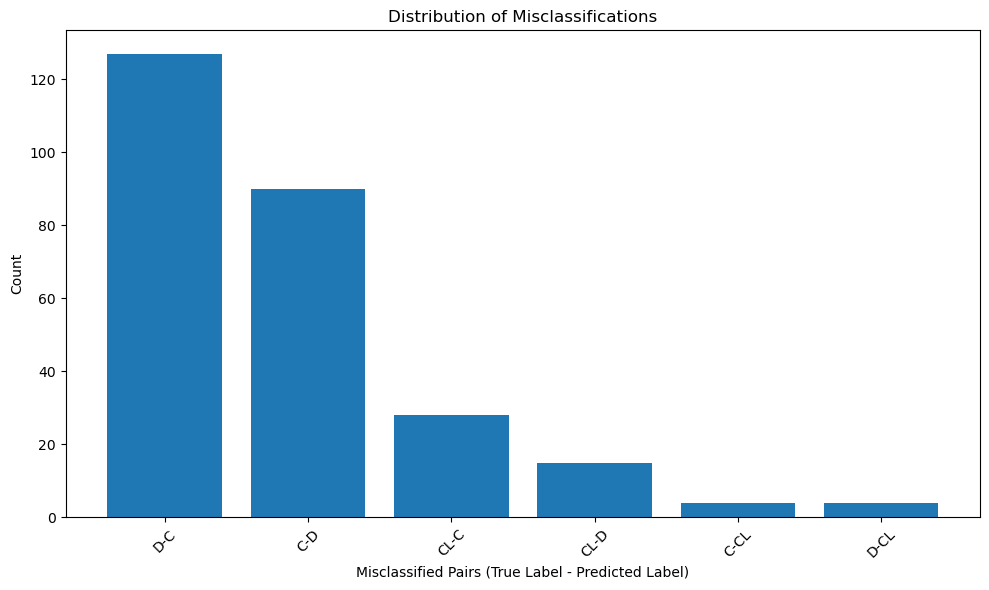

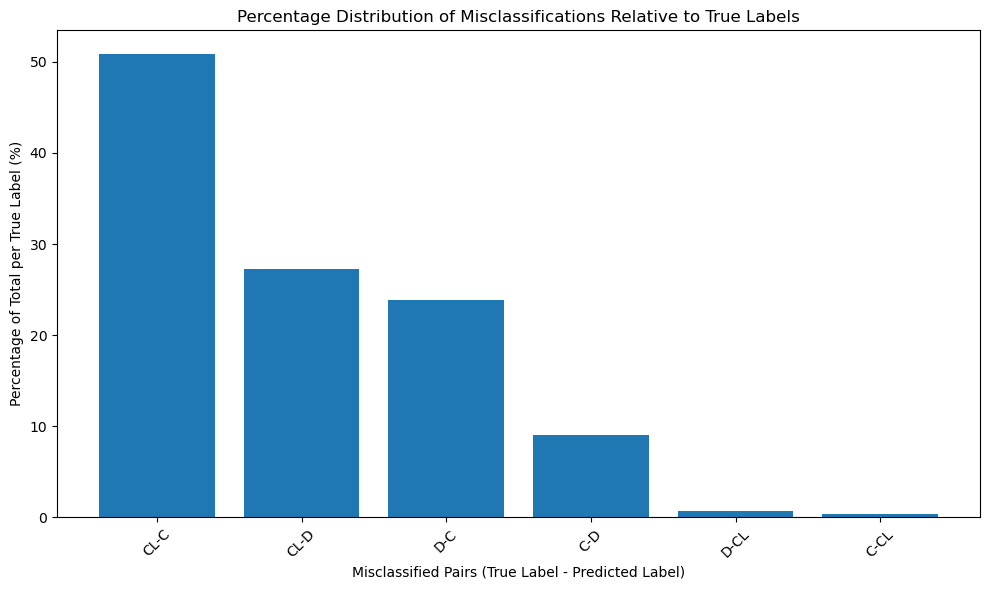

In [29]:
#! Misclassification report and plot
#! Also, re-scale to the minority class (CL) so I can see the % likelihood of misclassification
import matplotlib.pyplot as plt
import pandas as pd

#! Choose model
y_val_pred_model = y_val_pred_best_gb_weighted

# Calculate total instances per class
total_per_class = y_val.value_counts()

# Identify misclassified instances
misclassified = y_val != y_val_pred_model
misclassified_data = X_val_processed[misclassified]
misclassified_true_labels = y_val[misclassified]
misclassified_pred_labels = y_val_pred_model[misclassified]

# Summarize the misclassifications
misclassification_summary = pd.DataFrame({
    'True Label': misclassified_true_labels,
    'Predicted Label': misclassified_pred_labels
})

# Analyze distribution of misclassifications
misclassification_distribution = misclassification_summary.value_counts().reset_index(name='Count')

print(misclassification_distribution)

# Plot distribution of misclassifications
plt.figure(figsize=(10,6))
plt.bar(misclassification_distribution['True Label'].astype(str) + '-' + misclassification_distribution['Predicted Label'].astype(str), 
        misclassification_distribution['Count'])
plt.xlabel('Misclassified Pairs (True Label - Predicted Label)')
plt.ylabel('Count')
plt.title('Distribution of Misclassifications')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#! Re-scale to the minority class (CL) so I can see the % likelihood of misclassification
# Count misclassifications per true-predicted pair
misclassification_counts = misclassification_summary.value_counts().reset_index(name='Count')

# Calculate percentage of misclassifications for each true label
misclassification_counts['Total per True Label'] = misclassification_counts['True Label'].apply(lambda x: total_per_class[x])
misclassification_counts['Percentage'] = (misclassification_counts['Count'] / misclassification_counts['Total per True Label']) * 100

# Sorting for better visualization, particularly if focusing on minority classes
misclassification_counts_sorted = misclassification_counts.sort_values(by='Percentage', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(misclassification_counts_sorted['True Label'].astype(str) + '-' + misclassification_counts_sorted['Predicted Label'].astype(str), 
        misclassification_counts_sorted['Percentage'])
plt.xlabel('Misclassified Pairs (True Label - Predicted Label)')
plt.ylabel('Percentage of Total per True Label (%)')
plt.title('Percentage Distribution of Misclassifications Relative to True Labels')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### K-Fold Cross-Validation Score

#### #! TODO Implement k-fold cross-validation

In [30]:
# #! TODO k-fold cross-val score
# from sklearn.model_selection import cross_val_score

# # We'll use the best hyperparameters from the previous grid search or else placeholders
# # best_params = grid_search.best_params_ if 'grid_search' in locals() else {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}
# gb_model_cv = GradientBoostingClassifier(**best_params, random_state=42)

# # Perform 5-fold cross-validation and calculating the mean accuracy
# cv_accuracies = cross_val_score(gb_model_cv, X_train_scaled, y_train, cv=5, scoring='accuracy')

# # Calculate mean accuracy and standard deviation
# mean_cv_accuracy = cv_accuracies.mean()
# std_cv_accuracy = cv_accuracies.std()

# print(mean_cv_accuracy, std_cv_accuracy)

### #! TODO Evaluate model hyperparamter tuning results across all models
- #! TODO **Graphs of gains:** Ideally I'd want a graph showing gains due to hyperparameter tuning specifically, and similar graphs showing each gain due to each engineering step, and I'd like that for each model.
1. **Best Parameters:** Grid search provides a set of optimal hyperparameters, improving the model's ability to generalize and potentially enhancing its performance on the minority class CL.
    
2. **Model Evaluation:** Using these optimal parameters, the model's performance should improve in terms of precision, recall, and F1-score across all classes, especially for the CL class where we seek significant improvement.
    
3. **Model Comparison:** Compare this tuned model against previous versions to assess any improvements in handling the class imbalance.

## Neural Network Model

Plan: Construct a basic neural network model to compare its performance against the optimized Random Forest model. Design a network architecture suitable for this multi-class classification task, train it on the same dataset, and then evaluate its performance. Use a simple network architecture suitable for this multi-class {C,D,CL} classification task, train it on the same dataset, and then evaluate its performance. #! Need an automated evaluation suite for ease of comparison between models.

1. Define a neural network architecture with an input layer, a few hidden layers, and an output layer suitable for multi-class classification.
2. Compile the model, specify the loss function suitable for multi-class classification across {C,D,CL}, an optimizer, and metrics to monitor.
3. Train the model on the processed training data.
4. Evaluate the model's performance on the validation set.

Basic setup:
    
    Encode -> categorical
    Optimizer -> Adam
    Loss -> cross entropy for categorical
    Model -> basic relu and softmax off-the-shelf
    Metric -> accuracy

Possible improvements:
    
    Skew to reward CL performance metrics across Recall and F1-score

1. **Train the Neural Network:** Trained over a series of epochs, adjusting its weights to minimize the categorical crossentropy loss, which is a common choice for multi-class classification tasks.
    
2. **Evaluate:** Post-training, evaluate the model's accuracy on the validation set (overall classification performance), then check detailed metrics to assess precision, recall, and F1-score for each class, especially the minority CL class.
    
3. **Compare to other models:** Compare NN to the previously developed models (gradient boost and random forest) to determine if NN offers a significant advantage, particularly in handling the minority CL class.

**Preliminary results:** 
- NN performance varies each run.
- Sometimes a trained NN state fails to predict any CL cases, preferring to earn 0 score with respect to the minority class in exchange for better performance on the other classes.
- Necessary to include engineering features in the model to improve NN performance, e.g. ClassImbalance techniques, EarlyStopping, DropOut, etc.

In [31]:
# conda install tensorflow

In [32]:
import logging
logging.getLogger('absl').setLevel(logging.ERROR)

In [33]:
# Neural Network ("NN") model attempt
from tensorflow.keras.models import Sequential# Model
from tensorflow.keras.layers import Dense# Layer
from tensorflow.keras.optimizers import Adam# Optimizer
from tensorflow.keras.utils import to_categorical# https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical
from tensorflow.keras.metrics import CategoricalCrossentropy
from sklearn.preprocessing import LabelEncoder# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

# Encode the target variable "y" as categorical {0, 1, ..., n}, representing the classes {C, D, CL}
label_encoder = LabelEncoder()
y_train_encoded = to_categorical(label_encoder.fit_transform(y_train))
y_val_encoded = to_categorical(label_encoder.transform(y_val))

# Define the neural network architecture with Sequential model and Dense layers
nn_model = Sequential([
    Dense(64, input_shape=(X_train_processed.shape[1],), activation='relu'),
    Dense(64, activation='relu'),
    Dense(y_train_encoded.shape[1], activation='softmax')
])

# Compile the model https://keras.io/api/optimizers/
nn_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])# metrics is a useful indicative measure; the model objective is log_loss (i.e. categorical_crossentropy for 3x classes)

# # Train the model (with verbose reporting to help interpretability)
# history = nn_model.fit(X_train_processed, y_train_encoded, epochs=50, batch_size=32, validation_data=(X_val_processed, y_val_encoded), verbose=2)

# # Try bigger batch that covers the whole dataset (improves from ~78.1 accuracy to ~79.8 accuracy)
# history = nn_model.fit(X_train_processed, y_train_encoded, epochs=50, batch_size=len(X_train_processed), validation_data=(X_val_processed, y_val_encoded), verbose=0)

# Try 60x more epochs for longer training (reduces from ~79.8 to ~71.5 accuracy, but with improved CL performance)
history = nn_model.fit(X_train_processed, y_train_encoded, epochs=3000, batch_size=len(X_train_processed), validation_data=(X_val_processed, y_val_encoded), verbose=0)# verbose=2)

# Evaluate the model on the validation set
val_loss, val_accuracy = nn_model.evaluate(X_val_processed, y_val_encoded, verbose=0)

# Report the result (consider reformatting and print() etc for interpretability)
print('val_loss\n',val_loss,'\n\n', 'val_accuracy\n',val_accuracy)
# Only ~78.1% accuracy at epochs=50, falling to ~71.5% accuracy at epochs=3000
# # This performance seems is poor compared to Random Forest, so NN requires optimization with respect to architecture choice, or other parameters like size, or else give up because NN unlikely to work well on such small datasets.
# # But check whether performance on CL is good or improves with epoch count

#! Bring in the eval suite used for the other models
# Adapt the NN predicted classes (one-hot encoded) back into labelled format for the eval suite
# With respect to each of the three classes {C,D,CL}, evaluate precision, recall, f1-score
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# Predict the classes across the validation set from the processed data
y_val_pred = nn_model.predict(X_val_processed)
# Convert the predictions from one-hot encoding to label encoding
y_val_pred_labels = np.argmax(y_val_pred, axis=1)
y_val_true_labels = np.argmax(y_val_encoded, axis=1)

# Calculate accuracy and classification report, scoring predictions against the true validation set labels
accuracy_val_nn = accuracy_score(y_val_true_labels, y_val_pred_labels)
classification_report_val_nn = classification_report(y_val_true_labels, y_val_pred_labels)

# Output the performance metrics
print('val_loss\n',val_loss)#,'\n\n', 'val_accuracy\n',val_accuracy)
print('Neural Network Validation Accuracy:\n', accuracy_val_nn)
print('Neural Network Classification Report:\n', classification_report_val_nn)

# Sometimes a trained NN state fails to predict any CL cases, preferring to earn 0 score with respect to the minority class in exchange for better performance on the other classes
# Other times achieves ~76.6 accuracy

2024-04-08 15:46:26.032549: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


val_loss
 2.8186802864074707 

 val_accuracy
 0.7507906556129456
50/50 [==============================] - 0s 248us/step
val_loss
 2.8186802864074707
Neural Network Validation Accuracy:
 0.7507906388361796
Neural Network Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.81      0.82       993
           1       0.11      0.07      0.09        55
           2       0.66      0.72      0.69       533

    accuracy                           0.75      1581
   macro avg       0.53      0.53      0.53      1581
weighted avg       0.75      0.75      0.75      1581



Example results with fewer training epochs ~1000:

        50/50 [==============================] - 0s 252us/step
        Neural Network Validation Accuracy:
        0.7697659709044908
        Neural Network Classification Report:
                    precision    recall  f1-score   support

                0       0.83      0.84      0.83       993
                1       0.18      0.05      0.08        55
                2       0.68      0.72      0.70       533

        accuracy                            0.77      1581
        macro avg       0.56      0.54      0.54      1581
        weighted avg    0.76      0.77      0.76      1581

In [34]:
#! NN + Class Imbalance techniques to address class imbalance
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping# Early stopping to prevent overfitting. Overfitting can lead to overly confident incorrect predictions, which are heavily penalized in log loss.
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight# https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

# Encode target variables as categorical
label_encoder = LabelEncoder()
y_train_encoded = to_categorical(label_encoder.fit_transform(y_train))
y_train_smote_encoded = to_categorical(label_encoder.fit_transform(y_train_smote))
y_val_encoded = to_categorical(label_encoder.transform(y_val))

# Option to weight by class prevalence
# Calculate class weights `n_samples / (n_classes * np.bincount(y))`
class_weights = class_weight.compute_class_weight(class_weight='balanced',# If "balanced", class weights will be given by `n_samples / (n_classes * np.bincount(y))`
                                                 classes=np.unique(y_train),
                                                 y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Early stopping (report any early stopping explicitly)
early_stopping = EarlyStopping(monitor='val_loss', patience=500, restore_best_weights=True)

# Neural network architecture
# sigmoid or tanh activation to treat data more fairly, dropout to reduce overfitting
nn_model = Sequential([
    Dense(64, input_shape=(X_train_processed.shape[1],), activation='sigmoid'),
    Dropout(0.05),
    Dense(64, activation='sigmoid'),#'tanh'),
    Dropout(0.05),
    Dense(y_train_encoded.shape[1], activation='softmax')
])
# nn_model = Sequential([
#     Dense(64, input_shape=(X_train_processed.shape[1],), activation='relu'),
#     Dense(64, activation='relu'),
#     Dense(y_train_encoded.shape[1], activation='softmax')
# ])

# Compile the model https://keras.io/api/optimizers/
nn_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with SMOTE_data or with Processed_data+class_weight
history = nn_model.fit(
    # X_train_processed, y_train_encoded, 
    X_train_smote, y_train_smote_encoded,
    epochs=2000,# more epochs improve CL minority class performance at cost of lower overall accuracy and more training time
    # batch_size=len(X_train_processed),# entire training set as the batch size
    batch_size=len(X_train_smote),# smote set is bigger!
    validation_data=(X_val_processed, y_val_encoded),
    # class_weight=class_weights_dict,#
    verbose=0,# verbose=2 would report metrics each epoch
    callbacks=[early_stopping]# early stopping to limit overfitting
)
# history = nn_model.fit(X_train_processed, y_train_encoded, epochs=1000,#epochs=50
#                        batch_size=len(X_train_processed), 
#                        validation_data=(X_val_processed, y_val_encoded), 
#                        class_weight=class_weights_dict, verbose=0)

# Evaluate the model as before
val_loss, val_accuracy = nn_model.evaluate(X_val_processed, y_val_encoded, verbose=0)

# Prediction and performance evaluation
y_val_pred = nn_model.predict(X_val_processed)
# Convert the predictions from one-hot encoding to label encoding
y_val_pred_labels = np.argmax(y_val_pred, axis=1)
y_val_true_labels = np.argmax(y_val_encoded, axis=1)

# Calculate accuracy and classification report
accuracy_val_nn = accuracy_score(y_val_true_labels, y_val_pred_labels)
classification_report_val_nn = classification_report(y_val_true_labels, y_val_pred_labels)

# The number of epochs actually run is the length of the history.history['loss'] list
epochs_run = len(history.history['loss'])
print(f"Stopped after {epochs_run} epochs out of the maximum allowed 2000 epochs.")

# Output the performance metrics
print('val_loss\n',val_loss)#,'\n\n', 'val_accuracy\n',val_accuracy)
print('Neural Network Validation Accuracy:\n', accuracy_val_nn)
print('Neural Network Classification Report:\n', classification_report_val_nn)

#! Can plot history['loss']

50/50 [==============================] - 0s 255us/step
Stopped after 1741 epochs out of the maximum allowed 2000 epochs.
val_loss
 0.6575015783309937
Neural Network Validation Accuracy:
 0.7356103731815307
Neural Network Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.76      0.81       993
           1       0.10      0.27      0.15        55
           2       0.69      0.74      0.71       533

    accuracy                           0.74      1581
   macro avg       0.56      0.59      0.56      1581
weighted avg       0.79      0.74      0.76      1581



NN+Class_Weights results, example:

        Early stopping occurred after 389 epochs out of the maximum allowed 2000 epochs.
        val_loss
        0.6236494779586792
        Neural Network Validation Accuracy:
        0.7463630613535737
        Neural Network Classification Report:
                    precision    recall  f1-score   support

                0       0.88      0.78      0.83       993
                1       0.11      0.29      0.16        55
                2       0.70      0.73      0.71       533

            accuracy                           0.75      1581
        macro avg       0.56      0.60      0.57      1581
        weighted avg       0.79      0.75      0.77      1581

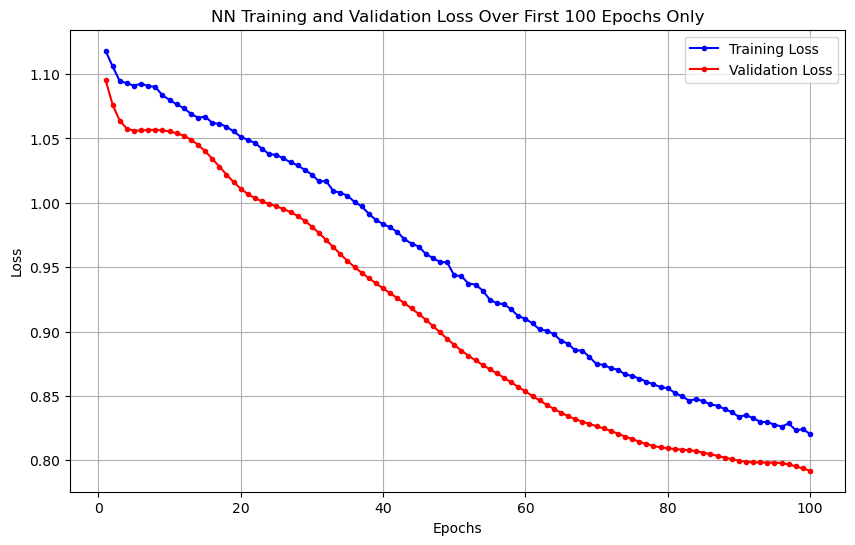

NN improving Validation Loss across Epochs = 100


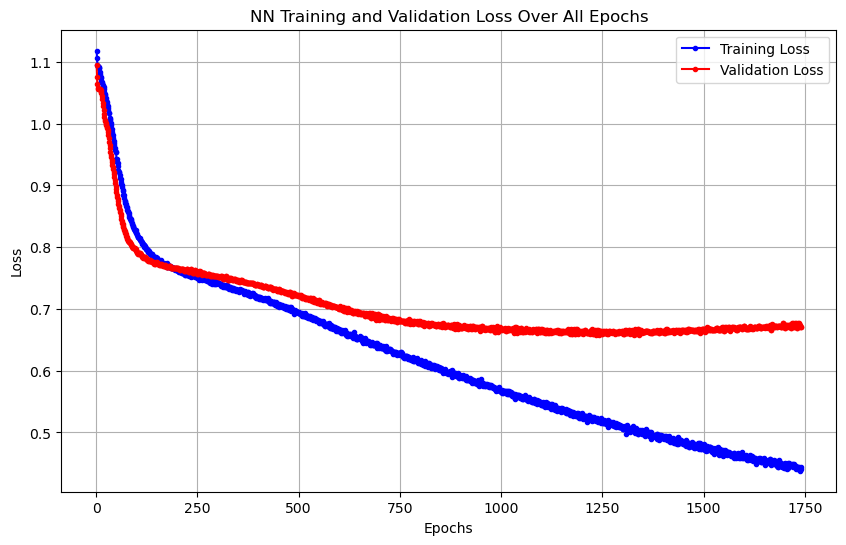

NN asymptotes with Validation Loss = 0.6575015783309937 across Epochs = 1741


In [35]:
# Plot the NN Loss curves
import matplotlib.pyplot as plt

# Extract the history of training loss and validation loss
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, epochs_run + 1)

# Plot the training and validation loss over the first 100 epochs
epochs_range = 100
plt.figure(figsize=(10, 6))
plt.plot(epochs[:epochs_range], training_loss[:epochs_range], 'bo-', markersize=3, label='Training Loss')  # Focus on first 100 epochs
plt.plot(epochs[:epochs_range], validation_loss[:epochs_range], 'ro-', markersize=3, label='Validation Loss')  # Focus on first 100 epochs
plt.title(f'NN Training and Validation Loss Over First {epochs_range} Epochs Only')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

print(f'NN improving Validation Loss across Epochs = {epochs_range}')

# Plot the training and validation loss over all epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'bo-', markersize=3, label='Training Loss')  # Smaller markers
plt.plot(epochs, validation_loss, 'ro-', markersize=3, label='Validation Loss')  # Smaller markers
plt.title('NN Training and Validation Loss Over All Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

print(f'NN asymptotes with Validation Loss = {val_loss} across Epochs = {epochs_run}')

#### #! TODO Move NN to main Models section.
1. Optimize NN.
2. Try GridSearch.
3. Then try K-Fold Cross Validation for all models (RF, GB, NN, )

##### #! TODO **Meta Evaluation:** Ideally want a meta eval suite to cross compare across models and show whether engineering improvements actually improve performance, and if so then by how much and at what cost.

### Next steps

1. **Feature Importance Analysis:** Analyze which features are important for predicting class. Use the Random Forest model to identify key predictors of liver cirrhosis outcomes. Identify and visualize the most influential features (i.e. the best discriminative predictors of one class versus another). This informs our use-case by allowing us to recommend that clinicians gather data for these features in future and use our model to predict cirrhosis outcomes.
    
2. **Further Data Exploration:** Maybe additional insight or potential data transformations that could enhance model performance if we revisit the data exploration phase.
    
3. **Model Refinement:** Based on the feature importance analysis and any additional insights from further data exploration, we can refine our models. This might involve feature engineering, further hyperparameter tuning, or exploring different modeling approaches.
    
4. **Project Report and documenting our work:** Summarizing the findings, methodologies, and recommendations for future work for our group project's final report.

## Feature importance analysis

From this feature importance analysis, we can recommend which real world data features are most important for clinicians to gather for use with our model.

**Interpret Feature Importance:** Use feature importance results to interpret the impact of different features on the model's predictions. In other cases this could guide clinical understanding, although cirrhosis is already well understood. In our use case, feature importance guides future data collection priorities for use with the model.
    
**Further Data Exploration:** Based on the feature importance, we can revisit the data to explore these key features further, looking for patterns, outliers, or data quality issues that could inform further modeling or data cleaning steps.
    
**Model Refinement:** Could try excluding less important features, creating new features (feature engineering), or adjusting model parameters with a focus on the key features.


In [36]:
# Identify and visualize the most influential features (i.e. the best discriminative predictors of one class versus another)
import matplotlib.pyplot as plt

# Extract feature importances from the model
def get_feature_importances(model,model_name):
    # Choose model (maybe RF but not the weighted version to keep it general)
    feature_importances = model.feature_importances_

    # # Or choose the tuned models
    # feature_importances = best_rf_model_weighted.feature_importances_
    # feature_importances = best_gb_model_smote.feature_importances_

    # Create a new DataFrame for visualization
    features_df = pd.DataFrame({
        'Feature': X_train_processed_df.columns,
        'Importance': feature_importances
    })

    # Sort the features by importance
    features_df = features_df.sort_values(by='Importance', ascending=False)

    # Plot the feature importances
    num_features = 15
    plt.figure(figsize=(10, 6))
    plt.barh(features_df['Feature'][:num_features], features_df['Importance'][:num_features], align='center')
    plt.gca().invert_yaxis()# Invert y-axis (puts most important features at the top)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Top {num_features} Important Features Predicting Liver Cirrhosis Outcomes \n(Model: {model_name} with GridSearch Optimization)')
    plt.show()
    print(features_df.head())
    return 

#! TODO write code to re-write the feature name labels nicely

Feature importance for: best_gb_model_weighted


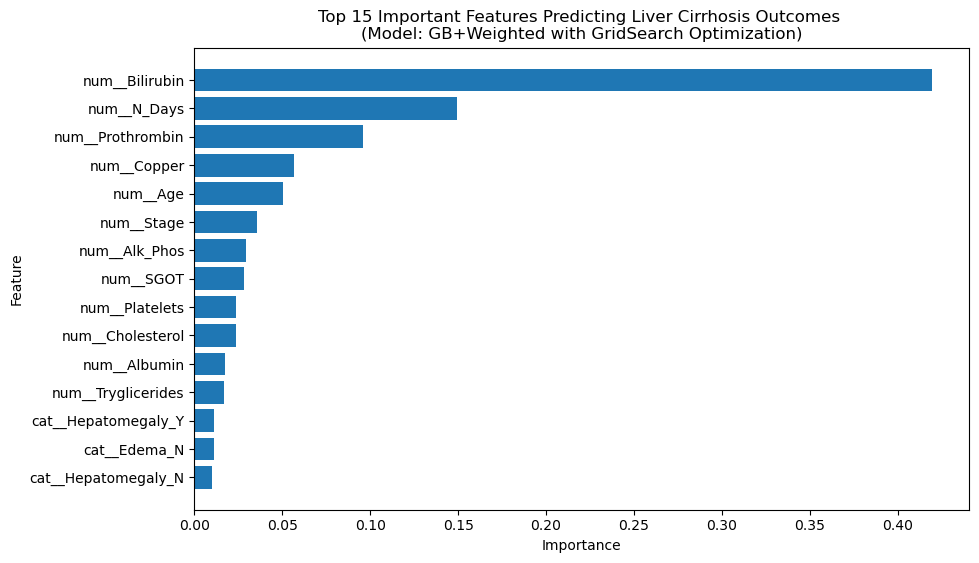

            Feature  Importance
3    num__Bilirubin    0.419746
6       num__N_Days    0.149315
8  num__Prothrombin    0.095932
5       num__Copper    0.056390
0          num__Age    0.050448

Now for the next model

Feature importance for: best_rf_model_smote


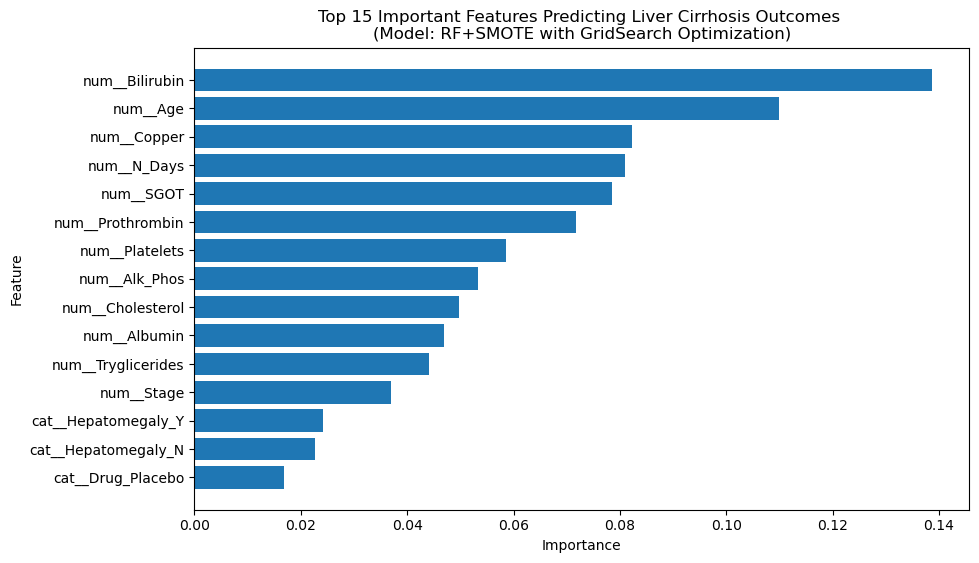

          Feature  Importance
3  num__Bilirubin    0.138770
0        num__Age    0.109870
5     num__Copper    0.082205
6     num__N_Days    0.081002
9       num__SGOT    0.078543


In [37]:
print('Feature importance for: best_gb_model_weighted')
get_feature_importances(best_gb_model_weighted, 'GB+Weighted')
print('\nNow for the next model\n')
print('Feature importance for: best_rf_model_smote')
get_feature_importances(best_rf_model_smote, 'RF+SMOTE')

This is for the general case of predicting across C,D,CL, but down-ranks the best predictors of the minority CL class because those features provide little signal to discriminate between the majority of cases C and D.

The overall top features are ranked by their importance scores: 1st `Bilirubin` and 2nd `N_Days`, then 3rd `Copper` and 4th `Prothrombin`. Indeed, these might have been expected to be significant predictors of class C,D,CL given their medical relevance to liver function and disease progression.    

## Model review (ROC Curves and Confusion Matrices)


1.  **Confusion Matrix for Model Evaluation:** Confusion matrices for models to get a more detailed view of their performance, especially regarding the minority class CL.

        Use these confusion matrices to analyze the true positives, false positives, true negatives, and false negatives for each class.
2.  **ROC Curve Analysis:** Compare the models using ROC curves and AUC scores, which evaluate performance in imbalanced classification tasks.
        
        ROC and AUC Analysis: Generate and compare the ROC curves and AUC scores for each model. The ROC curve provides a comprehensive view of the trade-off between the true positive rate and false positive rate at various thresholds, while the AUC score gives a single metric summarizing this performance across all thresholds.
3.  **Precision-Recall Curves:** Given the class imbalance, precision-recall curves will highlight the balance between precision and recall for each class. These curves show the trade-off between precision (positive predictive value) and recall (sensitivity) for different thresholds, which is particularly relevant when the costs of false positives and false negatives are high or differ significantly.

4.  **Model Comparison and Selection:** Use these analyses to compare the models more rigorously. This comparison should inform a judgement as to which model performs best overall and particularly how well each model manages to predict the minority class CL, which is crucial in our use-case of predicting liver cirrhosis outcomes and targetting transplants.

#### Confusion matrices

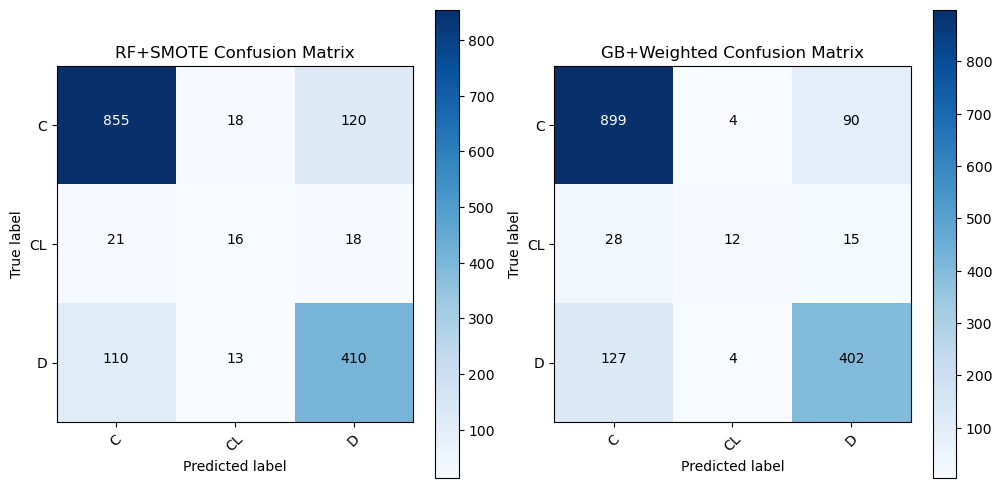

In [54]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Confusion matrices for both models
cm_gb = confusion_matrix(y_val, y_val_pred_best_gb_weighted)
cm_rf = confusion_matrix(y_val, y_val_pred_rf_smote)

# Plot confusion matrices
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 2)
plot_confusion_matrix(cm_gb, classes=label_encoder.classes_, title='GB+Weighted Confusion Matrix')

plt.subplot(1, 2, 1)
plot_confusion_matrix(cm_rf, classes=label_encoder.classes_, title='RF+SMOTE Confusion Matrix')

plt.show()

Use these confusion matrices to analyze the true positives, false positives, true negatives, and false negatives for each class.

### Plots of ROC and Precision-Recall Curves

#### Plots: ROC Curves (RF+SMOTE and GB+WeightAdjustment)

In [40]:
# Predict probabilities for each class
y_val_pred_probs_best_rf_model_smote = best_rf_model_smote.predict_proba(X_val_processed)
y_val_pred_probs_best_gb_model_weighted = best_gb_model_weighted.predict_proba(X_val_processed)

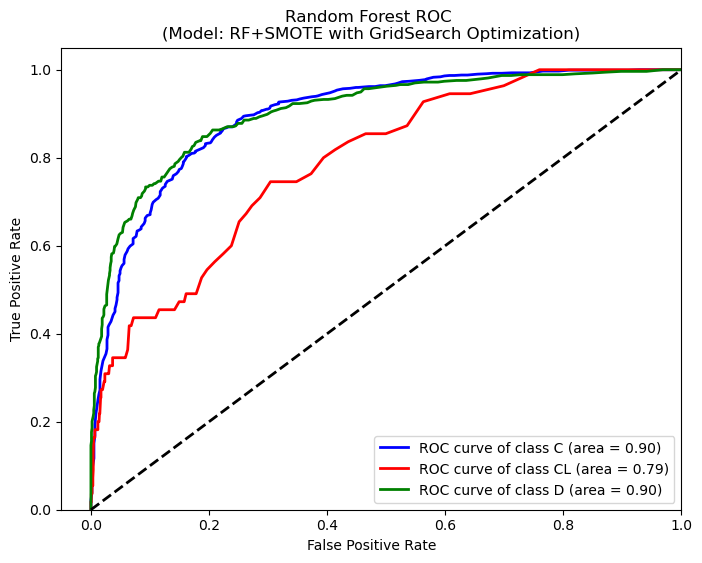

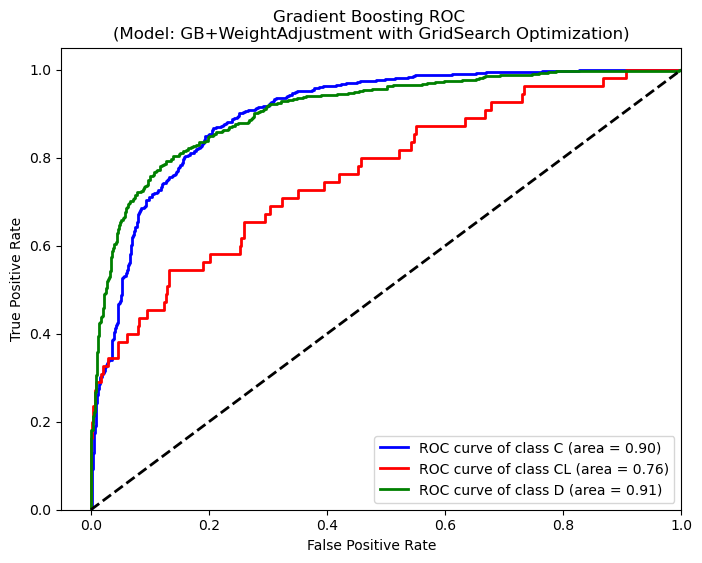

In [41]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, roc_curve
import matplotlib.pyplot as plt

# Function to plot ROC Curve for each class
def plot_multiclass_roc(y_true, y_pred, classes, title):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(8, 6))
    colors = ['blue', 'red', 'green']
    for i, color in zip(range(len(classes)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Plot ROC Curve for Random Forest
plot_multiclass_roc(y_val_encoded, y_val_pred_probs_best_rf_model_smote, label_encoder.classes_, 
                    'Random Forest ROC \n(Model: RF+SMOTE with GridSearch Optimization)')

# Plot ROC Curve for Gradient Boosting
plot_multiclass_roc(y_val_encoded, y_val_pred_probs_best_gb_model_weighted, label_encoder.classes_, 
                    'Gradient Boosting ROC \n(Model: GB+WeightAdjustment with GridSearch Optimization)')

#### Plots: Precision-Recall Curves (RF+SMOTE and GB+WeightAdjustment)

- Precision-Recall Curves now, to identify positive instances of each class, which is critical given the class imbalance in our dataset. Can analyze these curves to determine which model is more effective at identifying the minority class while maintaining a reasonable level of precision overall. 

- They're all pretty bad at CL, as expected for a minority class and such little data.

- [#! WRONG][#!TODO CHECK what Recall means] Intuitively, should consider an integral with respect to the diagonal as axis, and GB+Weighted indicates {?GUESS? Recall for ~25% CL patients can be done to good Precision before the rest of the patients in that Class are misclassified, so correctly predict a ~quarter of true CL patients but most CL classifications actually made are false positives on true C or true D patients.}

**Example - Suppose our clinical use-case is to predict which patient should receive scarce liver transplants:**
- We have 10 livers to allocate among 3000 patients. At ~3% CL prevalence, around 100 patients would survive with a transplant, whereas  Now we must use our model to predict which patients GB+Weighted can catch 20% of actual CL patients 

##### Precision-Recall Curve Interpretation
- **Precision (Positive Predictive Value):** Ratio of True Positives Predicitions to All Positive Predictions (i.e. True+False). For CL minority class, high precision means that when the model predicts the minority class, it is correct a high percentage of the time. Precision is crucial when the cost of a false positive is high, as in our clinical use-case where we might waste a scarce liver transplant on a patient who would live anyway or die anyway.
- **Recall (Sensitivity or True Positive Rate):** Fraction of True Positive Predictions to All Actual Positives. High recall for CL minority class means the model successfully identifies a high percentage of all actual cases of that class. Recall is particularly important when it's crucial not to miss any instances of the minority class, even if it means tolerating more false positives elsewhere.
- Precision-recall curves show the trade-off between precision and recall for different thresholds. A high area under the curve (`AUC`) indicates that the classifier can achieve high precision without sacrificing recall and vice versa, which is particularly desirable for imbalanced class distributions where the minority class is of significant interest, as in our clinical use-case.

In [42]:
#! TODO Implement a similar function for plotting Precision-Recall curves using `precision_recall_curve` from `sklearn.metrics`

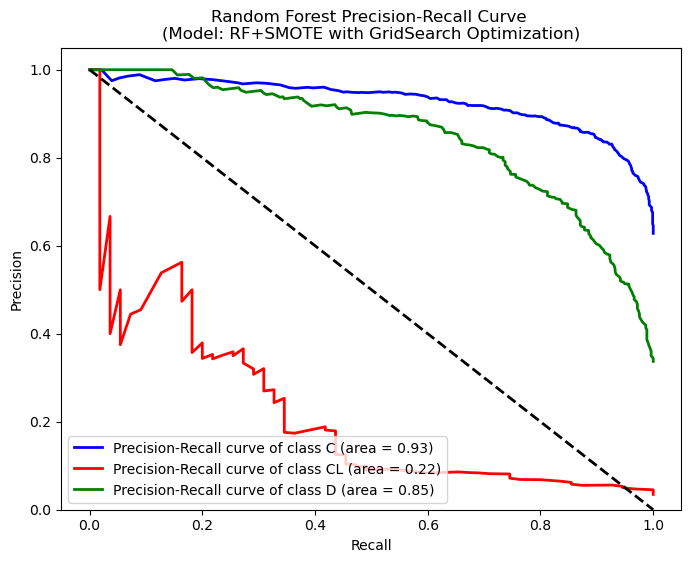

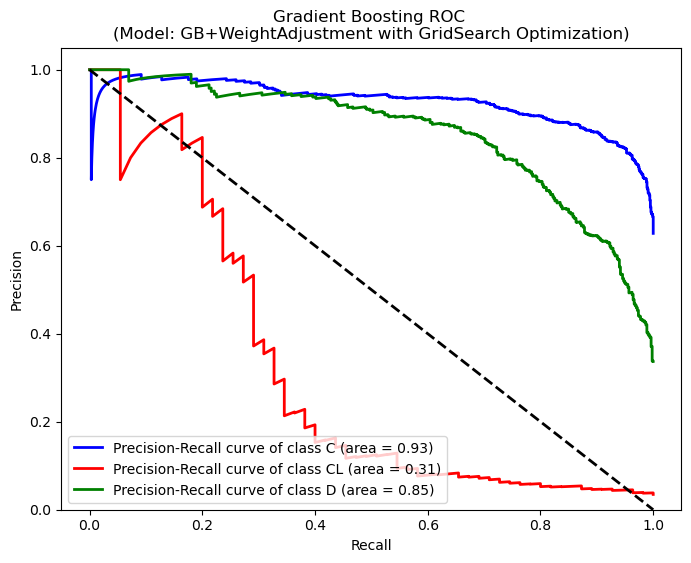

In [43]:
#! TODO update to best gb and rf [DONE]
# Precision-Recall Curves for RF and GB
from sklearn.metrics import precision_recall_curve, average_precision_score

# Function to plot Precision-Recall Curve for each class
def plot_precision_recall_curve(y_true, y_pred, classes, title):
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(len(classes)):
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
        average_precision[i] = average_precision_score(y_true[:, i], y_pred[:, i])

    # Plot all Precision-Recall curves
    plt.figure(figsize=(8, 6))
    colors = ['blue', 'red', 'green']
    for i, color in zip(range(len(classes)), colors):
        plt.plot(recall[i], precision[i], color=color, lw=2,
                 label=f'Precision-Recall curve of class {classes[i]} (area = {average_precision[i]:0.2f})')

    plt.plot([0, 1], [1, 0], 'k--', lw=2)
    plt.xlim([-0.05, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc="lower left")
    plt.show()

# Plot Precision-Recall Curve for Random Forest
plot_precision_recall_curve(y_val_encoded, y_val_pred_probs_best_rf_model_smote, label_encoder.classes_, 
                            'Random Forest Precision-Recall Curve \n(Model: RF+SMOTE with GridSearch Optimization)')

# Plot Precision-Recall Curve for Gradient Boosting
plot_precision_recall_curve(y_val_encoded, y_val_pred_probs_best_gb_model_weighted, label_encoder.classes_, 
                            'Gradient Boosting ROC \n(Model: GB+WeightAdjustment with GridSearch Optimization)')

##### Precision-Recall Curve Interpretation

#! TODO precision recall curve interpretations

## Test performance on `test.csv` and Kaggle

Task: Predict classes for each entry in the `test.csv` dataset using my trained models.

- Process the Test Data: Process the test.csv file. Apply the same preprocessing steps to test.csv as we did to our training data. This includes scaling and encoding the features but excluding the target variable processing, as that's not present in the test set.
- Predict Class Probabilities: Use the trained model to predict the probabilities of each class for each entry in the test set.
- Create Submission DataFrame: Construct a DataFrame that matches the sample_submission.csv format, with the ID and the predicted probabilities for each class.
- Save Predictions: Format the predictions as per sample_submission.csv and export them to a new CSV file.
        

### Models dictionary
#! add more models to dictionary

In [44]:
# Models dictionary
#! Add more models here
# Dictionary with model names as keys and model objects as values
models_dict = {
    'gb_classifier': gb_classifier,
    'gb_classifier_smote': best_gb_model_smote,
    'gb_classifier_weighted': best_gb_model_weighted,
    'rf_classifier': rf_classifier,
    'rf_classifier_smote': rf_classifier_smote,
    'rf_classifier_weighted': rf_classifier_weighted,
    'nn_classifier': nn_model# Doesn't work directly on same dataformat as other models
}

In [45]:
# Function to find a key (model name) by its value (model object)
def get_key_by_value(value_to_find, dictionary):
    for key, value in dictionary.items():
        if value is value_to_find:
            # print(model_name_and_version)
            return key
    return None

# # Can select a model and retain its name
# def test_predict_model_choice(model):
#     # selected_model_key = 'gb_classifier' # Naming could be set to be dynamic or based on some criteria
#     # test_predict_model = models_dict[selected_model_key]
#     # model_name_and_version = selected_model_key
#     test_predict_model = model
#     model_name_and_version = get_key_by_value(test_predict_model, models_dict)
#     return test_predict_model, model_name_and_version#, selected_model_key

# # # Usage
# # test_predict_model, model_name_and_version = test_predict_model_choice(rf_classifier_smote) # Argument is model object you want to test
# # model_name_and_version 
# # # Now model_name_and_version should be 'gb_classifier_scaled' if test_predict_model is gb_classifier_scaled object

### Convert `test.csv` to same format as model input data

#### Inspect `sample_submission.csv` format

In [46]:
import pandas as pd
# Load the sample submission file to inspect its format
sample_submission_path = 'sample_submission.csv'
sample_submission = pd.read_csv(sample_submission_path)
print(sample_submission.head())
print(sample_submission.info())

     id  Status_C  Status_CL  Status_D
0  7905  0.628084   0.034788  0.337128
1  7906  0.628084   0.034788  0.337128
2  7907  0.628084   0.034788  0.337128
3  7908  0.628084   0.034788  0.337128
4  7909  0.628084   0.034788  0.337128
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5271 entries, 0 to 5270
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         5271 non-null   int64  
 1   Status_C   5271 non-null   float64
 2   Status_CL  5271 non-null   float64
 3   Status_D   5271 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 164.8 KB
None


Format of sample_submission.csv indicates that the submission expects the ID of each entry along with the predicted probabilities for each class (Status_C, Status_CL, and Status_D).

#### Process `test.csv` data

In [47]:
# Load the test data
test_data_path = 'test.csv'
df_test = pd.read_csv(test_data_path)

# Process the test data
# 'id' is the first column and should be retained for the submission
test_ids = df_test['id']
X_test = df_test.drop('id', axis=1)

# Apply the same preprocessing to the test data
X_test_processed = preprocessor.transform(X_test)

# Verify the transformation (not displayed, just for sanity check)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=preprocessor.get_feature_names_out())
X_test_processed_df.head()

,num__Age,num__Albumin,num__Alk_Phos,num__Bilirubin,num__Cholesterol,num__Copper,num__N_Days,num__Platelets,num__Prothrombin,num__SGOT,...,cat__Sex_M,cat__Ascites_N,cat__Ascites_Y,cat__Hepatomegaly_N,cat__Hepatomegaly_Y,cat__Spiders_N,cat__Spiders_Y,cat__Edema_N,cat__Edema_S,cat__Edema_Y
0,0.374796,-0.518771,-0.088630,-0.363921,1.009653,-0.246184,1.639402,1.895139,-0.032411,0.785097,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1,-0.908242,1.960230,-0.291133,-0.390636,1.597410,0.136161,0.392829,-0.444861,-0.801507,0.785097,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,-1.401572,-1.714525,-0.449289,-0.150199,-1.026873,-0.496686,-1.804813,-0.606241,3.043975,-0.930728,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,0.587150,0.881135,-0.666754,-0.524212,-0.294755,-0.575792,0.267353,0.050804,-0.032411,0.234738,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.963767,-1.685360,-0.369677,-0.310491,-0.377247,0.492137,-0.382756,-0.514024,-1.057872,0.223251,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


#### Predict class probabilities for `test.csv` and export to `.csv`

In [48]:
# Choose a model and predict class probabilities using the processed test data
def test_predict_proba(model, X_test_processed):
    predicted_probabilities = model.predict_proba(X_test_processed)

    # Create the submission DataFrame
    submission_df = pd.DataFrame({
        'id': test_ids,
        'Status_C': predicted_probabilities[:, 0],
        'Status_CL': predicted_probabilities[:, 1],
        'Status_D': predicted_probabilities[:, 2]
    })
    
    return submission_df, predicted_probabilities

#### Save predictions to `.csv`

In [49]:
# # Save submission DataFrame to a .csv file
# submission_file_path = 'my_submission.csv'
# submission_df.to_csv(submission_file_path, index=False)

from datetime import datetime
import os

# Define the folder name where you want to save the file
folder_name = 'predictions'
# Construct the folder path relative to the current working directory
folder_path = os.path.join(os.getcwd(), folder_name)
# Ensure the folder exists, create it if it does not
os.makedirs(folder_path, exist_ok=True)

def save_test_predictions(submission_df, model_name_and_version):
    # Get current date and time in the format 'YYYYMMDD_HHMMSS'
    current_time = datetime.now().strftime('%Y%m%d_%H%M%S')

    # Format file name with the path
    submission_file_name = f"test_predictions_{current_time}_{model_name_and_version}.csv"
    submission_file_path = os.path.join(folder_path, submission_file_name)

    # Save submission DataFrame to the formatted file name
    submission_df.to_csv(submission_file_path, index=False)
    
    # Print the path (for reference)
    return print(f"Predicted class probabilities for: {model_name_and_version}",'\n',f"File saved to: {submission_file_path}")

In [50]:
# Choose a model and predict class probabilities using the processed test data
test_predict_model = rf_classifier_smote

# test_predict_model, model_name_and_version = test_predict_model_choice(gb_classifier)
model_name_and_version = get_key_by_value(test_predict_model, models_dict)
submission_df, predicted_probabilities = test_predict_proba(test_predict_model, X_test_processed)# X_test_processed may be exchanged for X_test_scaled in case of gb_classifier_scaled
save_test_predictions(submission_df, model_name_and_version)

Predicted class probabilities for: rf_classifier_smote 
 File saved to: /Users/user/Documents/_work/coursework/id5059/p2/Coursework-2/data/predictions/test_predictions_20240408_155318_rf_classifier_smote.csv


##### All-in-on-cell test predictor and saver

In [51]:
#! Choose a model and predict class probabilities using the processed test data
test_predict_model = best_gb_model_smote
# Remember to exchange X_test_processed for e.g. X_test_scaled in case of gb_classifier_scaled

# # Models dictionary
# #! Add more models here
# # Dictionary with model names as keys and model objects as values
# models_dict = {
#  'gb_classifier_weighted': gb_classifier,
#  'gb_classifier_smote': gb_classifier,
#  'rf_classifier': rf_classifier,
#  'rf_classifier_smote': rf_classifier_smote,
#  'rf_classifier_weighted': rf_classifier_weighted,
#  'nn_classifier': nn_model
# }

# Function to find a key (model name) by its value (model object)
def get_key_by_value(value_to_find, dictionary):
 for key, value in dictionary.items():
  if value is value_to_find:
   # print(model_name_and_version)
   return key
 return None

#! Pre-processing train.csv
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
# Identify categorical and numerical features
categorical_features = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
numerical_features = X_train.columns.difference(categorical_features + ['id']) # Exclude 'id' from features
# Create a column transformer to apply different preprocessing to categorical and numerical features
preprocessor = ColumnTransformer(
 transformers=[
 ('num', StandardScaler(), numerical_features),
 ('cat', OneHotEncoder(), categorical_features)
 ])
# Fit a preprocessor to the training data, and Transform training set too
X_train_processed = preprocessor.fit_transform(X_train)
# Transform validation set (but do not fit the validation set!)
X_val_processed = preprocessor.transform(X_val)
# # Convert processed data back to DataFrame for better readability (optional step)
# X_train_processed_df = pd.DataFrame(X_train_processed, columns = preprocessor.get_feature_names_out())
# X_val_processed_df = pd.DataFrame(X_val_processed, columns = preprocessor.get_feature_names_out())

# Scaling for GB
from sklearn.preprocessing import StandardScaler# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.metrics import accuracy_score
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_processed)
X_val_scaled = scaler.transform(X_val_processed)
# # Convert processed data back to DataFrame for better readability (optional step)
# X_train_processed_df = pd.DataFrame(X_train_processed, columns = preprocessor.get_feature_names_out())
# X_val_scaled_df = pd.DataFrame(X_val_scaled, columns = preprocessor.get_feature_names_out())

# Load the test data
test_data_path = 'test.csv'
df_test = pd.read_csv(test_data_path)
# Process the test data
# 'id' is the first column and should be retained for the submission
test_ids = df_test['id']
X_test = df_test.drop('id', axis=1)
# Apply the same preprocessing to the test data
X_test_processed = preprocessor.transform(X_test)
# Verify the transformation (not displayed, just for sanity check)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=preprocessor.get_feature_names_out())
X_test_processed_df.head()

# Choose a model and predict class probabilities using the processed test data
def test_predict_proba(model, X_test_processed):
 predicted_probabilities = model.predict_proba(X_test_processed)# X_test_processed may be exchanged for X_test_scaled in case of gb_classifier_scaled
 # Create the submission DataFrame
 submission_df = pd.DataFrame({
 'id': test_ids,
 'Status_C': predicted_probabilities[:, 0],
 'Status_CL': predicted_probabilities[:, 1],
 'Status_D': predicted_probabilities[:, 2]
 })
 
 return submission_df, predicted_probabilities

# # Save submission DataFrame to a .csv file
# submission_file_path = 'my_submission.csv'
# submission_df.to_csv(submission_file_path, index=False)
from datetime import datetime
import os
# Define the folder name where you want to save the file
folder_name = 'predictions'
# Construct the folder path relative to the current working directory
folder_path = os.path.join(os.getcwd(), folder_name)
# Ensure the folder exists, create it if it does not
os.makedirs(folder_path, exist_ok=True)
def save_test_predictions(submission_df, model_name_and_version):
 # Get current date and time in the format 'YYYYMMDD_HHMMSS'
 current_time = datetime.now().strftime('%Y%m%d_%H%M%S')
 # Format file name with the path
 submission_file_name = f"test_predictions_{current_time}_{model_name_and_version}.csv"
 submission_file_path = os.path.join(folder_path, submission_file_name)
 # Save submission DataFrame to the formatted file name
 submission_df.to_csv(submission_file_path, index=False)
 
 # Print the path (for reference)
 return print(f"Predicted class probabilities for: {model_name_and_version}",'\n',f"File saved to: {submission_file_path}")

# test_predict_model, model_name_and_version = test_predict_model_choice(gb_classifier)
model_name_and_version = get_key_by_value(test_predict_model, models_dict)
submission_df, predicted_probabilities = test_predict_proba(test_predict_model, X_test_processed)
save_test_predictions(submission_df, model_name_and_version)


Predicted class probabilities for: gb_classifier_smote 
 File saved to: /Users/user/Documents/_work/coursework/id5059/p2/Coursework-2/data/predictions/test_predictions_20240408_155318_gb_classifier_smote.csv


## GroupCode - ImportedFromGroup:

#### Pamela's XGBoost model and Pipeline with K-Fold Cross-Validation Scoring

##### Pamela's Pipeline


In [52]:
##### Pamela's Pipeline
# imports
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# load data
df = pd.read_csv("train.csv")
# df.head()
# df.info()

# create train and validation sets that maintain the distribution of classes
train, validation = train_test_split(df, stratify=df["Status"], test_size=0.2)
# X_train = train
# X_val = validation

# manually declare feature types ahead of preprocessing
numeric_values = ["N_Days","Age","Bilirubin","Cholesterol","Albumin","Copper","Alk_Phos","SGOT","Tryglicerides","Platelets","Prothrombin","Stage"]
categorical_values = ["Drug","Sex","Ascites","Hepatomegaly","Spiders","Edema"]
categorical_bin_values = ["Drug","Sex","Ascites","Hepatomegaly","Spiders"]
categorical_oh_values = ["Edema"]
features_to_scale = ["N_Days","Age","Bilirubin","Cholesterol","Albumin","Copper","Alk_Phos","SGOT","Tryglicerides","Platelets","Prothrombin","Stage"]


# pipeline (Pamela)
# numeric pipeline
num_pipeline = Pipeline([('func_transformer', FunctionTransformer(np.log1p)), 
                         ('minmax_scaler', MinMaxScaler()), ])
# categoric pipeline
class BinaryEncoder (BaseEstimator, TransformerMixin):
    def __init__ (self, features):
        self.features = features
    def fit(self, X, y=None): 
        return self # do nothing
    def transform(self, X):
        for c in self.features:
            values = X[c].unique()
            X[c].replace(values,(0,1), inplace=True)
        return X
# full pipeline (numeric & categorical)
full_pipeline = ColumnTransformer([ ("num", num_pipeline, numeric_values), 
                                   ("bin_cat", BinaryEncoder(categorical_bin_values), categorical_bin_values), 
                                   ("cat", OneHotEncoder(sparse_output=False), categorical_oh_values), ]) 
train_prepared = full_pipeline.fit_transform(train)

#! transform with pipeline
train_prepared = full_pipeline.fit_transform(train)


# Label Encoding
label_encoder = LabelEncoder()
labels_en = label_encoder.fit_transform(train["Status"])
# k-fold (e.g. 5) validation, with log loss, scores need to be un-negated back
# scores = cross_val_score(model, train_prepared, labels_en, scoring="neg_log_loss", cv=5)


# SMOTE (James)
# Initialize SMOTE
smote = SMOTE(random_state=42)
# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(train_prepared, train["Status"])

/var/folders/zj/pk512w796yn7r7cwb6n9lf840000gn/T/ipykernel_25330/4189629624.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[c].replace(values,(0,1), inplace=True)
/var/folders/zj/pk512w796yn7r7cwb6n9lf840000gn/T/ipykernel_25330/4189629624.py:47: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X

##### Pamela's XGBoost model, K-Fold Cross-Validation Scoring, GridSearch Hyperparameter Tuning, Classification Report, Test Predictions

In [53]:
#### Pamela's XGBoost model upon her Pipeline

# Train XGBoost Model
from xgboost import XGBClassifier
    # Label Encoding
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
labels_en = label_encoder.fit_transform(y_train_smote)
model_xgb = XGBClassifier(random_state=42).fit(X_train_smote, labels_en)

# Cross Validation
from sklearn.model_selection import KFold, cross_val_score
xgb_scores = cross_val_score(model_xgb, X_train_smote, labels_en, scoring="neg_log_loss", cv=5)
print(-xgb_scores)
print(-xgb_scores.mean())

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
# Declare a parameter grid for GridSearch
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3,5,7],
    'subsample': [0.6, 0.8]
}
# GridSearchCV on RF+SMOTE classifier model (with SMOTE)
grid_search = GridSearchCV(XGBClassifier(random_state=42), param_grid, cv=5, scoring='precision', return_train_score=True)
grid_search.fit(X_train_smote, labels_en)
# Save best model from grid search
best_xgb = grid_search.best_estimator_
xgb_scores_final = cross_val_score(best_xgb, X_train_smote, labels_en, scoring="neg_log_loss", cv=5)
print(-xgb_scores_final)
print(-xgb_scores_final.mean())

# Load test dataset
test = pd.read_csv("data/test.csv")
test_prepared = full_pipeline.fit_transform(test)
# Simple predict on the test set with the best model
y_pred_best_xgb = best_xgb.predict(test_prepared)
y_pred_de = label_encoder.inverse_transform(y_pred_best_xgb)
# report performance stats
accuracy_pred_best_xgb_smote = accuracy_score(y_val, y_pred_best_xgb)
classification_report_pred_best_xgb_smote = classification_report(y_val, y_pred_best_xgb)
print('accuracy_pred_best_xgb_smote:\n',accuracy_pred_best_xgb_smote,'\n\n','classification_report_pred_best_xgb_smote:\n', classification_report_pred_best_xgb_smote)

# Full predict on test set and save results
########## Taken from id5059_p2_240404_2.ipynb
# Choose a model and predict class probabilities using the processed test data
def test_predict_proba(model, X_test_processed):
    predicted_probabilities = model.predict_proba(X_test_processed)
    # Create the submission DataFrame
    submission_df = pd.DataFrame({
        'id': test["id"],
        'Status_C': predicted_probabilities[:, 0],
        'Status_CL': predicted_probabilities[:, 1],
        'Status_D': predicted_probabilities[:, 2]
    })
    return submission_df, predicted_probabilities

def save_test_predictions(submission_df):
    # Format file name with the path
    submission_file_name = "xgb_pred.csv"
    submission_df = pd.DataFrame(submission_df)
    # Save submission DataFrame to the formatted file name
    submission_df.to_csv(submission_file_name, index=False)
    # Print the path (for reference)
    return# print(f"Predicted class probabilities for: {model_name_and_version}",'\n',f"File saved to: {submission_file_path}")

final_output_df, predicted_probabilities = test_predict_proba(best_xgb, test_prepared)
save_test_predictions(final_output_df)

[0.35193315 0.34397929 0.27024753 0.24045721 0.25713711]
0.2927508545430411


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
           ^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/

[0.4689494  0.42108892 0.3879636  0.39500196 0.4144402 ]
0.4174888172681441


FileNotFoundError: [Errno 2] No such file or directory: 'data/test.csv'

#### Brian's K-Fold Cross-Validation and Scoring on a draft RF model upon Pamela's Pipeline

In [ ]:
#### Brian's K-Fold Cross-Validation and Scoring on a draft RF model upon Pamela's Pipeline

# SMOTE (James)
##Credit to James!
# Initialize SMOTE
smote = SMOTE(random_state=42)
# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(train_prepared, train["Status"])


# Retrain the draft RF classifier using the SMOTE-enhanced data
rf_smote = RandomForestClassifier(random_state=42)
rf_smote.fit(X_train_smote, y_train_smote)
# initialise variables for validation sets
X_val = full_pipeline.fit_transform(validation)
y_val = validation["Status"]
# predict on test data using RF+SMOTE
y_val_pred_rf_smote = rf_smote.predict(X_val)
# report performance stats
accuracy_val_rf_smote = accuracy_score(y_val, y_val_pred_rf_smote)
classification_report_val_rf_smote = classification_report(y_val, y_val_pred_rf_smote)
print('accuracy_val_rf_smote:\n',accuracy_val_rf_smote,'\n\n','classification_report_val_rf_smote:\n', classification_report_val_rf_smote)


# cross validation scoring and print results
K = 10# 10-fold cross validation
randomforest_scores = cross_val_score(
    rf_smote, X_train_smote, y_train_smote,
    scoring="neg_log_loss", cv=K)
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
display_scores(randomforest_scores)

accuracy_val_rf_smote:
 0.8007590132827325 

 classification_report_val_rf_smote:
               precision    recall  f1-score   support

           C       0.88      0.85      0.86       993
          CL       0.20      0.18      0.19        55
           D       0.72      0.78      0.75       533

    accuracy                           0.80      1581
   macro avg       0.60      0.60      0.60      1581
weighted avg       0.80      0.80      0.80      1581

Scores: [-0.38688874 -0.35212454 -0.39580088 -0.34819837 -0.38694919 -0.32263628
 -0.35805999 -0.30054789 -0.31534508 -0.32416228]
Mean: -0.34907132470551006
Standard deviation: 0.03154469288848058


#! Imported from group work (via Brian integration document 240102)

### Sam's Deletion and Imputation Study

#### Imputation methods (KKN, Median, MICE)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
# Load the data
df = pd.read_csv("train.csv")
#Split and stratify the data to train and validation sets
from sklearn.model_selection import train_test_split
train, validation = train_test_split(df, stratify=df["Status"], test_size=0.2)

##### Manual preprocessing

In [ ]:
#! Manual preprocessing
train.Drug.replace(("Placebo", "D-penicillamine"), (0,1), inplace = True)
train.Sex.replace(("F", "M"), (0,1), inplace = True)
train.Ascites.replace(("N", "Y"), (0,1), inplace = True)
train.Hepatomegaly.replace(("N", "Y"), (0,1), inplace = True)
train.Spiders.replace(("N", "Y"), (0,1), inplace = True)
# train.Edema.replace(("N", "Y", "S"), (0,1,2), inplace = True)

#one hot encode the status and edema
status_dummies = pd.get_dummies(train.Status)
edema_dummies = pd.get_dummies(train.Edema)
train = pd.concat([train, edema_dummies, status_dummies], axis=1)
# train.head()

train.N.replace((False,True), (0,1), inplace = True)
train.S.replace((False,True), (0,1), inplace = True)
train.Y.replace((False,True), (0,1), inplace = True)
train.C.replace((False,True), (0,1), inplace = True)
train.CL.replace((False,True), (0,1), inplace = True)
train.D.replace((False,True), (0,1), inplace = True)
train = train.drop("Edema",axis = 1)
train = train.drop("Status",axis = 1)
# train.head()

# Scaling numerical features using FunctionTransformer
from sklearn.preprocessing import FunctionTransformer
numeric_values = ["N_Days","Age","Bilirubin","Cholesterol","Albumin","Copper","Alk_Phos","SGOT","Tryglicerides","Platelets","Prothrombin","Stage"]
features_to_scale = ["N_Days","Age","Bilirubin","Cholesterol","Albumin","Copper","Alk_Phos","SGOT","Tryglicerides","Platelets","Prothrombin","Stage"]

transformer = FunctionTransformer(np.log1p)
train[features_to_scale] = transformer.transform(train[features_to_scale])

#### Deletion: selectRandom(row,column)->NaN

In [ ]:
#! Delete random data values across DataFrame, % Rows, % Columns
#This function randomly deletes attributes except the column of ID
def make_random_nans(df, percent_rows, percent_columns):
    # #make copy of dataframe so that the original is not modified
    # dfc = df.copy()
    
    num_rows_to_nan = int(percent_rows * len(df))
    num_columns_to_nan = int(percent_columns * len(df.columns))
    
    #exclude ID
    a = list(df.columns)
    b = a[1:]
    
    #pick randown rows choose column from
    rows_to_nan = np.random.choice(df.index, num_rows_to_nan, replace=False)
    
    for row in rows_to_nan:
        #pick random columns
        columns_to_nan = np.random.choice(b, num_columns_to_nan, replace=False)
        df.loc[row, columns_to_nan] = np.nan
    
    # return dfc# backup copy of dataframe before this function was applied

#### Imputation #1: KKN Imputation

In [ ]:
from sklearn.impute import KNNImputer
#make a copy of train dataset for use here
train_copy = train.copy()

#delete 10% random data from the dataset train1
make_random_nans(train_copy,0.1,0.1)

#save the deleted train_copy for later use in 2 more imputation methods
train_copy_deleted = train_copy.copy()

print(train_copy_deleted.head())

# Initialise the KNNImputer
imputer = KNNImputer(n_neighbors=15)

# Fit on the dataset and transform it to impute missing values
KNN_imputed_data = imputer.fit_transform(train_copy)

# Convert the imputed data back to a pandas DataFrame
KNN_imputed_df = pd.DataFrame(KNN_imputed_data, columns=train.columns)

# # Check no values are missing
NaN_count = KNN_imputed_df.isna().sum(axis = 0)
print(NaN_count)

print(KNN_imputed_df.head())

# measuring the MSE between the original and imputed dataframes
from sklearn.metrics import mean_squared_error
mse1 = mean_squared_error(train.values, KNN_imputed_df.values)
print(f"Mean Squared Error for KNN imputation is:\n {mse1}")

        id    N_Days  Drug        Age  Sex  Ascites  Hepatomegaly  Spiders  \
1290  1290  8.144969   1.0  10.062455  1.0      0.0           1.0      1.0   
5001  5001  8.023225   1.0   9.926227  0.0      0.0           0.0      0.0   
6323  6323  6.996681   1.0   9.607303  0.0      0.0           0.0      0.0   
1743  1743  6.673298   0.0  10.014000  0.0      0.0           1.0      0.0   
7516  7516  7.186901   1.0   9.865110  0.0      0.0           1.0      0.0   

      Bilirubin  Cholesterol   Albumin    Copper  Alk_Phos      SGOT  \
1290   1.740466          NaN  1.574846       NaN  8.215656  5.327876   
5001   0.641854     5.700444  1.625311  3.433987  6.498282  4.066459   
6323   0.741937     6.028279  1.519513  3.044522  7.176255  4.322807   
1743   0.587787     5.993961  1.572774  3.465736  7.492760  5.107762   
7516   2.261763     6.472346  1.258461  5.446737  8.211211  5.069533   

      Tryglicerides  Platelets  Prothrombin     Stage    N    S    Y    C  \
1290       5.030438  

#### Imputation #2: Median Imputation

In [ ]:
# print(train_copy_deleted.info())

# Before next step, make a copy of train dataset with deletions
train_copy = train_copy_deleted.copy()

from sklearn.impute import SimpleImputer

#Initialise the Simple Imputer with the median strategy
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

#Fit on dataset and transform it to impute the missing value
Median_imputed_dataset = imputer.fit_transform(train_copy)

# Convert the imputed data back to a pandas DataFrame
Median_imputed_df = pd.DataFrame(Median_imputed_dataset, columns=train.columns)

# # Check no values are missing
# NaN_count = Median_imputed_df.isna().sum(axis = 0)
# print(NaN_count)

# Print the imputed dataframe
print(Median_imputed_df.head())

# measuring the MSE between the original and imputed dataframes
mse2 = mean_squared_error(train.values, Median_imputed_df.values)
print(f"Mean Squared Error for Median Imputation is:\n {mse2}")

       id    N_Days  Drug        Age  Sex  Ascites  Hepatomegaly  Spiders  \
0  1290.0  8.144969   1.0  10.062455  1.0      0.0           1.0      1.0   
1  5001.0  8.023225   1.0   9.926227  0.0      0.0           0.0      0.0   
2  6323.0  6.996681   1.0   9.607303  0.0      0.0           0.0      0.0   
3  1743.0  6.673298   0.0  10.014000  0.0      0.0           1.0      0.0   
4  7516.0  7.186901   1.0   9.865110  0.0      0.0           1.0      0.0   

   Bilirubin  Cholesterol   Albumin    Copper  Alk_Phos      SGOT  \
0   1.740466     5.700444  1.574846  4.158883  8.215656  5.327876   
1   0.641854     5.700444  1.625311  3.433987  6.498282  4.066459   
2   0.741937     6.028279  1.519513  3.044522  7.176255  4.322807   
3   0.587787     5.993961  1.572774  3.465736  7.492760  5.107762   
4   2.261763     6.472346  1.258461  5.446737  8.211211  5.069533   

   Tryglicerides  Platelets  Prothrombin     Stage    N    S    Y    C   CL  \
0       5.030438   5.820083     2.501436  1

#### Imputation #3: MICE (Multiple Imputation by Chained Equation Imputation)

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Make a copy before changing anything and print it to check I'm working with the right data
train_copy = train_copy_deleted.copy()
# print(train_copy.info())

imputer3 = IterativeImputer(random_state=100, max_iter=10)
train3_imputed_data = imputer3.fit_transform(train_copy)
train3_imputed_df = pd.DataFrame(train3_imputed_data, columns=train.columns)
# print(train3_imputed_df.info())

# measuring the MSE between the original and imputed dataframes 
from sklearn.metrics import mean_squared_error
mse3 = mean_squared_error(train.values, train3_imputed_df.values)
print(f"Mean Squared Error: {mse3}")

print("Results of MSEs are:")
print("KKN :", mse1)
print("Median :", mse2)
print("MICE :", mse3)

Mean Squared Error: 0.0008255012307494864
Results of MSEs are:
KKN : 0.0015256911296252379
Median : 0.00175720449360725
MICE : 0.0008255012307494864


#### Repeating the Process Above 10 Times to Get Average MSEs

In [ ]:
# Define function to run MSE Evaluation for each imputation method over 10 iterations
def repeated_tests(df, percent_rows, percent_columns):
    dfc = df.copy()# backup the df before this function is applied
    
    num_rows_to_nan = int(percent_rows * len(dfc))
    num_columns_to_nan = int(percent_columns * (len(dfc.columns)-1))
    
    #exclude ID column
    a = list(dfc.columns)
    b = a[1:]
    
    mses1 = []
    mses2 = []
    mses3 = []
    
    imputer1 = KNNImputer(n_neighbors=15)
    imputer2 = SimpleImputer(missing_values=np.nan, strategy='median')
    imputer3 = IterativeImputer(random_state=100, max_iter=10)
    
    for i in range(10):
        #pick randown rows choose column from
        rows_to_nan = np.random.choice(dfc.index, num_rows_to_nan, replace=False)

        for row in rows_to_nan:
            #pick random columns
            columns_to_nan = np.random.choice(b, num_columns_to_nan, replace=False)
            dfc.loc[row, columns_to_nan] = np.nan
        
        train_copy = dfc.copy()
        
        make_random_nans(train_copy,0.1,0.1)
        
        train_copy_deleted = train_copy.copy()
        

        KNN_imputed_data = imputer1.fit_transform(train_copy)
        KNN_imputed_df = pd.DataFrame(KNN_imputed_data, columns=train.columns)
        mse1 = mean_squared_error(df.values, KNN_imputed_df.values)
        
        
        train_copy = train_copy_deleted.copy()
        Median_imputed_dataset = imputer2.fit_transform(train_copy)
        Median_imputed_df = pd.DataFrame(Median_imputed_dataset, columns=train.columns)
        mse2 = mean_squared_error(df.values, Median_imputed_df.values)
        
        
        train_copy = train_copy_deleted.copy()
        mice_imputed_dataset = imputer3.fit_transform(train_copy)
        mice_imputed_df = pd.DataFrame(mice_imputed_dataset, columns=train.columns)
        mse3 = mean_squared_error(df.values, mice_imputed_df.values)
        
        mses1.append(mse1)
        mses2.append(mse2)
        mses3.append(mse3)
        
    return mses1,mses2,mses3

In [ ]:
# Run imputation study for 10% deletion
res = repeated_tests(train, 0.1, 0.1)

print("Average MSE for KKN, Median, MICE in order:")
for r in res:
    print(sum(r)/len(r))

Average MSE for KKN, Median, MICE in order:
0.01014719606570914
0.011527775964464805
0.005970765635300112


#### Imputation Result: MICE is the best performing imputation method, having repeated the test 10 times.

#### Our Finding: MICE is best Imputation Method
- Repeating test 10 times, we find that MICE is best performing imputation method.

### Emma's Correlations Exploration

#### Notable insights
##### Feature vs Status 
* Ascites and Y category of edema were strong predictors of D class 
    - So Ascites and Edema predict Death.
* Sex / hepatomegaly / spiders / stage / age / bilirubin / N_Days / albumin / copper in urine / SGOT/ platelets/ prothrombin influenced status.
    - So all features are relevant to our model.
##### Feature vs Feature
* Moderate negative correlation between N category of edema ascites (-0.53)
* Strong positive correlation between Y category of edema and ascites (0.66)
    - So Edema and Ascites are coupled to approximately 0.60 correlation.
* Moderate positive correlation between stage and hepatomegaly (0.5)
    - So Hepatomegaly predicts later Stage disease and vice versa.
* No significant non-linear relationships were found between any two given features. 

#### Plots below:
* Categorical Features: For each category, plot proportions of each Class C,D,CL.
* Numerical Features: For each Class C,D,CL, plot boxplot of the feature distribution.

## Looking for relationships between features and status

### Categorical variables first:


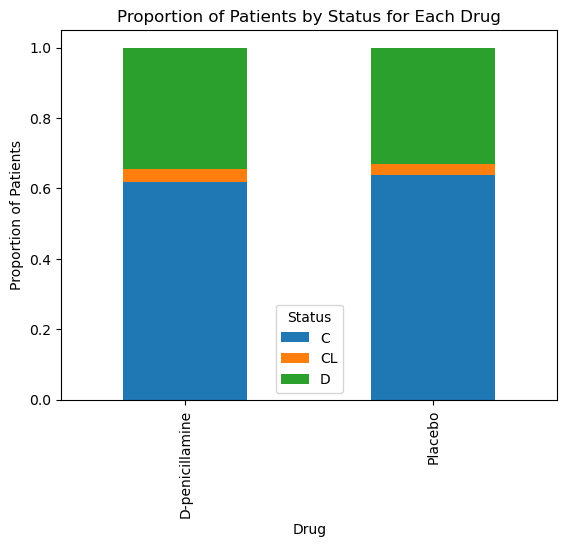

#### Drug did not have a signicant effect on status. D-penillamine did not have significant effect on the in proportion the of patients in each class


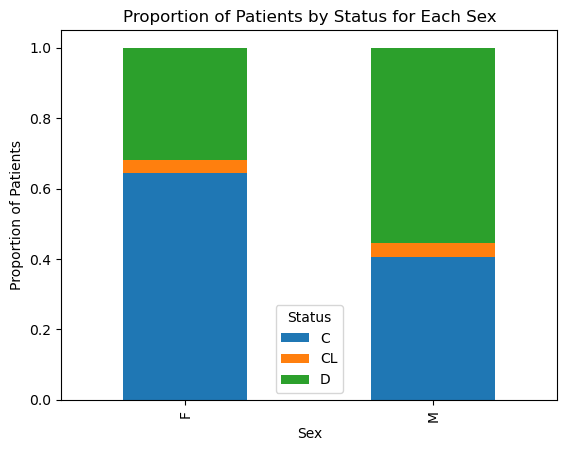

#### Sex had a signficant effect on status. Men had a higher proportion of patients in D class and lower proportion of patients in C class


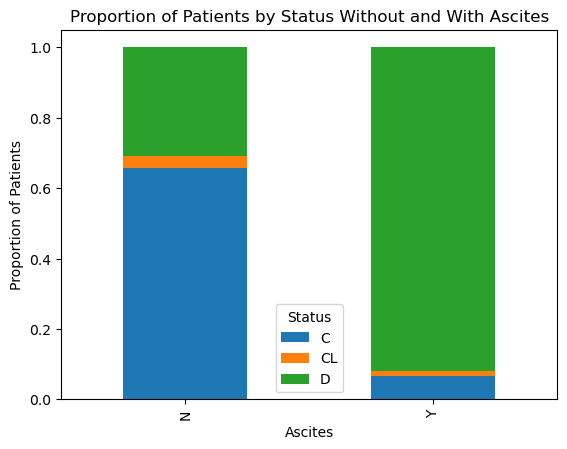

#### Ascites had a signficnat effect on status. Patients with ascites had a significantly higher proportion in D class and lower proportion in C class.


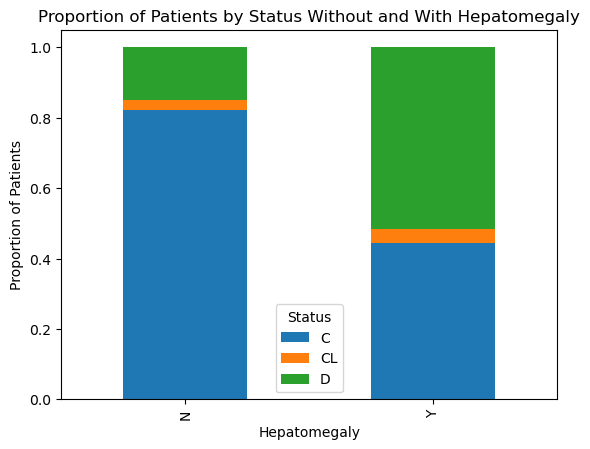

#### Hepatomegaly had a signficant effect on status. Patients with hepatomegaly had a higher proportion in D class and lower in C class.


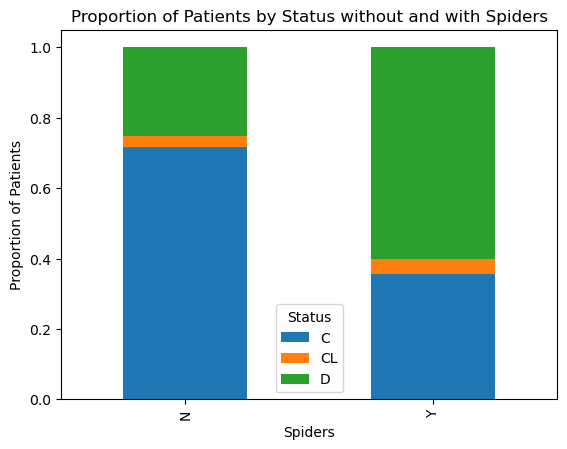

#### Spiders had a signficant effect on status. Patients with spiders had a higher proportion in D class and lower in C class.


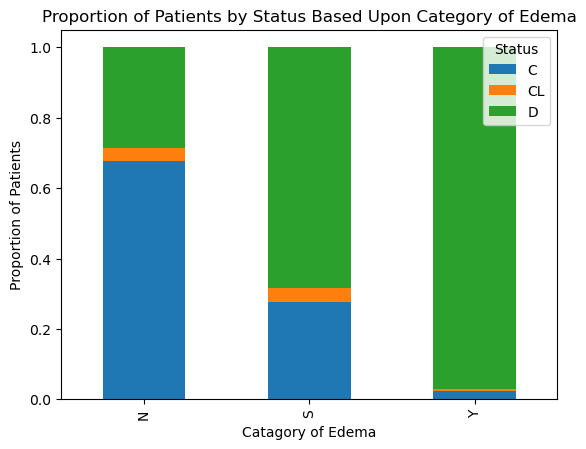

##### Edema category had a signficant effect on status. Patients in Y and S class for Edema had significantly higher proportion of patients in D class.
 Higher proportion in Y than S.
##### Description of edema variable: presence of edema N (no edema and no diuretic therapy for edema), S (edema present without diuretics, or edema resolved by diuretics), or Y (edema despite diuretic therapy)


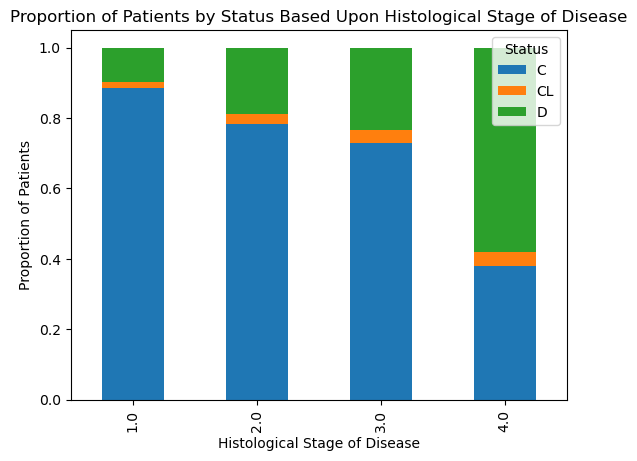

#### Stage of disease had a signficant effect on status. Patients in stage 4 of disease had a significantly higher proportion in D class than 1,2,3. 2 and 3 were greater than 1. 2 and 3 were similar.
###! Continuous features now:


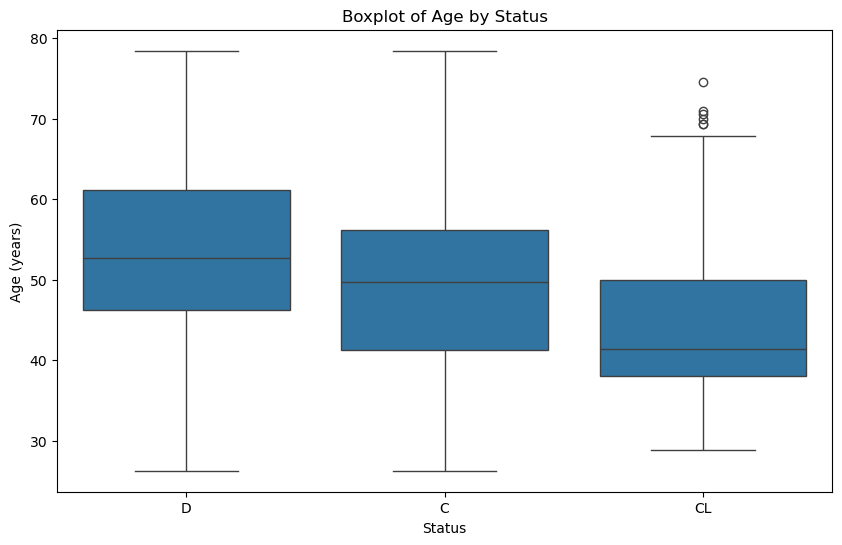

#### Age had an effect on status. Patients in CL class were associated with a lower age 


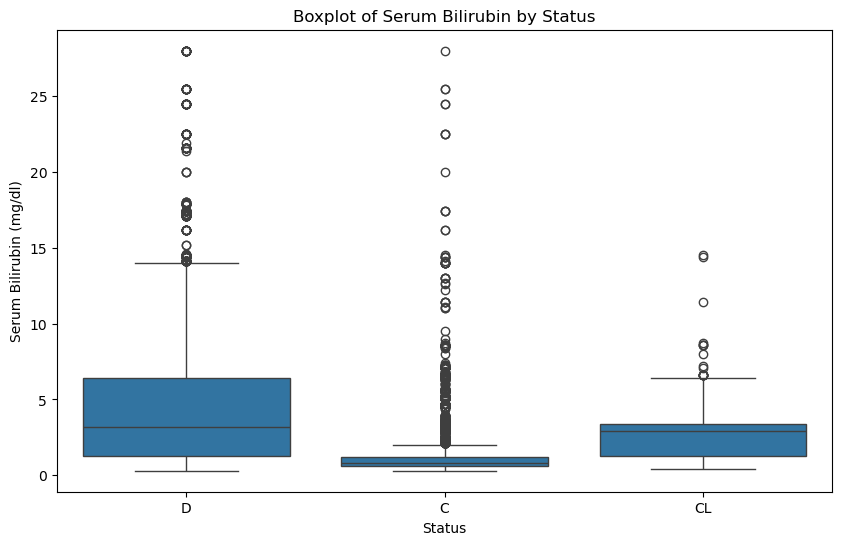

#### Bilirubin had an effect on status. Patients in C class had lower bilibrubin


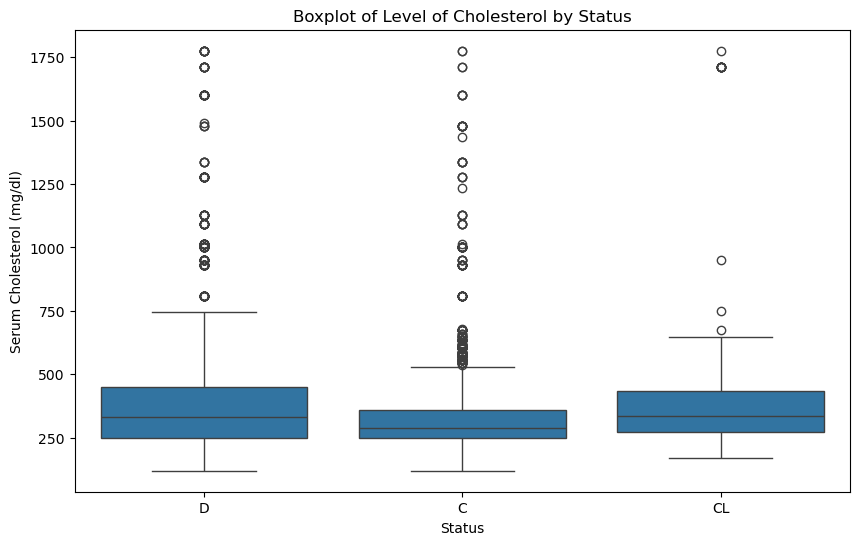

#### Cholesterol did not had an effect on status.


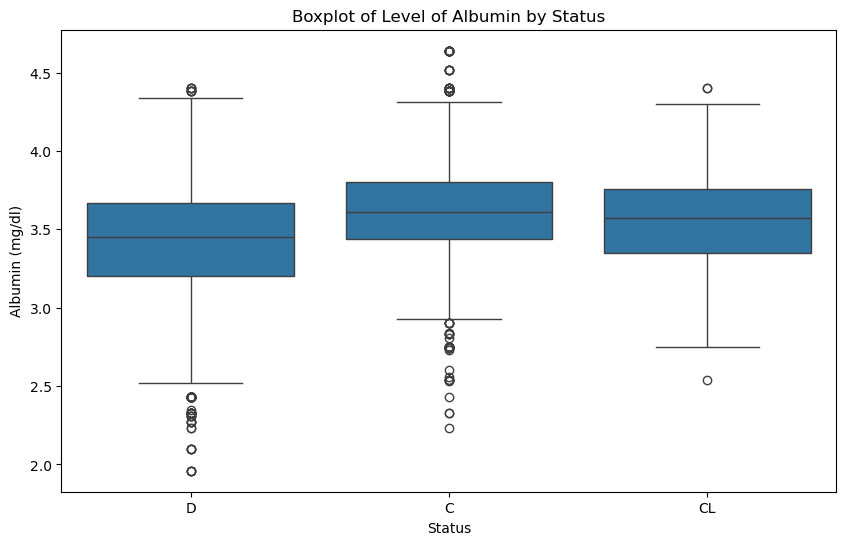

#### Albumin had an effect on status. Patients in D class were associated with lower albumin


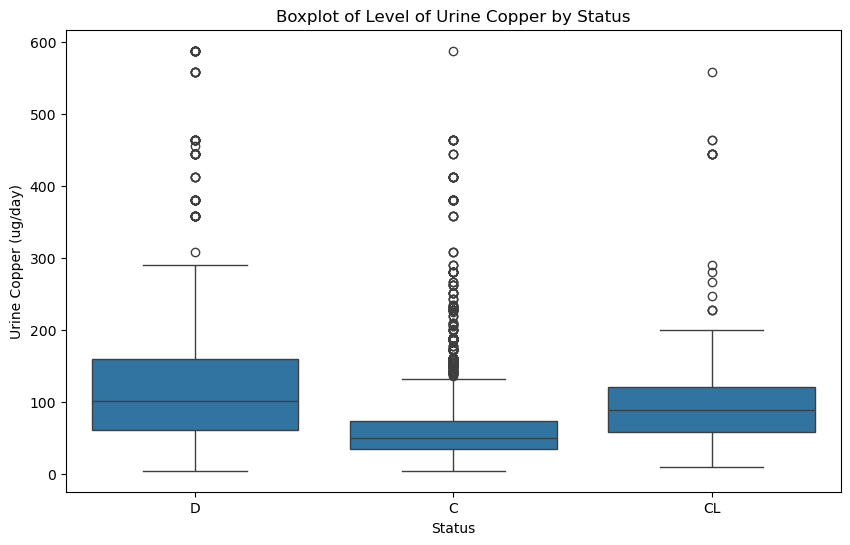

#### Copper in urine had an effect on status. Patients in C class were associated with lower copper in urine


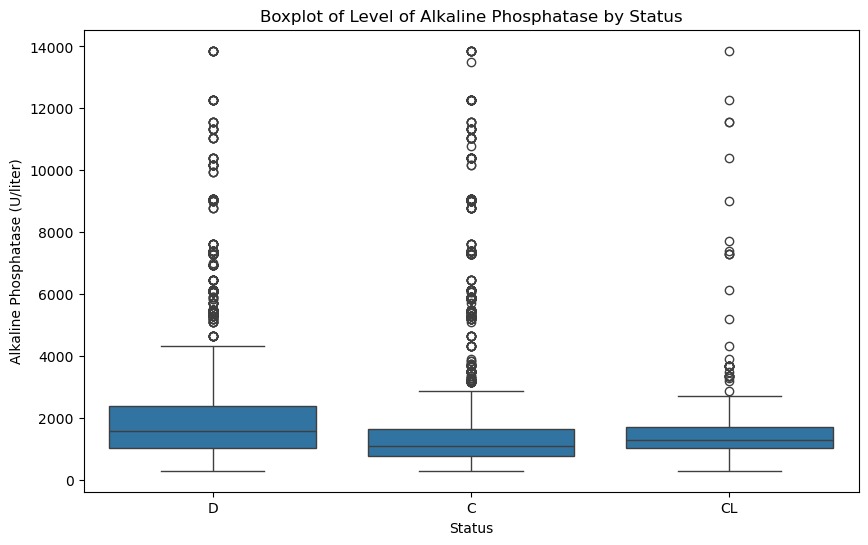

#### Alkaline phosphotase did not have a significant effect on status.


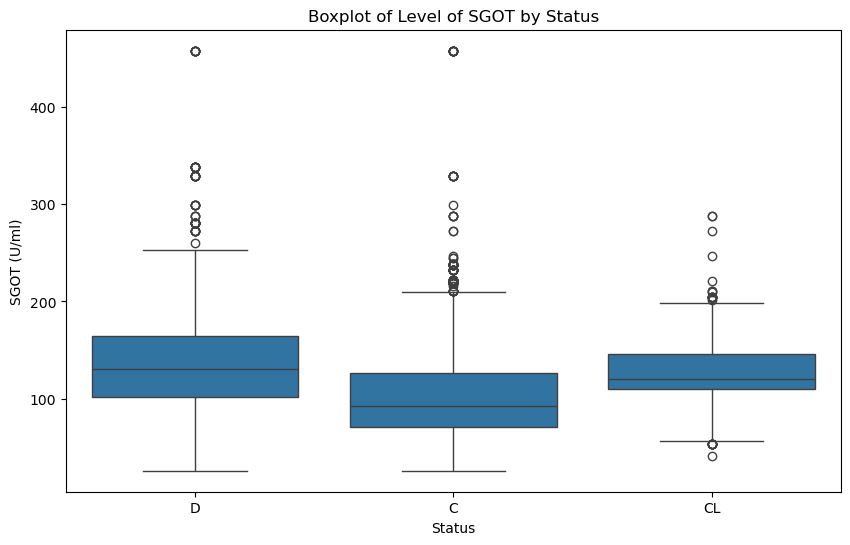

#### SGOT had an effect on status. Patients in C class were associated with lower SGOT
#### SGOT - serum glutamic-oxaloacetic transaminase


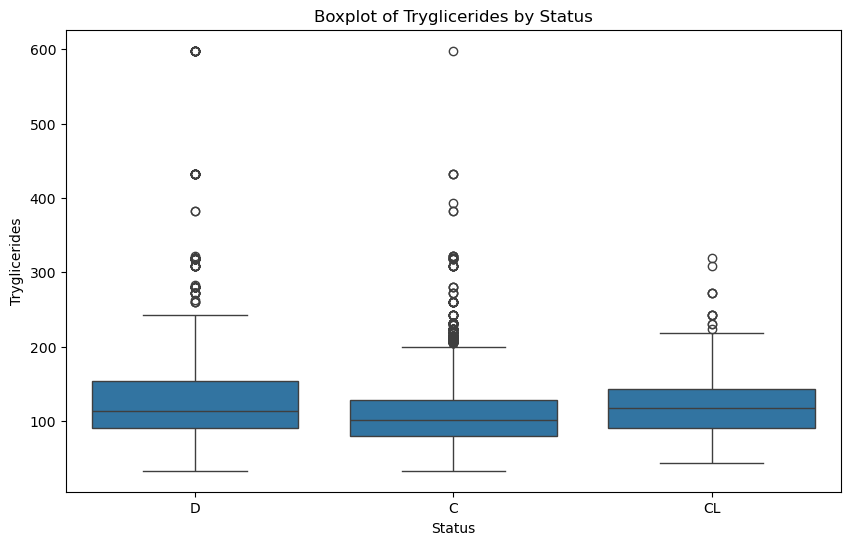

#### Triglicerides did not have a significant effect on status.


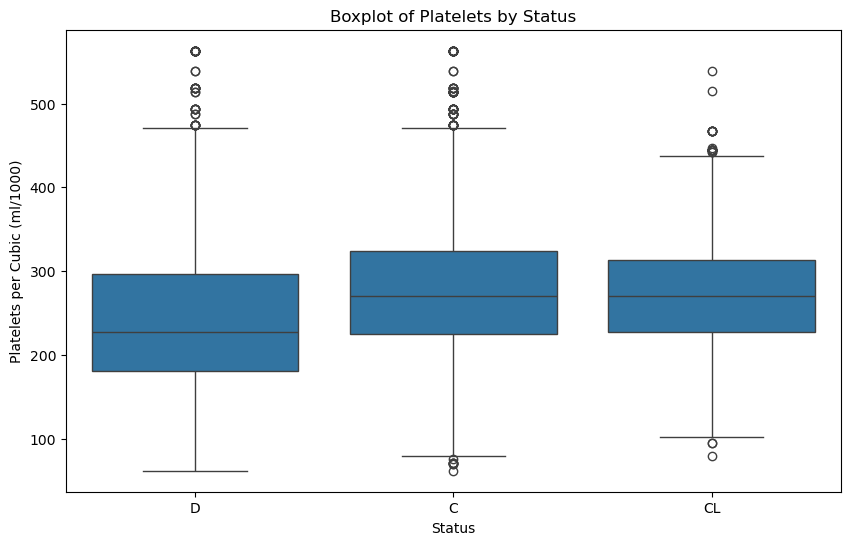

#### Platelets had an effect on status. Patients in D class were associated with lower platelets


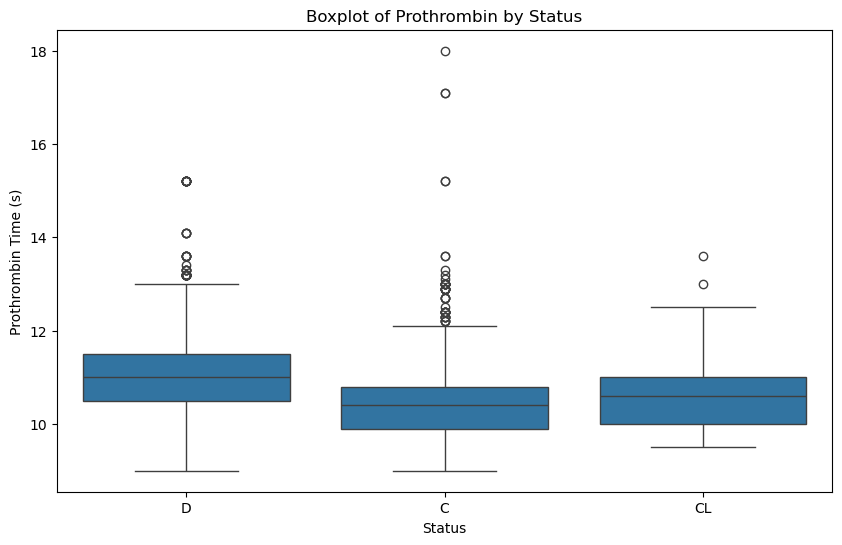

#### Prothrobin had an effect on status. Patients in D class were associated with higher prothrobin


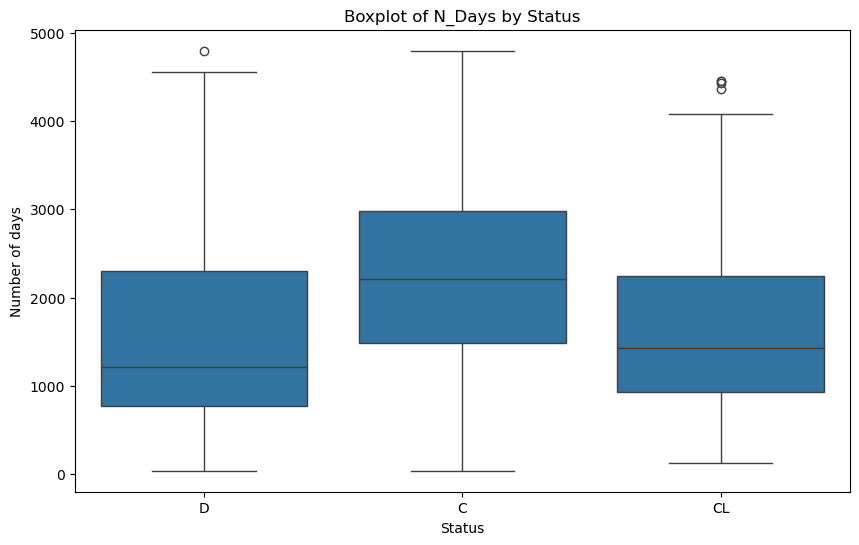

In [ ]:
# ### Correlations Exploration (Emma's)
# #### Notable insights
# ##### feature vs status 
# * Ascites and Y category of edema were strong predictors of D class 
#     - So Ascites and Edema predict Death.
# * Sex / hepatomegaly / spiders / stage / age / bilirubin / N_Days / albumin / copper in urine / SGOT/ platelets/ prothrombin influenced status.
#     - So all features are relevant to our model.
# ##### feature vs feature
# * Moderate negative correlation between N category of edema ascites (-0.53)
# * Strong positive correlation between Y category of edema and ascites (0.66)
#     - So Edema and Ascites are coupled to approximately 0.60 correlation.
# * Moderate positive correlation between stage and hepatomegaly (0.5)
#     - So Hepatomegaly predicts later Stage disease and vice versa.
# * No significant non-linear relationships were found between any two given features. 

## Importing packages and loading the data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

## Looking for relationships between features and status
### Categorical variables
print('## Looking for relationships between features and `Status`\n',
      '\n### Categorical variables first:')
# function used to create pivot table to draw stacked bar chart
def createPivotTable(data, variable): 
    # Group the data by 'Drug' and 'Status' and count the occurrences
    grouped = data.groupby([variable, 'Status']).size().reset_index(name='Count')
    total_patients_per_variable  = grouped.groupby(variable)['Count'].transform('sum')
    grouped['Proportion'] = grouped['Count'] / total_patients_per_variable
    pivot_df = grouped.pivot(index=variable, columns='Status', values='Proportion')
    return pivot_df
pivot_df = createPivotTable(df_train, 'Drug')
# Plotting the stacked bar chart
pivot_df.plot(kind='bar', stacked=True)
# Adding titles and labels
plt.title('Proportion of Patients by Status for Each Drug')
plt.xlabel('Drug')
plt.ylabel('Proportion of Patients')
# Adding a legend
plt.legend(title='Status')
# Displaying the plot
plt.show()
#### Drug did not have a signicant effect on status. D-penillamine did not have significant effect on the in proportion the of patients in each class
print('#### Drug did not have a signicant effect on status. D-penillamine did not have significant effect on the in proportion the of patients in each class')

pivot_df = createPivotTable(df_train, 'Sex')
# Plotting the stacked bar chart
pivot_df.plot(kind='bar', stacked=True)
# Adding titles and labels
plt.title('Proportion of Patients by Status for Each Sex')
plt.xlabel('Sex')
plt.ylabel('Proportion of Patients')
# Adding a legend
plt.legend(title='Status')
# Displaying the plot
plt.show()
#### Sex had a signficant effect on status. Men had a higher proportion of patients in D class and lower proportion of patients in C class
print('#### Sex had a signficant effect on status. Men had a higher proportion of patients in D class and lower proportion of patients in C class')

pivot_df = createPivotTable(df_train, 'Ascites')
# Plotting the stacked bar chart
pivot_df.plot(kind='bar', stacked=True)
# Adding titles and labels
plt.title('Proportion of Patients by Status Without and With Ascites')
plt.xlabel('Ascites')
plt.ylabel('Proportion of Patients')
# Adding a legend
plt.legend(title='Status')
# Displaying the plot
plt.show()
#### Ascites had a signficnat effect on status. Patients with ascites had a significantly higher proportion in D class and lower proportion in C class.
print('#### Ascites had a signficnat effect on status. Patients with ascites had a significantly higher proportion in D class and lower proportion in C class.')

pivot_df = createPivotTable(df_train, 'Hepatomegaly')
# Plotting the stacked bar chart
pivot_df.plot(kind='bar', stacked=True)
# Adding titles and labels
plt.title('Proportion of Patients by Status Without and With Hepatomegaly')
plt.xlabel('Hepatomegaly')
plt.ylabel('Proportion of Patients')
# Adding a legend
plt.legend(title='Status')
# Displaying the plot
plt.show()
#### Hepatomegaly had a signficant effect on status. Patients with hepatomegaly had a higher proportion in D class and lower in C class.
print('#### Hepatomegaly had a signficant effect on status. Patients with hepatomegaly had a higher proportion in D class and lower in C class.')

pivot_df = createPivotTable(df_train, 'Spiders')
# Plotting the stacked bar chart
pivot_df.plot(kind='bar', stacked=True)
# Adding titles and labels
plt.title('Proportion of Patients by Status without and with Spiders')
plt.xlabel('Spiders')
plt.ylabel('Proportion of Patients')
# Adding a legend
plt.legend(title='Status')
# Displaying the plot
plt.show()
#### Spiders had a signficant effect on status. Patients with spiders had a higher proportion in D class and lower in C class. 
print('#### Spiders had a signficant effect on status. Patients with spiders had a higher proportion in D class and lower in C class.')

pivot_df = createPivotTable(df_train, 'Edema')
# Plotting the stacked bar chart
pivot_df.plot(kind='bar', stacked=True)
# Adding titles and labels
plt.title('Proportion of Patients by Status Based Upon Category of Edema')
plt.xlabel('Catagory of Edema')
plt.ylabel('Proportion of Patients')
# Adding a legend
plt.legend(title='Status')
# Displaying the plot
plt.show()
##### Edema category had a signficant effect on status. Patients in Y and S class for Edema had significantly higher proportion of patients in D class. 
##### Higher proportion in Y than S. 
##### Description of edema variable: presence of edema N (no edema and no diuretic therapy for edema), S (edema present without diuretics, or edema resolved by diuretics), or Y (edema despite diuretic therapy)
print('##### Edema category had a signficant effect on status. Patients in Y and S class for Edema had significantly higher proportion of patients in D class.\n Higher proportion in Y than S.\n##### Description of edema variable: presence of edema N (no edema and no diuretic therapy for edema), S (edema present without diuretics, or edema resolved by diuretics), or Y (edema despite diuretic therapy)')

pivot_df = createPivotTable(df_train, 'Stage')
# Plotting the stacked bar chart
pivot_df.plot(kind='bar', stacked=True)
# Adding titles and labels
plt.title('Proportion of Patients by Status Based Upon Histological Stage of Disease')
plt.xlabel('Histological Stage of Disease')
plt.ylabel('Proportion of Patients')
# Adding a legend
plt.legend(title='Status')
# Displaying the plot
plt.show()
#### Stage of disease had a signficant effect on status. Patients in stage 4 of disease had a significantly higher proportion in D class than 1,2,3. 2 and 3 were greater than 1. 2 and 3 were similar.
print('#### Stage of disease had a signficant effect on status. Patients in stage 4 of disease had a significantly higher proportion in D class than 1,2,3. 2 and 3 were greater than 1. 2 and 3 were similar.')


###! Continuous variables
print('\n###! Continuous features now:')

# Convert age from days to years for better readability
df_train['Age_years'] = df_train['Age'] / 365.25
# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Status', y='Age_years', data=df_train)
plt.title('Boxplot of Age by Status')
plt.xlabel('Status')
plt.ylabel('Age (years)')
plt.show()
#### Age had an effect on status. Patients in CL class were associated with a lower age 
print('#### Age had an effect on status. Patients in CL class were associated with a lower age ')
# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Status', y='Bilirubin', data=df_train)
plt.title('Boxplot of Serum Bilirubin by Status')
plt.xlabel('Status')
plt.ylabel('Serum Bilirubin (mg/dl)')
plt.show()
#### Bilirubin had an effect on status. Patients in C class had lower bilibrubin
print('#### Bilirubin had an effect on status. Patients in C class had lower bilibrubin')
# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Status', y='Cholesterol', data=df_train)
plt.title('Boxplot of Level of Cholesterol by Status')
plt.xlabel('Status')
plt.ylabel('Serum Cholesterol (mg/dl)')
plt.show()
#### Cholesterol did not had an effect on status.
print('#### Cholesterol did not had an effect on status.')
# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Status', y='Albumin', data=df_train)
plt.title('Boxplot of Level of Albumin by Status')
plt.xlabel('Status')
plt.ylabel('Albumin (mg/dl)')
plt.show()
#### Albumin had an effect on status. Patients in D class were associated with lower albumin
print('#### Albumin had an effect on status. Patients in D class were associated with lower albumin')
# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Status', y='Copper', data=df_train)
plt.title('Boxplot of Level of Urine Copper by Status')
plt.xlabel('Status')
plt.ylabel('Urine Copper (ug/day)')
plt.show()
#### Copper in urine had an effect on status. Patients in C class were associated with lower copper in urine
print('#### Copper in urine had an effect on status. Patients in C class were associated with lower copper in urine')
# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Status', y='Alk_Phos', data=df_train)
plt.title('Boxplot of Level of Alkaline Phosphatase by Status')
plt.xlabel('Status')
plt.ylabel('Alkaline Phosphatase (U/liter)')
plt.show()
#### Alkaline phosphotase did not have a significant effect on status.
print('#### Alkaline phosphotase did not have a significant effect on status.')
# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Status', y='SGOT', data=df_train)
plt.title('Boxplot of Level of SGOT by Status')
plt.xlabel('Status')
plt.ylabel('SGOT (U/ml)')
plt.show()
#### SGOT had an effect on status. Patients in C class were associated with lower SGOT
#### SGOT - serum glutamic-oxaloacetic transaminase
print('#### SGOT had an effect on status. Patients in C class were associated with lower SGOT\n#### SGOT - serum glutamic-oxaloacetic transaminase')
# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Status', y='Tryglicerides', data=df_train)
plt.title('Boxplot of Tryglicerides by Status')
plt.xlabel('Status')
plt.ylabel('Tryglicerides')
plt.show()
#### Triglicerides did not have a significant effect on status.
print('#### Triglicerides did not have a significant effect on status.')
# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Status', y='Platelets', data=df_train)
plt.title('Boxplot of Platelets by Status')
plt.xlabel('Status')
plt.ylabel('Platelets per Cubic (ml/1000)')
plt.show()
#### Platelets had an effect on status. Patients in D class were associated with lower platelets
print('#### Platelets had an effect on status. Patients in D class were associated with lower platelets')
# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Status', y='Prothrombin', data=df_train)
plt.title('Boxplot of Prothrombin by Status')
plt.xlabel('Status')
plt.ylabel('Prothrombin Time (s)')
plt.show()
#### Prothrobin had an effect on status. Patients in D class were associated with higher prothrobin
print('#### Prothrobin had an effect on status. Patients in D class were associated with higher prothrobin')
# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Status', y='N_Days', data=df_train)
plt.title('Boxplot of N_Days by Status')
plt.xlabel('Status')
plt.ylabel('Number of days')
plt.show()
#### N days had an effect on status. Patients in D and CL class were associated with a fewer number of days 
print('#### N days had an effect on status. Patients in D and CL class were associated with a fewer number of days.')

#### Looking for relationships between features and features

#### Looking for relationships between features and features 
##### Ordinal features: 
     * `Stage` 
##### One hot encoded categorical features: 
     * `Sex`, `Ascites`, `Hepatomegaly`, `Spiders`, `Edema`, `Drug`
##### Numerical features 
     * Age, Bilirubin, Cholesterol, Albumin, Copper, Alk_Phos, SGOT, Tryglicerides, Platelets, Prothrombin
#### Findings: 
     * strong negative correlation between N category of edema ascites (-0.53) 
     * strong positive correlation between Y category of edema and ascites (0.66) 
     * strong positive correlation between stage and hepatomegaly (0.5) 
     * Misleading negative correlations for categorical features between their encoded sub-categories b/c these are mutually exclusive
### Non-linear relationships between feature pairs: 
   * We found no significant non linear relationships between any two features


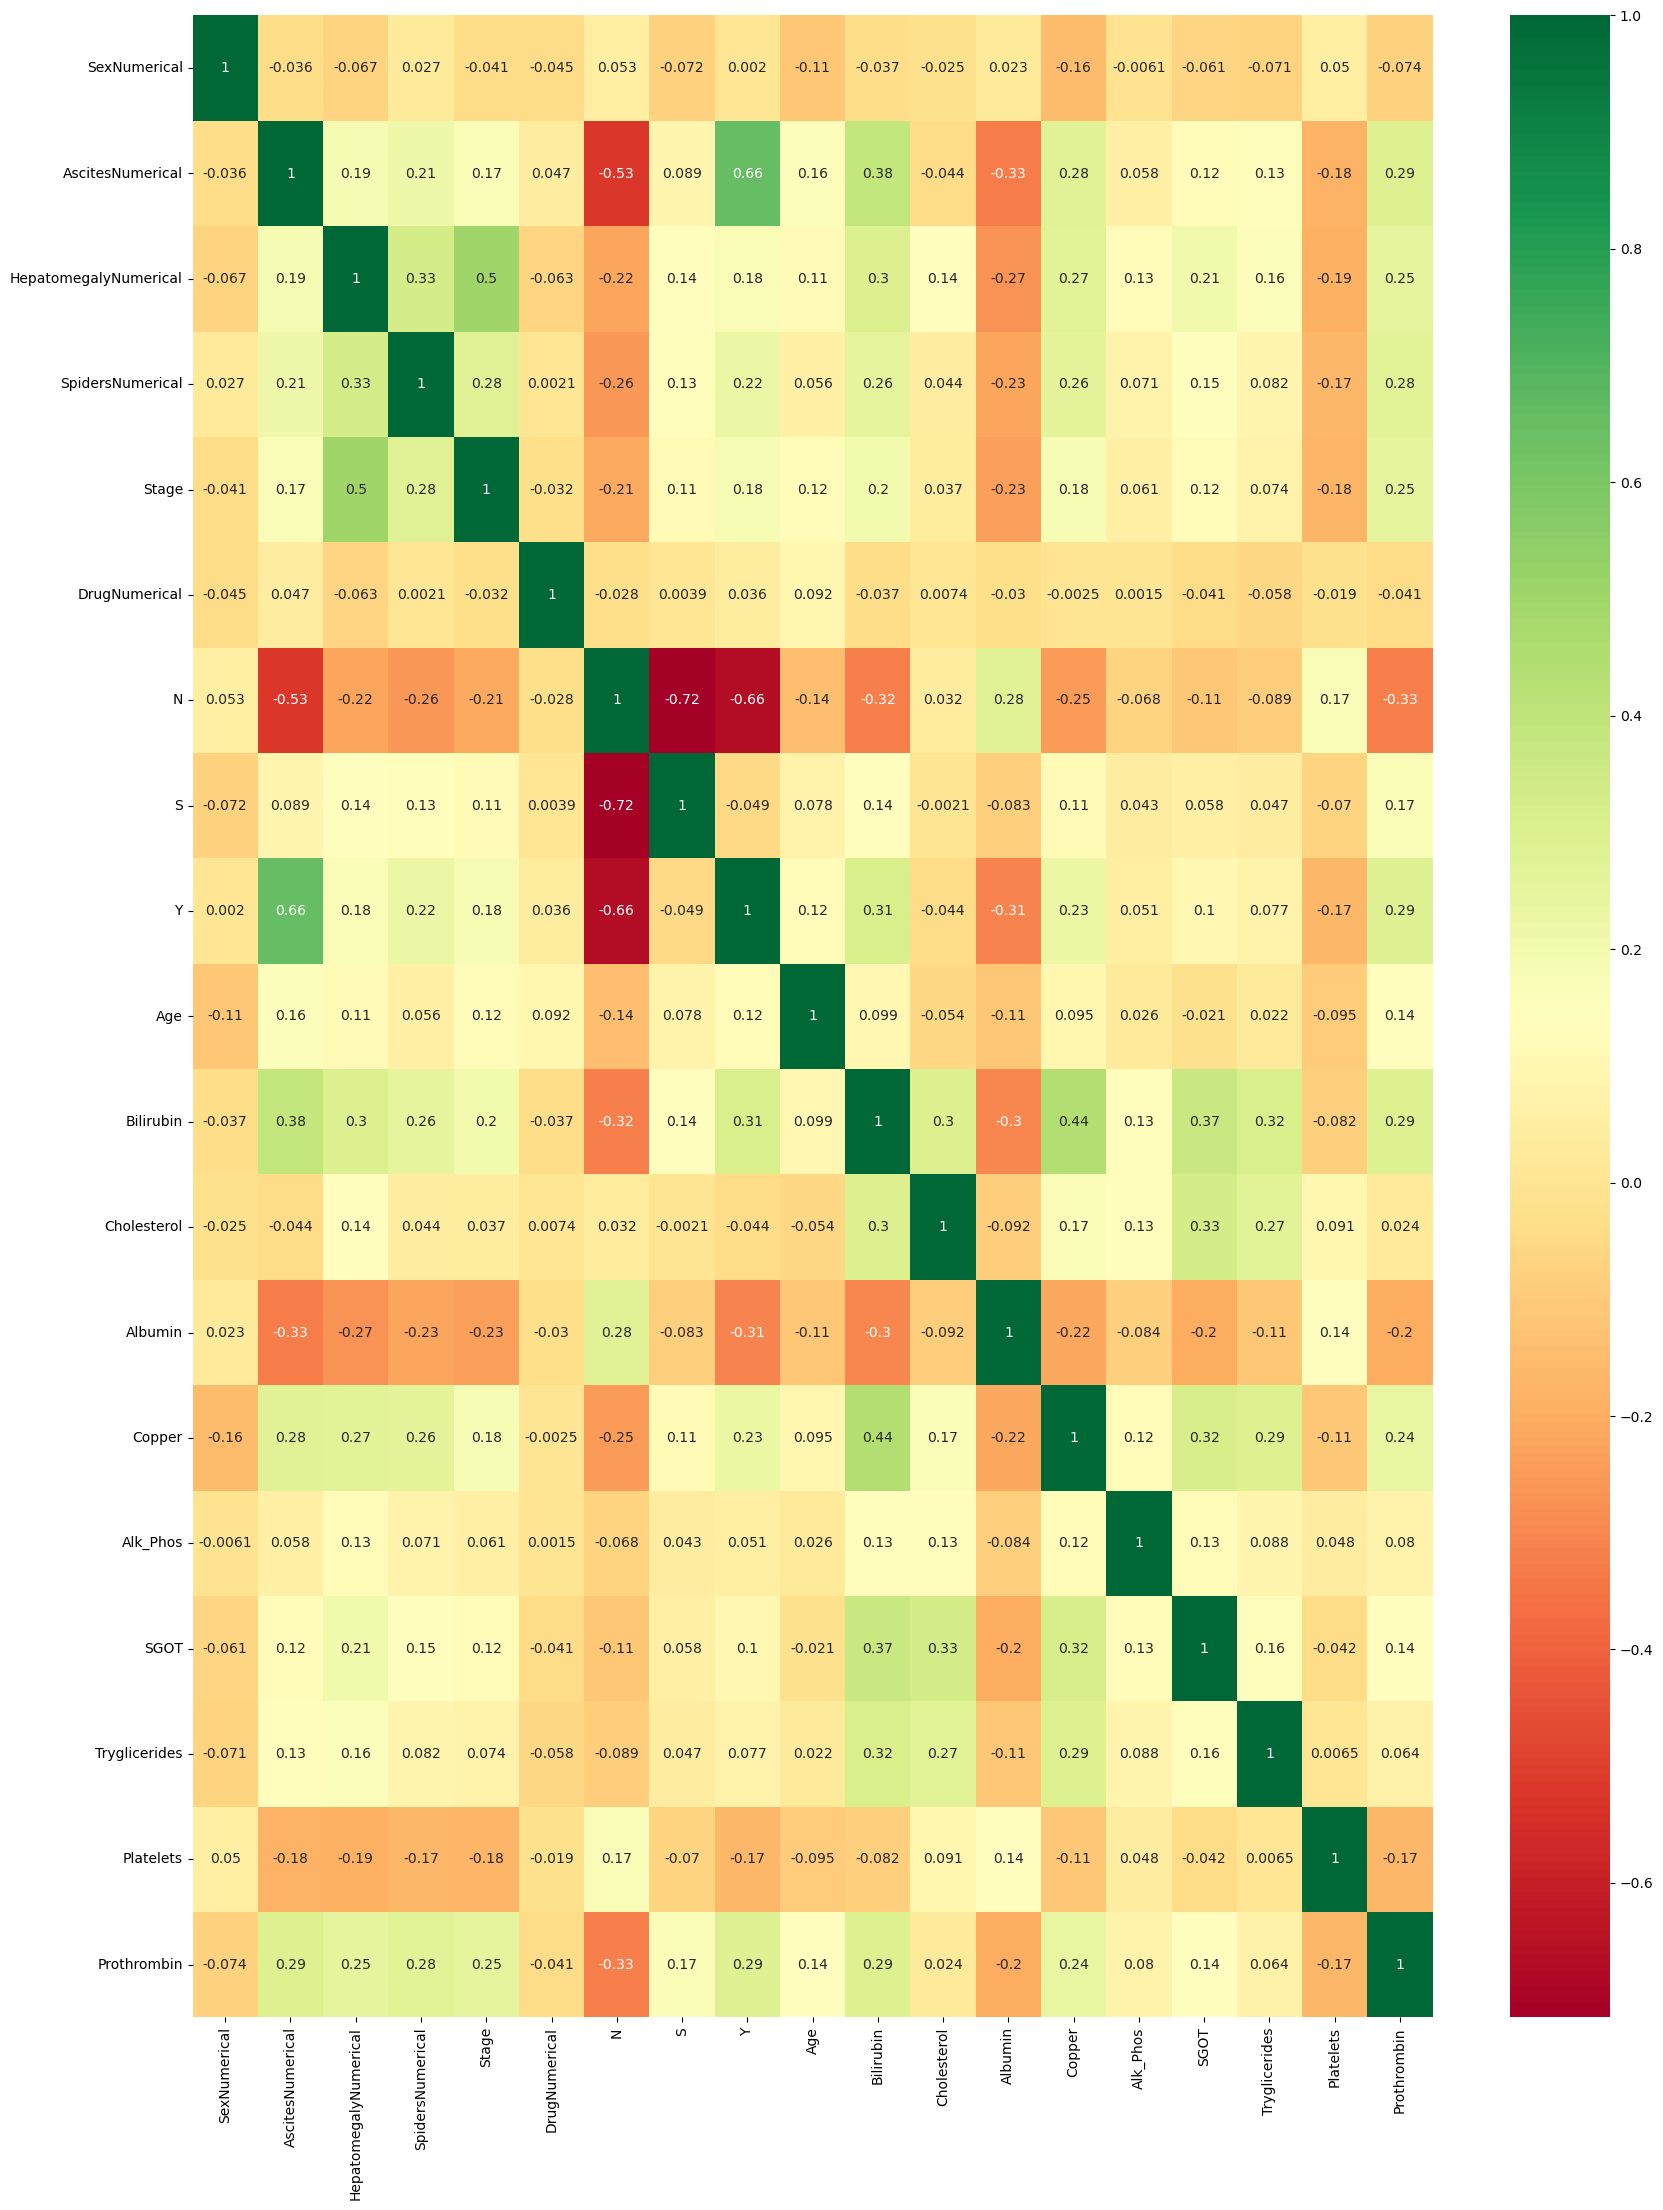

In [ ]:
#### Looking for relationships between features and features
##### Ordinal features: 
# * `Stage`
##### One hot encoded categorical features: 
# * `Sex`, `Ascites`, `Hepatomegaly`, `Spiders`, `Edema`, `Drug`
print('#### Looking for relationships between features and features',
    '\n##### Ordinal features:',
    '\n     * `Stage`',
    '\n##### One hot encoded categorical features:',
    '\n     * `Sex`, `Ascites`, `Hepatomegaly`, `Spiders`, `Edema`, `Drug`')

# Edema
data = {'Category': ['N', 'S', 'Y']}
df = df_train['Edema']
EdemaNumerical = pd.get_dummies(df, columns=['Category'])

df_train['SexNumerical'] = np.where(df_train['Sex']=='F', 1, 0)
df_train['AscitesNumerical'] = np.where(df_train['Ascites']=='N', 0, 1)
df_train['HepatomegalyNumerical'] = np.where(df_train['Hepatomegaly']=='N', 0, 1)
df_train['SpidersNumerical'] = np.where(df_train['Spiders']=='N', 0, 1)
#df_train['EdemaNumerical'] = np.where(df_train['Edema']=='N', 0, 1)
df_train['DrugNumerical'] = np.where(df_train['Drug']=='D-penicillamine', 1, 0)
df_merged = (df_train[['SexNumerical', 'AscitesNumerical', 'HepatomegalyNumerical', 'SpidersNumerical', 'Stage', 'DrugNumerical']])
df_train_catagorical = pd.concat([df_merged, EdemaNumerical], axis=1)

# ##### Numerical
# * Age, Bilirubin, Cholesterol, Albumin, Copper, Alk_Phos, SGOT, Tryglicerides, Platelets, Prothrombin
print('##### Numerical features',
    '\n     * Age, Bilirubin, Cholesterol, Albumin, Copper, Alk_Phos, SGOT, Tryglicerides, Platelets, Prothrombin')

df_train_numerical = (df_train[['Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']])
all_train_data = df_train_catagorical.join(df_train_numerical)
plt.figure(figsize=(20,26))
sns.heatmap(all_train_data.corr(), annot=True, cmap="RdYlGn")
print('#### Findings:',
    '\n     * strong negative correlation between N category of edema ascites (-0.53)',
    '\n     * strong positive correlation between Y category of edema and ascites (0.66)',
    '\n     * strong positive correlation between stage and hepatomegaly (0.5)',
    '\n     * Misleading negative correlations for categorical features between their encoded sub-categories b/c these are mutually exclusive')

In [ ]:
### Non-linear relationships: Attempt analysis of non linear relationships between feature pairs
#### We found no significant non linear relationships between any two features
print('### Non-linear relationships between feature pairs (analysis attempted):',
      '\n   * We found no significant non linear relationships between any two features')
# Attempt analysis of non linear relationships between feature pairs
# plt.figure(figsize=(50,50))
# sns.pairplot(all_train_data)

# Appendicies (i.e. extra notes)

### SMOTE notes

#### SMOTE notes:
 
#### SMOTE (Synthetic Minority Over-sampling Technique)
SMOTE (Synthetic Minority Over-sampling Technique) enhances dataset balance by generating synthetic samples from the minority class in an imbalanced dataset to avoid model bias toward the majority class. SMOTE can help achieve more robust and accurate predictive models, although one should take care to ensure the synthetic datapoints are medically plausible.
 
##### How it works (vaguely)
1. **Neighbor Identification**: For each sample in the minority class, identify its k-nearest neighbors in the feature space. 
    
    Q: How to sort the neighbors in feature space? There is more than one feature, so there's more than one feature axis, and the k nearest neighbors with respect to each feature are different, so which list should I draw the k nearest neighbors from? 
    
    A: **Weighted Distance Metric**: Weight the distance metric according to the importance of each feature. The Euclidean distance $d$ between two points $x$ and $y$ in an $n$-dimensional space with weights $w_i$ is given by:
        $$d(x, y) = \sqrt{\sum_{i=1}^{n} w_i (x_i - y_i)^2}$$
    Where $w_i$ is the weight reflecting the importance of the $i$-th feature.
    Sort the nearest neighbors according to this metric in order to respect the relative importance of different features. In the absence of a measure of feature importance, make an educated guess based on domain knowledge or preliminary analysis.

 

2. **Synthetic Sample Creation**: Create a synthetic data entry that lies between a chosen data entry belonging to a minority class and one of its k-nearest neighbors. For each data entry belonging to a minority class, select a random neighbor from its k-nearest neighbors. Imagine plotting both these data points and drawing a 'line' between these two points in 'feature space'. Generate a synthetic sample along the line segment connecting the minority class data entry and its selected neighbor. The synthetic sample point we generate will have feature values that are a linear combination of the two original data points, with the combination coefficients randomly chosen between 0 and 1. So the features of this synthetic data entry necessarily lie between those of our two original points.
   
3. **Repetition**: Continue this process until the dataset achieves the desired level of balance or until the required number of synthetic samples is generated.

 

##### Caution
**Can introduce artificial bias,** particularly if synthetic points do not well represent the underlying medical scenarios as hoped. One could scrutinize the medical plausibility of synthetic data.
**Validate on unmodified test dataset,** to ensure improvements in performance metrics are genuine instead of overfitting to synthetic samples.

### Medical guide to features (domain knowledge)

#### Medical consultation
Domain knowledge (justification for data feature selection or weighting):
- JM interviewd medical doctors about our data features, writing up the notes below.
 

##### Correlated:

 

Hepatomegaly:
- Enlarged liver.

 

Ascites: 
- Swollen belly from pressure buildup from hepatic portal vein being backed up because it cannot drain through liver properly.

 

Spider naevi: 
- Spidery blood vessels. Visible on skin of chest etc. Effectively compensatory vein growth. https://en.wikipedia.org/wiki/Spider_angioma

 

Edema. 
- Backup of fluid, usually where gravity takes it, like legs or small of the back. Puffy swelling from excess fluid.

 

Albumin: 
- Albumin is a protein responsible for osmotic pressure via the osmotic flow of fluid back into blood vessels. Counteracts hydrostatic flow out of blood vessels. Produced by liver. Bad liver underproduces albumin. Negatively correlated with other symptoms.

 

Cholesterol: 
- Liver makes it. So cholesterol may be low in case of liver disease, i.e. negatively correlated with other symptoms. But maybe clinically insignificant. Cholesterol also predicts bad health generally and coronary disease, in which case it would be high. So expect confusion from cholesterol data feature.

 

##### Sometimes correlated

 

Biliary v hepatic liver failure:
- Two types of liver failure, biliary or hepatic. 
- Hepatic liver failure comes from the liver tissues rather than as a complication from the bile ducts.
- Biliary liver failure is caused by bile drainage failures, when the bile duct draining from the liver instead backs up into the liver and causes liver failure. 
    - Livers produce bile that drains from the liver via the pancreas to the bowels etc. Biliary liver failure tends to result from failures elsewhere, including pancreatic cancer, gall stones, cholestasis. If there's a reversible cause, then you can fix it, then replace the damaged liver via transplant. 

 

Copper: 
- High copper damages liver through Wilson’s disease, so high copper indicates one mechanism for liver damage. But copper may not indicate other mechanisms. So high copper level may be a sufficient indicator of liver damage via Wilson's disease, but not a necessary indicator, because there are other mechanisms for liver damage. https://en.wikipedia.org/wiki/Wilson's_disease

 

Alkaline phosphatase (`Alk_Phos`): 
- Released by biliary ducts. So `Alk_Phos` levels indicate biliary liver failure.

 

SGOT. 
- SGOT is uniquely contained in liver cells. So SGOT levels indicate liver cell death. Hepatic liver failure. Specific to alcoholic liver failure (as opposed to hepatitis or something).
Prothrombin: 
- Clotting factor made by liver. Expect less in case of liver failure.
Tryglicerides:
- Blood tryglyceride level. Elevated triglyceride levels can be associated with fatty liver disease, a condition that may progress to more serious liver disease stages.
Platelets:
- Blood platelets level. Low platelets indicates cirrhosis.

 

Stage (according to Mayo Clinic who ran the real study 1974-84):
The Mayo Clinic defines four stages of liver failure associated with the progression of cirrhosis, reflecting the severity of the liver damage and the associated complications. 

 

1. **Stage 1 (Compensated cirrhosis):** The liver is damaged but still able to perform most of its functions. Expect few or no symptoms. The condition is often detected through routine testing or incidentally during the evaluation of another issue. Liver scarring is present, but there are no complications of cirrhosis at this stage.

 

2. **Stage 2 (Compensated cirrhosis with varices):** The liver damage progresses, and complications begin to emerge. One key complication is the development of varices, which are enlarged veins, particularly in the esophagus and stomach. This occurs due to increased blood pressure in the liver (portal hypertension). Patients still may not experience significant symptoms related to liver function but are at risk for bleeding from these varices.

 

3. **Stage 3 (Decompensated cirrhosis):** The liver is now significantly impaired, leading to serious complications. Patients may experience symptoms like jaundice (yellowing of the skin and eyes), ascites (accumulation of fluid in the abdomen), and hepatic encephalopathy (brain dysfunction caused by liver insufficiency). These symptoms indicate that the liver can no longer adequately perform its functions.

 

4. **Stage 4 (End-stage liver disease or failure):** This is the most severe stage, where liver function is critically impaired, leading to life-threatening complications. At this point, the liver can barely perform its vital functions, and the patient typically requires a liver transplant to survive.

 

Predicting stages would help immediate interpretability for our clients as stage designations are used by doctors to determine the best course of treatment and evaluate the need for potential interventions like liver transplantation.
 

##### Transplant eligibility:
- Transplants are medically rationed according to utility maximizing criteria. That means transplants are given where it is judged they will do the most good. So you only get a liver transplant if the doctors believe both that you need it and that you won't ruin it, and even then there aren't enough livers.
- Wilson's disease (correlated with high copper and D-penicillamine effectiveness): Transplants are effective if you take steps to avoid Wilson’s disease ruining the next liver too.
- Cancer (cancerous carcinoma = Stage 4 liver disease): No transplants if cancer will ruin the next liver too. (Eligibility depends on the type of cancer.)
- Drinking (correlated with many data features): No transplants if your drinking will ruin the next liver too. Alcoholism makes you ineligible for new liver, as a medical rationing judgement.

 


##### Other comments on bile ducts:
- Putting bile duct through pancreas is worst engineering in body because it causes so many problems. Pancreas makes enzymes like amylase. Made in inactivated form in pancreas. Amylase is auto activating. So active form will activate all the inactive forms. So important it doesn’t encounter any active amylase. But bile backing up like with gall stones can cause amylase to activate then pancreas to start eating itself. Pancreatic enzymes have specific enzymes to inhibit their activation while still in the pancreas. But these fail if bile ducts back up. That can cause biliary liver failure.
 
 

##### Models:
- Logistic regression. Interpretable. Doctors like interpretability and dislike black boxes because they’re personally responsible for their decisions and the patient. Good predictive power. Comparatively linear data so suitable.
- Vector support model.
- Random forest. [YES]
- Neural network. [YES]
- Gradient boost. [YES]

 

Client perspective may be that, for everyday use, anything other than the linearity of logistic regression presents interpretability problems and often ruins the model. So more advanced models need to be justified, implemented with care, and evaluated for plausibility. Better performance and accuracy are adequate justifications in our case.

## Report

### Plans for Report

### Plan1 for Report (JM)

**Title Section:**
*   Title of the Report: 
    * Leveraging machine learning to predict liver cirrhosis outcomes from clinical data
*   Your Name: 
    * Anonymous
*   Affiliation: 
    * University of St Andrews
*   Date: 
    * 5th April 2024

 

**Executive Summary (in place of an academic abstract):**
*   A brief overview of the objectives, key findings, and recommendations.

 

Skip the table of contents for the Report, but use it for our .ipynb Code because that will be long with many sub-sections:
    **Table of Contents:**
    *   Section headings, in order.

 

**1. Introduction:**
* What is liver cirrhosis and why do we care?
* Objectives of the project.
* Overview of the dataset and initial hypotheses that will guide us.

 

**2. Data Description and Preprocessing:**
* Summary of the dataset, including source, features, and target variable.
    * Synthetic dataset from Kaggle based on a famous Mayo Clinic study from 1974-1984.
* Details of preprocessing steps: data cleaning, handling missing values, encoding categorical variables, and feature scaling.

 

**3. Exploratory Data Analysis:**
* Statistical summaries and visualizations of the data.
* Initial insights and identification of potential trends and anomalies.
* **3.1 Feature Importance Analysis:**
    * Insights from feature importance rankings and their implications.

 

**4. Methodology:**
* Overview of the modeling approach and rationale for chosen methods.
* Description of the train-test split, cross-validation, and the techniques to address class imbalance.
* (Expand)

 

**5. Model Development and Evaluation:**
    
* **5.1 Initial Model Training:**
    * Description and results of initial model training with Linear Regression, Gradient Boosting, and Random Forest.
    * Performance metrics and initial evaluation.
      
* **5.2 Hyperparameter Tuning:**
    * Methodology and results of hyperparameter tuning.
    * Comparison of model performance before and after tuning.
      
* **5.3 Cross-Validation:**
    * Approach and findings from k-fold cross-validation to assess model stability.
      
* **5.4 Error Analysis:**
    * Examination of misclassified instances and discussion of potential reasons.
    * Important to our medical clients.

 

**6. Key Insights and Interpretations:**
* Summary of the most significant findings from the model evaluations and analyses.
* Discussion of how these findings align with existing knowledge.
* Predictive power of our model(s) for liver cirrhosis outcomes.

 

**7. Future Work:**
* Suggestions for future data collection or research to use our model and exploit our modeling approach.
* Recommendations for clinical practice to use our model, and for further research and data gathering to exploit our modeling approach.

 

**8. Conclusion and recommendations:**
* Recap our main achievements and the utility of our model(s) / approach.
* Maybe final thoughts on the impact and future directions (i.e. pitch for further contracts in future).

 

**9. References:**
* Citing sources, datasets, and literature referenced in the report.

 

**10. Appendices (brief if any):**
* Summary graphs and figures excluded from main report. 
* Additional data, code snippets, or extended analysis details.

 

**11. Code (.ipynb):** 
* Our .ipynb Code.
* Add a Table of Contents for readability.

### Plan2 for Report 240404

0. Executive Summary (in place of an academic abstract): 

- A brief overview of the objectives, key findings, and recommendations. 
    

Skip the table of contents for the Report, but use it for our .ipynb Code because that will be long with many sub-sections: Table of Contents: * Section headings, in order. 

1. Introduction: 

- What is liver cirrhosis and why do we care? 
    
- Objectives of the project. 
    
- Overview of the dataset and initial hypotheses that will guide us. 
    

2. Data Description and Preprocessing: 

- Summary of the dataset, including source, features, and target variable. 
    

-  James: Our dataset is synthetic and based on the famous Mayo Clinic Liver Cirrohosis Study (1974-84).[cite] The data features include many medical measures and demographic variables for hypothetical patients with liver cirrhosis. Each record represents a patient's clinical profile and outcome. 
    

- Details of preprocessing steps: data cleaning, handling missing values, encoding categorical variables, and feature scaling. 
    

- Pamela: Used custom transformer instead of one-hot encoding for several attributes because their values are binary -> one-hot encoding would generate redundant columns which might hinder performance 
    

3. Exploratory Data Analysis: 

- Statistical summaries and visualizations of the data. 
    

- Emma: Data was normally distributed  
    
- Emma: Imbalanced classes – C (63%), D (34%), CL (3%) (train dataset) 
    

- Initial insights and identification of potential trends and anomalies. 
    

- Emma: moderate negative correlation between N category of edema ascites (-0.53) 
    
- Emma: strong positive correlation between Y category of edema and ascites (0.66) 
    
- James: Therefore, Edema and Ascites do correlate (approximately 0.60). So one is highly predictive of the other. Stronger correlations may provide opportunities for feature engineering in the future as both features could be treated as effectively one feature with each one almost redundant with respect to the other (to a measure of approximately 0.60 correlation here). Or, in our clinical use-case, this may allow our model’s predictive power to suffer less when only one or other of these data features is available to the clinician. So we provide that advice here in our report. 
    
- Emma: moderate positive correlation between stage and hepatomegaly (0.5) 
    
- Emma: no significant non-linear correlations were found between features  
    

- 3.1 Feature Importance Analysis: 
    

- Insights from feature importance rankings and their implications. 
    
- Emma: Visualised the relationship between each feature with the proportion of patients in each status  
    
- Emma: found that ascites and y category of edema were strong predictors of status.  
    
- Emma: Sex / hepatomegaly / spiders / stage / age / bilirubin / albumin / copper in urine / SGOT/ platelets/ prothrobin influenced status.  
    

Imputation methods  

- Assess three imputation methods  
    

- Emma: Median, KNN, MICE  
    
- Emma: KNN estimates values of missing data based on the similarity to its neighbours.  
    
- Sam: Median takes the median of the remaining values in the dataset and replaces the missing values 
    
- Emma: MSE from between the original and imputed dataset was used to fine tune the value of k. 
    
- Brian: MICE (Multivariate Imputation by Chained Equations) replace missing values with multiple imputations using a regression model. The imputed values are then used to estimate the missing values in the subsequent iteration until the convergence criteria are met. 
    

4. Methodology: 

- Overview of the modeling approach and rationale for chosen methods. 
    
- Description of the train-test split, cross-validation, and the techniques to address class imbalance. 
    

- Emma: 80/20 split  
    
- Emma: K = 5 cross validation  
    
- Emma: Used ensemble model XGBoost to give more weight to the minority class through iterative corrections. 
    
- Emma: Oversampled CL class using SMOTE 
    

- (Expand) 
    

5. Model Development and Evaluation: 

- 5.1 Initial Model Training: 
    

- Description and results of initial model training with Linear Regression, Gradient Boosting, and Random Forest. 
    
- Performance metrics and initial evaluation. 
    

- 5.2 Hyperparameter Tuning: 
    

- Methodology and results of hyperparameter tuning. 
    
- Pamela: note that hyperparameter tuning was performed on 2(?) models respectively before an overall comparison on model candidates for the final model. This is because the dataset is not enormous, the tuning might allow a fairer comparison on the models’ performance. 
    
- Comparison of model performance before and after tuning. 
    
- Pamela: since all the models perform similarly, the final model is chosen based on how likely it would perform consistently well in cases with larger datasets 
    

- 5.3 Cross-Validation: 
    

- Approach and findings from k-fold cross-validation to assess model stability. 
    

- 5.4 Error Analysis: 
    

- Examination of misclassified instances and discussion of potential reasons. 
    
- Important to our medical clients. 
    

6. Key Insights and Interpretations: 

- Summary of the most significant findings from the model evaluations and analyses. 
    
- Discussion of how these findings align with existing knowledge. 
    
- Predictive power of our model(s) for liver cirrhosis outcomes. 
    

7. Future Work: 

- Suggestions for future data collection or research to use our model and exploit our modeling approach. 
    
- Recommendations for clinical practice to use our model, and for further research and data gathering to exploit our modeling approach. 
    

8. Conclusion and recommendations: 

- Recap our main achievements and the utility of our model(s) / approach. 
    
- Maybe final thoughts on the impact and future directions (i.e. pitch for further contracts in future). 
    

9. References: 

- Citing sources, datasets, and literature referenced in the report.

### Draft Report

### Draft Report

#### **1. Introduction**

This project aims to leverage machine learning techniques to predict the outcomes of liver cirrhosis based on clinical data. By analyzing a dataset comprising various features related to liver disease and patient characteristics, this study identifies key predictors of cirrhosis outcomes and develops predictive models that can aid clinicians in decision making and management of the condition.

Our report explains our process for data preprocessing, exploratory analysis, model development, and evaluation, yielding useful models to predict cirrhosis outcomes to assist clinicians. Our modeling approach will also be applicable to larger datasets on liver health. 

Liver cirrhosis is a significant global health burden, characterized by progressive deterioration of liver function due to long-standing liver injury. The disease progression is often silent and can culminate in life-threatening complications without timely intervention. Early and accurate prediction of cirrhosis outcomes can significantly enhance clinical decision-making and patient care. We ientify which medical markers are predictive of liver cirrhosis outcomes so these can be gathered and used with our model to predict care needs and disease outcomes.

##### Objectives of the project:
1. Exploratory data analysis to uncover patterns and insights within the liver cirrhosis dataset.
2. Develop and evaluate machine learning models, specifically focusing on Gradient Boosting and Random Forest, to predict liver cirrhosis outcomes.
3. Identify key features influencing cirrhosis prognosis and assess the models' predictive performance through various metrics.
4. Provide actionable recommendations for clinicians based on the analysis findings and suggest what future real world data should be gathered.


#### 2. Data Description and Preprocessing

Our dataset is synthetic and based on the Mayo Clinic Liver Cirrohosis Study (1974-84).[cite] The data features include many medical measures and demographic variables for hypothetical patients with liver cirrhosis. Each record represents a patient's clinical profile and outcome. 

Our training data is complete and consists of data entries for 7905 patients across xxx features with their liver cirrhosis outcomes classified as Alive ('C'), Alive with Transplant ('CL'), or Dead ('D'). The breakdown is 62.8% C, 3.5% CL, 33.7% D. Our holdout test data consists of 5271 entries with outcomes removed. Our task is to predict the probability of each outcome class for each entry in the test dataset, and score our model's predictions against their true values. We developed our model entirely on the training dataset so that our final score against the test dataset will fairly measure how well our model will perform on new patient data in a clinical setting.

##### 2.1. Data features description
Each medical data feature indicates the patient's and liver's condition, and are fed into our model training and analyzed by our trained model to predict liver cirrhosis outcomes and thereby assist effective management of the disease. 

The dataset includes the following key features: 
        
        Age, Sex, Bilirubin, Albumin, Cholesterol, Drug, Ascites, Hepatomegaly, Spiders, Edema, Copper, Alk Phos (Alkaline Phosphatase), SGOT, Triglycerides, Platelets, Prothrombin Time, and Stage. The target variable, "Status," categorizes patient outcomes into C,CL,D referring to Alive (Cirrhosis), Alive (Transplant), Dead. 
        
        Note: Transplant recipients who die soon afterwards are assigned D, so CL is a label for successful transplant recipients.

Each feature and its medical significance to liver cirrhosis are described in Appendix xxx.
##### 2.2. Preprocessing steps
	
1.  **Data Cleaning:** Initially, we confirmed our synthetic dataset was complete with no missing values or inconsistent data entries. Later, we will simulate real world data through a deletion and imputation study that simulates missing data values and addresses these through appropriate imputation strategies, ensuring a complete dataset for analysis.
    
2.  **Feature Encoding:** Categorical variables such as Sex, Drug, Ascites, Hepatomegaly, Spiders, and Edema were encoded using one-hot encoding to convert them into a numerical format suitable for machine learning algorithms.
    
3.  **Feature Scaling:** Continuous features were standardized to have zero mean and unit variance. This scaling ensures that features with larger magnitudes do not unduly influence the model's performance.
    
4.  **Data Splitting:** Initially, we divided the dataset into training and validation sets following an 80/20 split. Stratified sampling was employed to maintain the proportion of each outcome class in both subsets, solving the risk of class imbalance being exacerbated in the split. Later, we will use cross-validation techniques to overcome possible overfitting to biases introduced by a given choice of 80/20 split.

Through these preprocessing steps, the dataset was transformed into a clean, well-structured format conducive to effective machine learning model development. These steps are crucial for ensuring that subsequent analyses are based on reliable and consistent data.


#### **3. Exploratory Data Analysis**

Prior to model development, we conducted an exploratory data analysis (EDA) to gain insights into the dataset's characteristics and uncover any inherent patterns or anomalies. This analysis helped us understand of the data's structure, distributions, and relationships between features.

##### **3.1. Key Findings from EDA:**

1.  **Descriptive Statistics:** Summary statistics provided an overview of the central tendency, dispersion, and shape of the dataset's distributions. Notably, variables such as Bilirubin and Albumin exhibited skewed distributions, indicating the presence of outliers or non-normal distribution patterns.
    
2.  **Correlation Analysis:** A correlation matrix was generated to identify potential relationships between features. This analysis helped in understanding which variables might have collinear relationships, aiding in the feature selection process to avoid multicollinearity in the predictive models.
    
3.  **Class Distribution:** The distribution of the target variable, 'Status', was examined, revealing a class imbalance with a higher prevalence of the 'Alive Cirrhosis (C)' outcome compared to 'Dead (D)' and 'Alive Transplant (CL)'. This insight guided the choice of stratified sampling and evaluation metrics sensitive to class imbalance.
    
4.  **Visual Explorations:** Histograms, box plots, and scatter plots were used to visualize the distributions of individual features and their interactions. For instance, box plots highlighted the presence of outliers in features like Bilirubin, suggesting potential issues with extreme values influencing model performance.
    
5.  **Feature Relationships:** Through scatter plots and pair plots, relationships between key features were explored. Notable observations included the potential relationships between Bilirubin levels and liver disease outcomes, reinforcing clinical understanding that higher bilirubin levels might be associated with worse prognosis.    

##### **3.2. EDA Conclusions:**
The exploratory data analysis guided our subsequent data preprocessing and model development stages. We are confident our feature handling is careful enough and encouraged that our feature variables will predict liver cirrhosis outcomes, laying a solid foundation for our predictive modeling.


#### **4. Methodology**
This section outlines the systematic approach employed in developing and evaluating predictive models for liver cirrhosis outcomes. The methodology encompasses model selection, training, evaluation, and validation processes, underpinned by a rigorous data analysis framework.

##### **Model Selection (Gradient Boost, Random Forest, Neural Network):**
Given the nature of the outcome variable (categorical with three levels), Gradient Boosting and Random Forest classifiers were chosen for their robustness and efficacy in handling multi-class classification problems. These models are well-suited for dealing with imbalanced datasets and offer interpretable insights into feature importance. Neural Networks were also explored. 

##### **Training and Validation Approach:**
The dataset was partitioned into training (80%) and validation (20%) sets using stratified sampling to maintain outcome class proportions, addressing the issue of class imbalance. This partitioning ensures that the models are evaluated on unseen data, providing a fair estimate of their generalization performance.

##### **Model Development:**
	
1.  **Gradient Boosting Classifier:**
    *   The model was trained using a range of hyperparameters to optimize performance, with a focus on learning rate, number of estimators, and tree depth.
    *   Hyperparameter tuning was conducted using grid search with cross-validation to identify the optimal configuration.
2.  **Random Forest Classifier:**
    *   Similar to Gradient Boosting, the Random Forest model underwent hyperparameter tuning with a focus on the number of estimators, max depth, and min samples split.
    *   The class weight parameter was adjusted to address class imbalance, enhancing the model's sensitivity to minority classes.

##### **Model Evaluation Metrics:**
We favored LogLoss in our development but accuracy, precision, recall, and F1-score metrics were computed for both models, offering a comprehensive view of their performance. Given the imbalanced nature of the dataset, particular emphasis was placed on recall and F1-score to ensure that the models effectively identify all outcome classes, especially the less prevalent ones.

##### **Cross-validation:**
To assess the models' stability and generalization capability, k-fold cross-validation was employed. This technique provided insights into the models' performance variance across different data subsets, reinforcing the robustness of the evaluation.

##### **Error Analysis:**
Post-evaluation, an error analysis was conducted to identify and scrutinize instances where the models' predictions deviated from the actual outcomes. This analysis provided deeper insights into the models' limitations and potential areas for improvement.

#### **5. Model Development and Evaluation**
This section explains how we developed and evaluated the Gradient Boosting and Random Forest models, detailing each step from initial training to the final evaluation.

##### **5.1 Initial Model Training:**
The Gradient Boosting and Random Forest models were initially trained using the default hyperparameters. This preliminary training served as a baseline to assess the models' natural performance on the dataset without any tuning.
	
*   **Gradient Boosting:** The model demonstrated promising results, capturing complex patterns in the data. However, there was room for improvement, particularly in reducing overfitting and enhancing its ability to generalize.
    
*   **Random Forest:** Similarly, the Random Forest model provided a robust baseline performance. Its inherent randomness and ensemble nature offered a strong start, yet it was apparent that hyperparameter tuning could further optimize its performance.
    

##### **5.2 Hyperparameter Tuning:**
Hyperparameter tuning was conducted using a grid search approach, focusing on key parameters that influence model complexity and learning dynamics.
	
*   For **Gradient Boosting**, parameters like `n_estimators`, `learning_rate`, and `max_depth` were tuned. The optimal configuration significantly improved the model's accuracy and reduced the likelihood of overfitting.
    
*   In the case of **Random Forest**, tuning focused on `n_estimators`, `max_depth`, and `min_samples_split`. Adjusting the `class_weight` parameter proved crucial in addressing the class imbalance, enhancing the model's performance across all classes.
    

##### **5.3 Cross-Validation:**
K-fold cross-validation further validated the robustness of the tuned models, providing insights into their stability across different data segments. Both models showed consistent performance across folds, affirming their reliability and generalization capability.

##### **5.4 Feature Importance Analysis:**
Feature importance analysis revealed critical predictors for each model, offering insights into the factors most influential in determining liver cirrhosis outcomes.
	
*   In the **Gradient Boosting** model, features like Bilirubin (0.42), Days With Cirrhosis Within Trial (0.15), and Prothrombin (0.10) stood out as top predictors, aligning with clinical expectations regarding their significance in liver disease progression.
    
*   The **Random Forest** model gave less importance to each feature, with top importances for Bilirubin (0.14), Age  0.11, Copper (0.08), and Days With Cirrhosis Within Trial (0.08). So the Random Forest model also underscored the relative importance of demographic factors, illustrating the multifaceted nature of cirrhosis prognosis.
    

##### **5.5 Error Analysis:**
Error analysis pinpointed specific instances where the models faltered, often in predicting less prevalent classes. Our investigation of these errors highlighted potential biases and areas where additional data or feature engineering might improve model accuracy, although we leave that as future work. 

##### **5.6 Evaluation Conclusion**
Our evaluation established a clear understanding of the models' capabilities and limitations, guiding future efforts to refine and deploy them effectively. 


#### **6. Key Insights and Interpretations**

This section synthesizes the findings from the model development and evaluation stages, translating the technical results into interpretable insights and actionable intelligence for stakeholders.

*   **Predictive Power of Clinical Features:** The feature importance analysis shows the clinical relevance of certain features (e.g. Bilirubin, Albumin) in predicting cirrhosis outcomes. Their prominence in the models aligns with the prevailing medical understanding, which reinforces that our models are valid, and allows our models to offer data-driven affirmation to clinicians who use our models.
    
* **Model Performance and Real-World Application:** Both Gradient Boosting and Random Forest models demonstrated robust performance in predicting cirrhosis outcomes. Their ability to handle incomplete datasets, as often encountered in real-world scenarios, makes them particularly valuable tools for healthcare practitioners. When applied to new, incomplete patient data, our models can still provide reliable outcome predictions, aiding clinical decision-making.
    
*  **Scalability with More Data:** Our modeling approach is designed to scale effectively with additional data. Should clients provide access to larger, even if incomplete, historical datasets, the models can be retrained or fine-tuned to enhance their predictive accuracy further. This adaptability ensures that our models remain relevant and useful as more data become available, continually improving their predictive capabilities.
    
* **Implications for Healthcare Providers:** By integrating these predictive models into their workflow, healthcare providers can gain foresight into potential cirrhosis outcomes, enabling more personalized and timely interventions. This proactive approach could significantly improve patient management and outcomes in liver cirrhosis care.
    

#### **7. Recommendations and Future Work**
##### Recommendations
*   **Gradient Boost Model is Recommend:** We recommend using our Gradient Boost model to predict patient outcomes in a clinical setting from any new real world data gathered by those clinicians.

##### Future Work
* **Data Collection:** We encourage continuous data collection for further development, especially for the underrepresented transplant outcome class and the most significant features, in order to reduce bias and improve model performance. Incomplete data should not be a deterrent; our models are designed to accommodate and make the best use of available information.
    
* **Model Refinement:** As more data become available, iterative retraining and refinement will allow our models adapt to new patterns and information, optimizing their predictive accuracy.
    
* **Integration into Clinical Practice:** Clinicians will find our models most useful upon the development user-friendly interfaces for healthcare providers to leverage the predictive models efficiently, ensuring that the insights are accessible and actionable within the clinical workflow.
    
*  **Future Research:** Further research should explore the integration of additional data types, such as genetic or lifestyle factors, into the models to enrich the predictive context and enhance outcome prediction.
    
#### **8. Conclusion**

Our models demonstrate significant potential for predicting liver cirrhosis outcomes in a clinical setting. Clinicians may gather new real world data then use our model to predict liver cirrhosis outcomes for their patients in order to guide their care. The models' ability to discern critical patterns and provide accurate predictions, even with incomplete data, underscores their utility in a clinical setting. As we expand our datasets and refine our models, we anticipate even greater utility for liver disease management, ultimately advancing patient care and outcomes.

#### **9. References**

#### **10. Appendices**


# Admin (Meeting Notes, Contract, etc)

## Minutes

### id5059 p2 minutes1 240308

#### id5059 p2 minutes1 240308 
 
Project: Liver cirrhosis data analysis project (group project for id5059 2024) 

Date: Friday 8th March 2024 

Group: 

    J - minutes etc, editing report, contract, other 
    S - kanban board, collaboration platforms, coding, other 
    E - coding, other 
    P - coding, other 
    B - coding, write-up, other 

Actions: 
- All: Look over the dataset and familiarize self. (Feel free to get cracking and please do share what you get up to.) 
- Sam: Set up the Kanban board + collaboration tools, and share the links with the group. 
- James: Write minutes to share with the group. Write a project contract. Send meetings calendar events. Also ask Chrissy (instructor) to clarify project instructions, and share answers with the team. 

Communication: 
- We intend to communicate via WhatsApp, Email, Teams, Kanban, GitHub. 
- We committed to a supportive environment where the team helps each other and we finish up smoothly. So we should ask for help quickly and stay in touch. 

Meetings: 
- Weekly meetings on Fridays at 12noon-1pm, after our id5059 lecture (11am-12noon). Five regular meetings at 12noon on Friday 8th March, 15th March, 22nd March, 29th March, 5th April 2024.  
- Then id5059 p2 is due 9pm Friday 5th April 2024.  
- We can conclude this project earlier and hand in before April 2024.  
- James will write minutes and circulate them.  

Deliverables: 
- A model or set of models to predict cirrhosis outcomes. 
- Models or modeling strategy capable of handling imputations and deletions effectively. 
- Report aimed at an imaginary client detailing the methods, results, and recommendations, with a maximum of six pages allowed.  

Next Steps: 
* Team members to pick tasks from the Kanban board. 
* Team will start with data examination and the initial steps of the project, including data cleaning and feature selection. 
* James to draft a contract for the group's collaboration (per the specification). 
* James to ask Chrissy whether we evaluate a model against deleted/imputed data, or else train on deleted/imputed data then evaluate the model. [Update: Chrissy says do either or both.] 
 
 
Discussion: 
 
1. Project Overview: 
* The group project is to conduct data analysis on a liver cirrhosis dataset and compile the results into a report, along with the code developed during the project. 
* We must predict three classes of liver cirrhosis outcome from medical data features in our dataset. The three classes of cirrhosis outcomes are {D,C,CL}, meaning:  
  {Dead, 
  alive_with_Cirrhosis, 
  alive_with_Cirrhosis_and_Liver_transplant} 
 
2. Dataset: 
    * The dataset contains medical data features and liver cirrhosis outcomes. It is already divided into training and testing sets.  
    * The dataset is synthetic and complete. So we need to think about data deletion and imputation in order to simulate incomplete data.  
 
3. Project Specification: 
    * The task requires the assessment of three imputation methods, strategies for handling unbalanced data (i.e. data sampling), data cleaning, the development of classifiers, and reporting findings to an imaginary client as though the group were data consultants selling a model and/or an approach to modeling. 

    * Instructions: 

        Data Exploration: Investigate the dataset's structure and feature correlations. 

        Imputation Techniques: Evaluate three methods for handling missing data within the validation set by comparing to the original data. 

        Class Imbalance in the data (very few transplants): Examine two strategies for managing unbalanced classes, which are prevalent in the dataset. 

        Data Sampling: Try data sampling techniques to address class imbalance in our data, and analyze the results. 

        Data Cleaning: Perform necessary data preprocessing steps. 

        Model Development: Build a range of classifiers and assess their performance. 

        Reporting: Provide a comprehensive report for an imaginary client detailing: 
        - Imputation outcomes. (i.e. Analyze incomplete data scenarios.) 
        - Data sampling effectiveness. 
        - Recommend our model for making predictions from any new data. 
        - Insights into feature importance to guide data collection strategies. 

        Requirements: 
        - This group project tests our ability to collaborate towards the construction and evaluation of machine learning models.  
        - The problem is to predict the outcomes of patients with cirrhosis. The outcome was measured after N days, there are three possible outcomes: {D - patient died, C - patient is still alive, CL - patient had liver transplant and is still alive}. This is therefore a multi-class classification problem.  
        - Develop a range of classifier models, and report assessments of their strengths and weaknesses as potential models for use upon any new data that may be real/incomplete. Incomplete data scenarios may be simulated via deletion/imputation, perhaps upon our validation dataset after training. 

        Learning objectives: 
        - select a method for imputing missing data values. 
        - select a method for handling unbalanced data values. 
        - construct several simple machine learning models to predict a multi-class classification from other attributes. 
        - evaluate the results of those models. 
        - report findings to a non-technical audience (“clients”). 
 
4. Deletion and Imputation Strategy: 
  * We should create a deletion and imputation strategy. This involves intentional removal and subsequent imputation of data in order to simulate real-world data gaps.  
    * We should show how well our model performs when used to predict cirrhosis outcomes from incomplete data. 
    * Separately, we may also want to show how well our modeling strategy succeeds when we must train on incomplete data that has suffered deletion / imputation. 
    * Chrissy advised we can do either or both of those interpretations. 
    * Strategy for deletions and imputations is to be explored further. We came up with a potential random scheme for deleting data. 
    * Start with a scheme that ensures the deletions and imputations are randomized and unbiased. Separately, could tune the deletion and imputation scheme to take account of that not all features are equal and try to show something interesting in the report about which data features are most important for our clients to collect before using our model.  
    * Whatever work is done in these directions should be work that can be summarized as a half page or page in the final report, so that we’re not wasting effort. 
pasted-image.png 

5. Model Evaluation Metric: 
- LogLoss is the evaluation metric for the project. The LogLoss function Sums over i indices of data entries and j indices of cirrhosis outcomes, weighting each term by its log(probability).  
- The cirrhosis outcomes are {D,C,CL}, meaning: 
  {Dead, 
  Cirrhosis_alive, 
  Cirrhosis_alive_with_Liver_transplant}  
- We should implement the LogLoss formula to help us train and evaluate our model. 
- We should also quote a Kaggle evaluation score in our report. Kaggle has an unseen hold-out dataset that it scores our model on so it should be fair. A Kaggle score is considered authoritative to quote in the Report, according to the Specification. 
 
6. LogLoss Function with \(LaTeX_{notation}\): 
- For this logLoss function and our dataset, the indices \(i\) and \(j\) iterate over different dimensions: 
- The index \(i\) runs over the data entries, i.e. the individual samples or rows in our dataset. In our case, it will go from 1 to the total number of entries in the dataset. 
- The index \(j\) runs over the possible outcome classes, which in our dataset are \{D, C, CL\}. Since there are three possible outcomes, \(j\) will take on values 1, 2, and 3 corresponding to these three classes. 
- The logLoss function is calculated by summing over all the \(N\) entries in the dataset (indexed by \(i\)) and the \(M\) classes (indexed by \(j\)). For each entry \(i\), the function calculates the contribution to the loss based on the predicted probability \(p_{ij}\) of the actual class \(j\). If the \(i^{th}\) entry belongs to class \(j\), \(y_{ij}\) is 1; otherwise, \(y_{ij}\) is 0. The logLoss sums the negative average of these products over all classes and entries. 
 
7. Other comments: 
- Check out the examples on Kaggle for ideas to move forward and finish up. Note that the leaderboard scores may be misleading examples of overfitting. Our Kaggle score won’t matter much to assessment; this is more of a skills exercise. 
8. Workflow Management: 
- Agreed to try Kanban board for task management, intending to prioritize tasks according to urgency and team members’ availability. 
- Need collaboration on Jupyter notebooks. 
- GitHub platform to share and collaborate on code. 
- Need easy way to see each others' work in order to contribute and avoid duplication, so GitHub and Teams + Email. 
9. Task Allocation: 
- James is writing minutes etc, and will edit the report. 
- Sam is setting up the Kanban board and other collaboration tools like Git repository then sharing links with the group. 
- Both Emma and Pamela are keen to work on coding tasks. 
- Brian will contribute to writing tasks, particularly once his availability improves after his Viva in mid-March. 

pasted-image.png 
 
pasted-image.png 
 
pasted-image.png 
 
Briefer version of Chrissy Advice (after our group meeting Friday 8th March 2024): 
- Chrissy advises that the client could be doctors, or a hospital, or a health resources planning board, or an insurance company. 
- We should show these clients that our trained model will still predict cirrhosis outcomes even if the client only has incomplete data. 
- This scenario could arise if the client only has incomplete data for a new patient or many patients across a region of the country. 
- We should also show these clients that our approach to modeling would still work if we were to train on incomplete data at scale. 
- This scenario could arise if the client were considering giving us access to their historical health records for a region or nation in order to create a stronger model from their incomplete data combined with our modeling approach. 
- We simulate incomplete data through deletions. 
- We then impute the missing data, and can do so several ways.  
- To start, try imputing the median for the feature from the remaining data. 
- We can evaluate an imputation strategy in terms of its influence on model performance. 
 
 

### 240315 Meeting minutes:

#### 240315 id5059 p2 group meeting2 - rough notes:


Splitting our fully labelled train.csv data:

- 80/20 split of train.csv into training and validation set.

- Use `stratified sample` techniques to respect the different classes and avoid further imbalancing the dataset.

- Recap the data composition:

```

Length of `train.csv`

7905 

Counts of each `Status` value in `train.csv`:

C 4965 62.8083%

D 2665 33.7128%

CL 275 3.47881%

Count of unknown `Status` values to be predicted across `test.csv`:

  5271 

Total data entries across `train.csv` and `test.csv`:

  13176 

Percentage share of total data entries across `train.csv` and `test.csv`:

  train.csv 59.99544626593807 %

  test.csv 40.00455373406193 %

```
 

Deletion schemes and imbalanced dataset:

- Sam: How to select entries for deletion, while respecting imbalance of classes and avoiding disproportionate deletion within just one class like CL (which is already way small)? 

- Use `stratified sample` techniques again, to avoid the 10% further weakening our already imbalanced CL data.

- Delete 10% for now, then later we can explore a different amounts of deletion like 5%, 15%, 25% etc and re-run + re-score.
 

Model types:

- May have more than one model type reflected in report. If you favor a model type, feel free to demonstrate it to the group, and it will be reflected in the report!

- Pamela will check out gradient boost.

- Neural Networks (NN) would require additional pre-processing steps like scaling and normalization.

- Pre-processing seems wise to do anyway. Scaling and normalization may helps us make meaningful intermediate visualizations etc that are immediately interpretable.
 

Encoding features technique:

- Pamela suggested an alternative to one-hot encoding called `???` [please remind me!] and can have a look at whether it works here.
 

Correlation plots - Re: Emma’s nicely visualized exploration of data:

- Certain features of advanced cirrhosis correlate with D (death) class. Death features include Spiders (i.e. spider shaped scars on the liver?), Hepatomegaly i.e. liver enlargement, and maybe some composite of the other measures of liver damage and poor function (like the serum levels, i.e. blood levels, of certain enzymes and/or metabolites - jaundice indicators are a symptom of liver disease)?

- Pairplots. Can be configured to reflect the density of points. Can be better to pre-scale data types in order to ensure they play together nicely. Can avoid ‘right skewed’ plots.  Could use contour plots for density, and/or exploit color. Perhaps worth exploring once we decide on the Report Outline and what plots/figures we want to include.

- Sam: Use `sns` heatmap color coding to visualize a grid of single-value correlation measurements.
 

Does “N_Days” feature correlate with outcomes? 

- Perhaps it should if it indicates how long the patient has had cirrhosis (entailing a likelihood of death per unit time). Even if it doesn’t, then we should still show we understand what `N_Days` means and why it doesn’t predict outcomes.
 

Jobs [New/Pending]:

Sam, Emma, James:

- Explore imputation methods. Median, K-Nearest Neighbors, SMOTE. (James more focused on SMOTE.)

Sam:

- Explore imbalanced data techniques. `stratification`. Also `???` [please remind me!]

Pamela:

- Model types and techniques. Gradient boost etc. And an alternative to one-hot encoding called `???` [please remind me!].

Brian:

- Offered to help on ‘???’ specifically [please remind me!]

- Can help lots from Wednesday 20 March 2024, with Viva on Friday 22 March 2024.
 

Jobs [Completed]:

Sam: 

- Set up the shared GitHub and invited everyone.

- Set up the Kanban and got it going.

- Uploading good work to the GitHub showing some techniques.

James:

- Minutes.

- Contract.

- Chrissy advice and write-up.

- Some data exploration shared on Teams.

Emma:

- Explored the data and created visualizations as well as correlation plots.

- Uploaded to the GitHub.

### 240329 Meeting minutes from Emma:
	
Next meeting will be Tuesday 6pm. 

Discussed progress since last Tuesday and next steps. 

Until Tuesday, focus on training and evaluating the models. 

P,B,S are working on one model each. 

We will choose the most promising model and fine tune it. 

### 240403meetingMinutes

        Next meeting - 5pm Thursday 4th April 2024
        All - draft report notes
        Brian - compile code across our ipynb (Emma's last, b/c she's updating it)
        Emma - draft report notes; code (consolidate and comment on what's going on)
        Pamela - upload a test_predictions_{dateAndTime}_{modelNameAndVersion}.csv to Kaggle (code pending atm)

J should look at and incorporate:

.ipynb on github:
- Draft4 (Sam),
- Pipeline + RandomForest (Brian),
- Pipeline + XGBoost (Pamela),
- Correlations_explorations (Emma).
 
Contents of .ipynb on github:
- Both Sam and Emma looked at exploration and correlations. 
- Emma has more detailed correlation studies and is updating them. 
- Pamela made the pipeline.
- Pamela and Brian used the pipeline for an XGBoost and RandomForest model respectively.
- Sam did deletion and compared different imputation schemes for various models.

## LogLoss demo (if doing manually instead of via a library)
```
import numpy as np
# calculate 'logloss' scalar value representing average log loss across all samples, which is a measure of the model's predictive performance where lower values indicate better performance.
def log_loss(y_true, y_pred):
    # clip predictions to avoid extreme values entering log loss calculation
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    # normalize predictions to sum to 1 across classes for each sample. Note that 'a /= b' is equivalent to "a = a / b'
    y_pred /= y_pred.sum(axis=1)[:, np.newaxis] 
    # calculate the log loss (cross-entropy loss?)
    logloss = -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
    return logloss
# Example usage with dummy data and dummy output from the model state
# True labels from our complete data series
y_true = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
# Predicted labels generated from our model
y_pred = np.array([[0.7, 0.2, 0.1], [0.1, 0.8, 0.1], [0.2, 0.2, 0.6]])
# Calculate the log_loss and print the result (i.e. ~0.363…)
log_loss_result = log_loss(y_true, y_pred)
print(log_loss_result)
```

## Chrissy Advice + Notes

### Tasks (Chrissy advice 240325)
Essentially 3 tasks:
1. Imputation study

        Fit a model to test imputation, but do not need to use the imputed date for either of the other 2 tasks. 
2. Data sampling study

        Results should help us develop the best possible model.
3. Fit the best model (test on Kaggle)

        ? What evaluation suite does Kaggle run?

### Notes after talking with Chrissy (8th March 2024)
"N_Days" feature: Our time feature matters according to Chrissy. Presumably you're likely to die the longer you have cirrhosis, especially if your other medical statistics are bad (i.e. if the values of our other features are bad). 

 

Our dataset simulates clinical studies. Time is measured differently in each of the two common types of data collection methodologies in clinical studies:

1. Fixed Follow-Up Period:

In this type of study, all patients are followed for a specific period after diagnosis or initial treatment. The follow-up period is uniform across the study. For instance, a patient comes in, and exactly six months later, they are assessed to determine if they are alive, dead, or have undergone a liver transplant. This method ensures that the outcomes are measured over a consistent timeframe for all patients.

2. Variable Follow-Up with a Cut-Off Date:

This approach involves recruiting patients over a certain period (e.g., one year) and then setting a deadline date when all patients are evaluated, which could be after two years from the start of the study. With this method, one patient might have been in the study for the full two years, while another might have been in the study for only one year. However, both are assessed on the same cut-off date to determine if they are alive, dead, or have had a liver transplant.

 

Chrissy was unsure which of these time methods is simulated by our dataset. Typically, there are 6 month batches for time series data in cirrhosis clinical trials. She reemphasized that the outcomes to be measured are simply whether patients are alive, dead, or alive with a transplant after a certain period, potentially six month intervals.

 

Understanding whether the data reflects a fixed follow-up period or a variable follow-up with a cut-off might affect how we handle the data, and/or how one might deal with real-world censored data (patients who have not yet reached the outcome by the cut-off date), and how we interpret the performance and applicability of our models. It may also have implications for how we might structure our analysis to account for these differing lengths of follow-up among patients, and/or how we might discuss these things in our Report.

 

It would be nice to demonstrate awareness of this background in our Report and identify which scenario our simulated dataset seems to reflect.

### Briefer version of Chrissy Advice (after our group meeting Friday 8th March 2024)
- Client could be doctors, or a clinical trial, or a hospital, or a health resources planning board, or an insurance company.
- We should show these clients that our trained model will still predict cirrhosis outcomes even if the client only has incomplete data in future.

- This scenario could arise if the client only has incomplete data for a single new patient or batches of many new patients across regions of their country.
- We should also show these clients that our approach to modeling would still work if we were next to train on incomplete data at scale.

- This scenario could arise if the client were considering giving us access to their historical health records for a region or nation in order to create a stronger model from their incomplete data combined with our modeling approach.
- We simulate incomplete data through deletions.
- We then impute the missing data, and can do so several ways.

- To start, try imputing the median for the feature from the remaining data.

- Compare against more complex methods like k-nearest neighbors or SMOTE.

- Evaluate whether the dataset's small size and complexity are limitations on deletion/imputation approaches.
- We can evaluate an imputation strategy in terms of its influence on model performance.

 
- Note that the test.csv data has no Class labels, so we cannot use it to evaluate model performance directly. Instead, the test.csv exists so that we can pass it to our model in order to generate a sample_submission.csv with predicted classes for each data entry. So for training, we should probably split the fully labelled train.csv data.

- Although the test.csv has no labels, we could interpret Kaggle scores as a measure of our correctness predicting those labels, and therefore make this 40% of our overall data entries more useful to our modeling, but we should still at least demonstrate we can make-do with subdividing train.csv to please Chrissy.

 
#### Remaining questions:
- Feature selection: For such a simple dataset, can we just use all the data, or should we use only some features? Initially, could just RandomForest to determine feature importance with respect to the classification task, then only use the highest scorers. But can also think about how the features here could perhaps be composited nicely in order to still take account of them in the model. Here's one entry from train.csv with all the features: 

## 240315 id5059 p2 group meeting2 - rough notes:


Splitting our fully labelled train.csv data:

- 80/20 split of train.csv into training and validation set.

- Use `stratified sample` techniques to respect the different classes and avoid further imbalancing the dataset.

- Recap the data composition:

```

Length of `train.csv`

7905 

Counts of each `Status` value in `train.csv`:

C 4965 62.8083%

D 2665 33.7128%

CL 275 3.47881%

Count of unknown `Status` values to be predicted across `test.csv`:

  5271 

Total data entries across `train.csv` and `test.csv`:

  13176 

Percentage share of total data entries across `train.csv` and `test.csv`:

  train.csv 59.99544626593807 %

  test.csv 40.00455373406193 %

```
 

Deletion schemes and imbalanced dataset:

- Sam: How to select entries for deletion, while respecting imbalance of classes and avoiding disproportionate deletion within just one class like CL (which is already way small)? 

- Use `stratified sample` techniques again, to avoid the 10% further weakening our already imbalanced CL data.

- Delete 10% for now, then later we can explore a different amounts of deletion like 5%, 15%, 25% etc and re-run + re-score.
 

Model types:

- May have more than one model type reflected in report. If you favor a model type, feel free to demonstrate it to the group, and it will be reflected in the report!

- Pamela will check out gradient boost.

- Neural Networks (NN) would require additional pre-processing steps like scaling and normalization.

- Pre-processing seems wise to do anyway. Scaling and normalization may helps us make meaningful intermediate visualizations etc that are immediately interpretable.
 

Encoding features technique:

- Pamela suggested an alternative to one-hot encoding called `???` [please remind me!] and can have a look at whether it works here.
 

Correlation plots - Re: Emma’s nicely visualized exploration of data:

- Certain features of advanced cirrhosis correlate with D (death) class. Death features include Spiders (i.e. spider shaped scars on the liver?), Hepatomegaly i.e. liver enlargement, and maybe some composite of the other measures of liver damage and poor function (like the serum levels, i.e. blood levels, of certain enzymes and/or metabolites - jaundice indicators are a symptom of liver disease)?

- Pairplots. Can be configured to reflect the density of points. Can be better to pre-scale data types in order to ensure they play together nicely. Can avoid ‘right skewed’ plots.  Could use contour plots for density, and/or exploit color. Perhaps worth exploring once we decide on the Report Outline and what plots/figures we want to include.

- Sam: Use `sns` heatmap color coding to visualize a grid of single-value correlation measurements.
 

Does “N_Days” feature correlate with outcomes? 

- Perhaps it should if it indicates how long the patient has had cirrhosis (entailing a likelihood of death per unit time). Even if it doesn’t, then we should still show we understand what `N_Days` means and why it doesn’t predict outcomes.
 

Jobs [New/Pending]:

Sam, Emma, James:

- Explore imputation methods. Median, K-Nearest Neighbors, SMOTE. (James more focused on SMOTE.)

Sam:

- Explore imbalanced data techniques. `stratification`. Also `???` [please remind me!]

Pamela:

- Model types and techniques. Gradient boost etc. And an alternative to one-hot encoding called `???` [please remind me!].

Brian:

- Offered to help on ‘???’ specifically [please remind me!]

- Can help lots from Wednesday 20 March 2024, with Viva on Friday 22 March 2024.
 

Jobs [Completed]:

Sam: 

- Set up the shared GitHub and invited everyone.

- Set up the Kanban and got it going.

- Uploading good work to the GitHub showing some techniques.

James:

- Minutes.

- Contract.

- Chrissy advice and write-up.

- Some data exploration shared on Teams.

Emma:

- Explored the data and created visualizations as well as correlation plots.

- Uploaded to the GitHub.